In [7]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"
import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from matplotlib.ticker import MaxNLocator


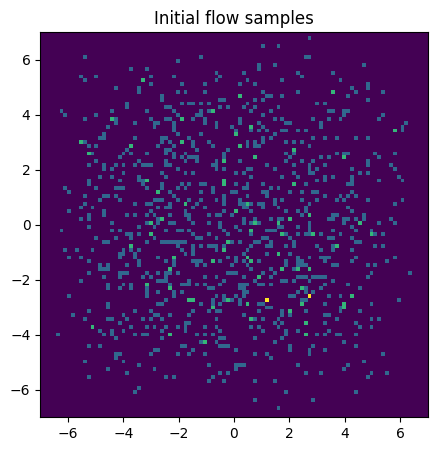

In [10]:

# import bijx
# import jax.random as jr
import jax.numpy as jnp
# from flax import nnx
# import optax
# from learning.module.bijx.realnvp import make_realnvp_bijx

# data_key, flow_key, train_key, sample_key = jr.split(jr.key(0), 4)
# rngs = nnx.Rngs(params=0, sample=1)
# ndim=2
# bins = 16  # same as Zuko's `bins`
# hidden = (64, 64)
# n_transforms = 3
low = jnp.array([-7.0, -7.0])
high = jnp.array([7.0, 7.0])
# dist_bijx = make_realnvp_bijx(
#     ndim=ndim,
#     channels=256,
#     n_layers=8,
#     seed=0,
#     domain_range=(low, high),
# )

# import optax

# optimizer = nnx.Optimizer(
#     dist_bijx,
#     optax.adam(1e-3),
#     wrt=nnx.Param,
# )


from learning.module.normalizing_flow.simple_flow import make_realnvp_flow_networks
rng = jax.random.PRNGKey(0)
key_sample, rng_params, rng = jax.random.split(rng,3 )
realnvp = make_realnvp_flow_networks(num_blocks=6, in_channels=2, channels=256, domain_range = (low, high))

# flow_params = realnvp.init(rng_params, mode='sample', num_samples=1024, rng=key_sample)
flow_params = realnvp.init(rng_params)
x, log_q = realnvp.apply(flow_params, mode='sample',n_samples=1024, rng=key_sample)
lp = realnvp.apply(flow_params, mode='log_prob', x=x)
log_q - lp
# Sampling:
key = jax.random.PRNGKey(0)
contexts, logq = realnvp.apply(flow_params, mode="sample", n_samples=1024, rng=key)
plt.figure(figsize=(5, 5))
plt.hist2d(contexts[:, 0], contexts[:, 1], bins=100, range=[[low[0], high[0]], [low[1], high[1]]])
plt.title("Initial flow samples")
plt.show()

/tmp/ipykernel_3205446/3840855911.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))
/tmp/ipykernel_3205446/3840855911.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


Saved GIF to NF_RealNVP_training.gif


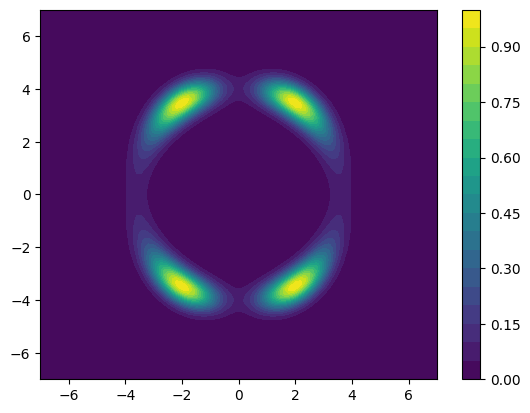

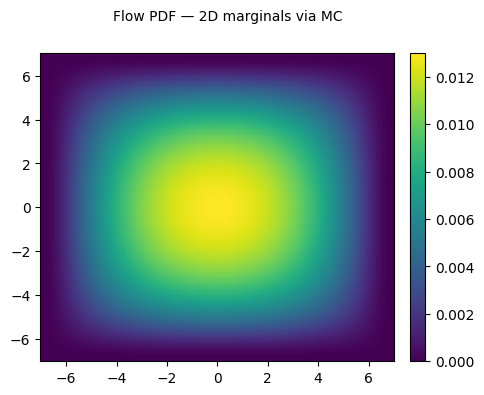

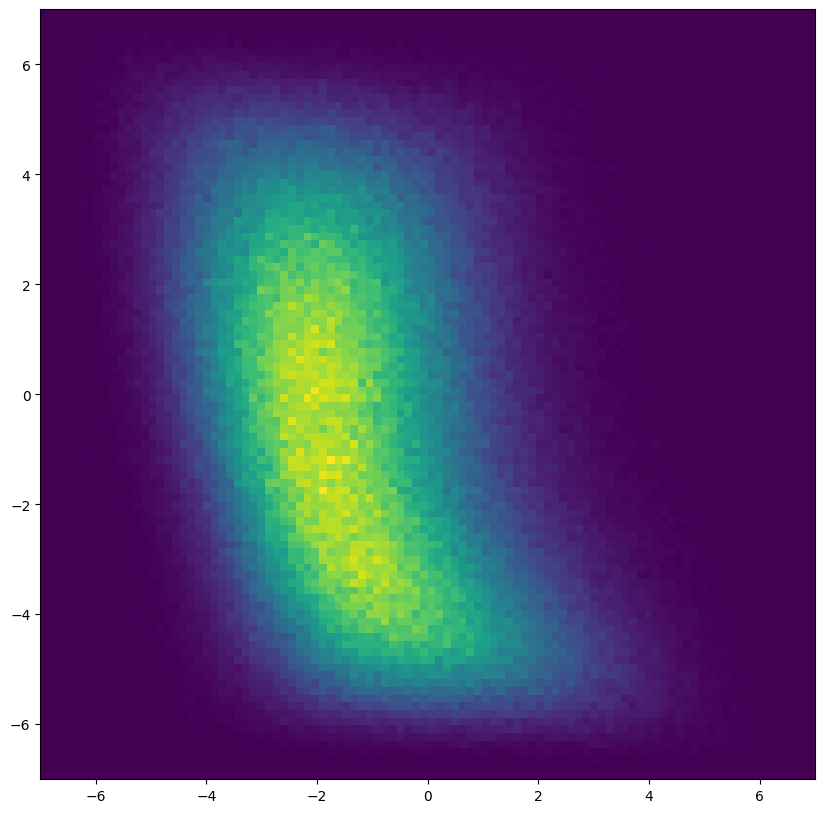

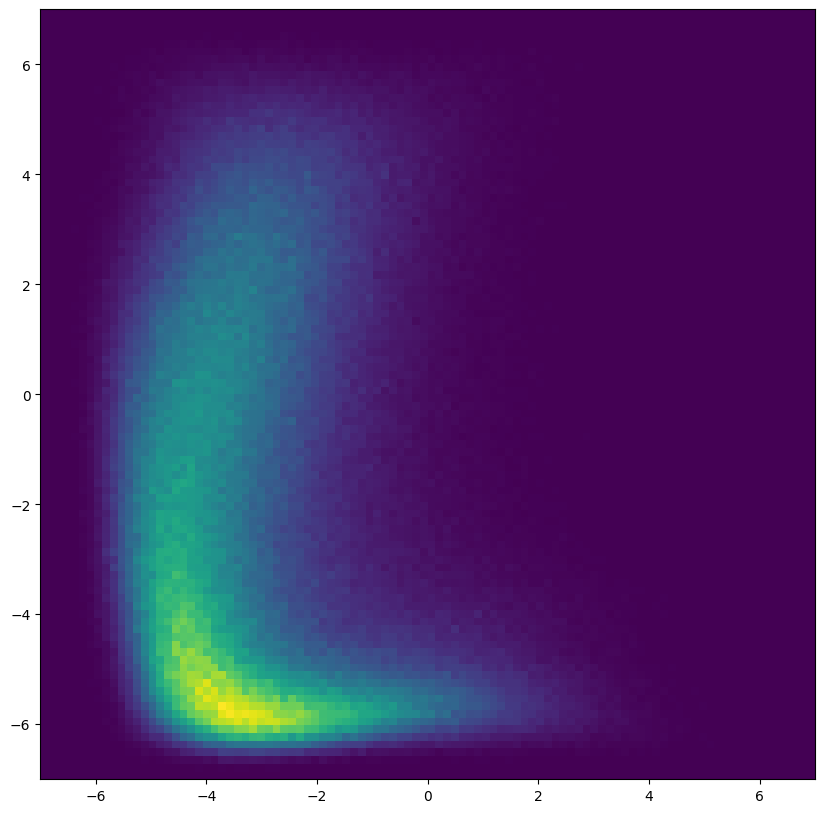

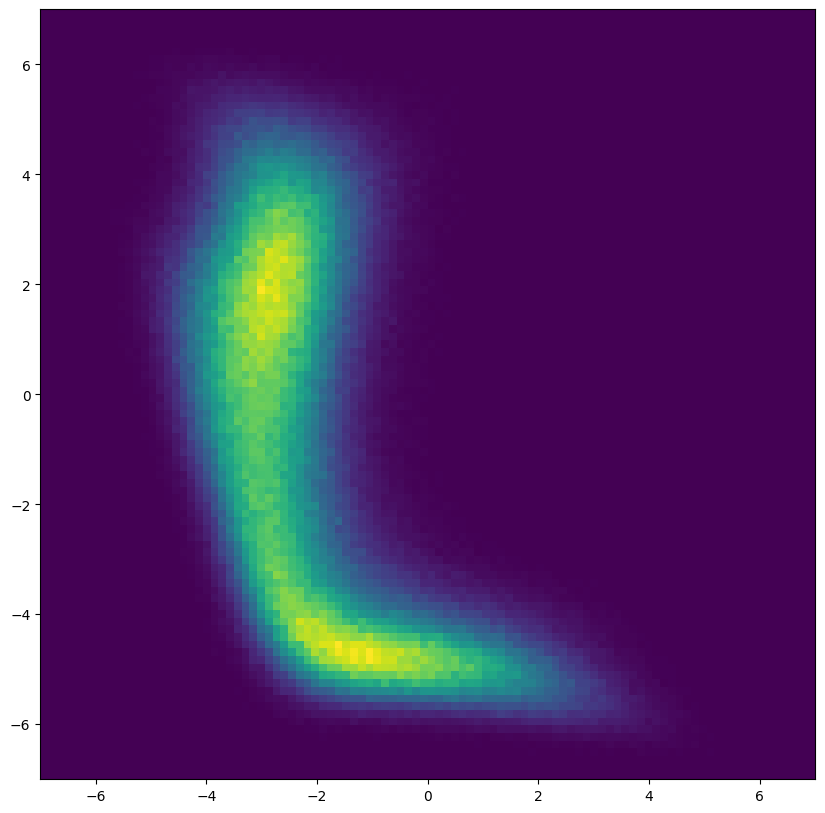

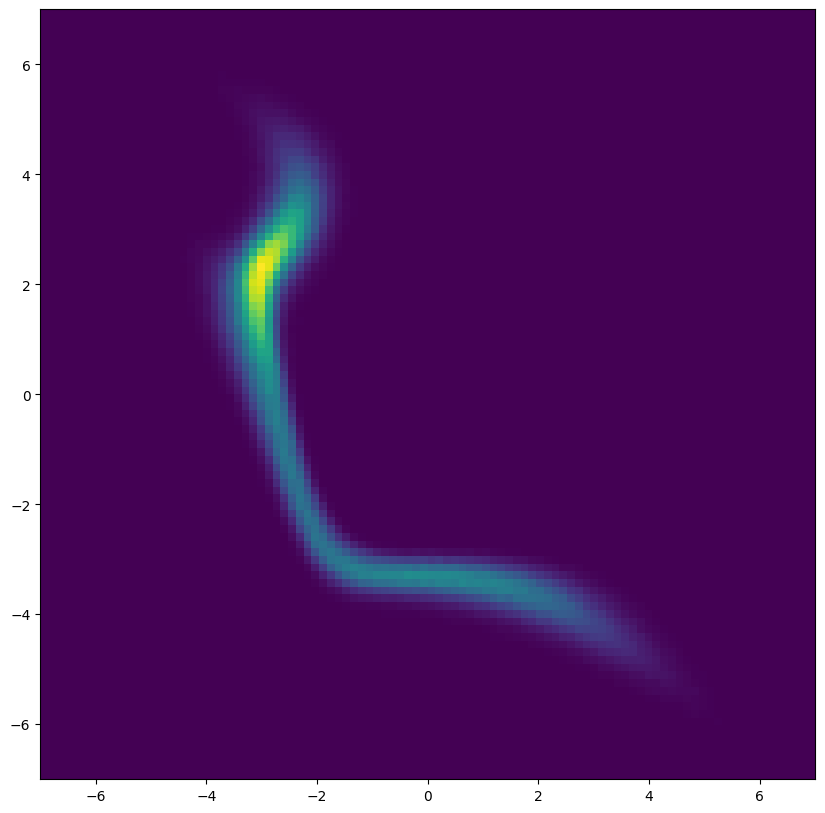

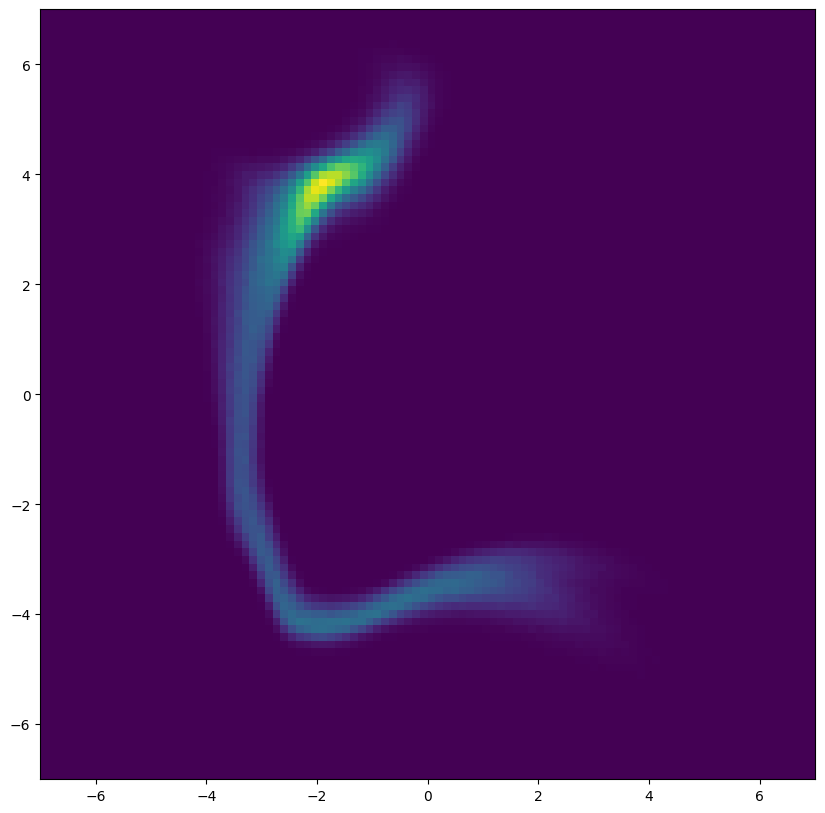

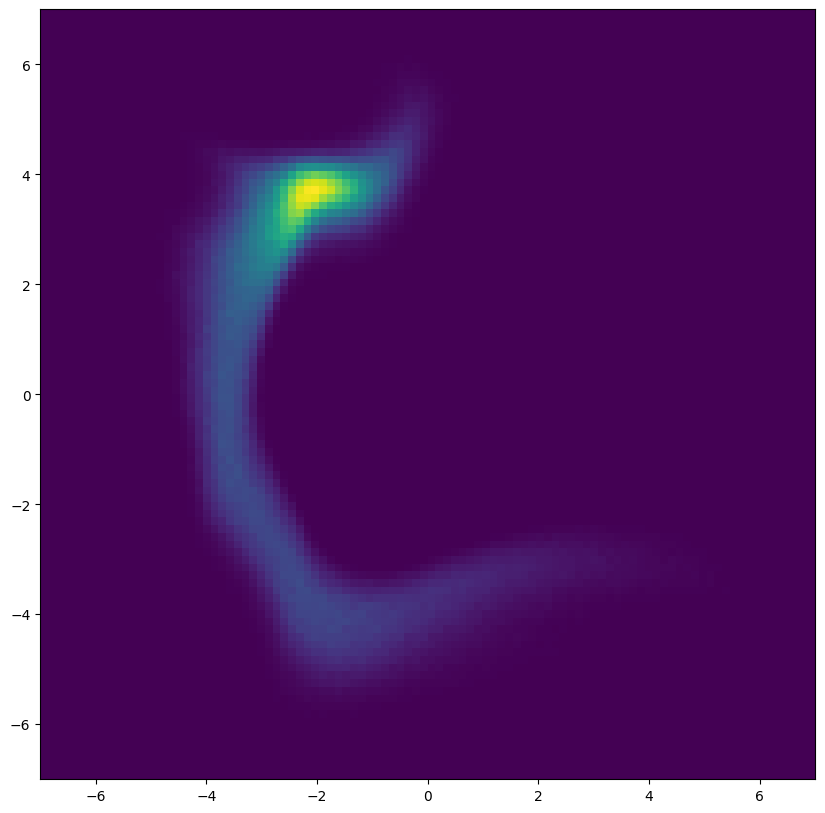

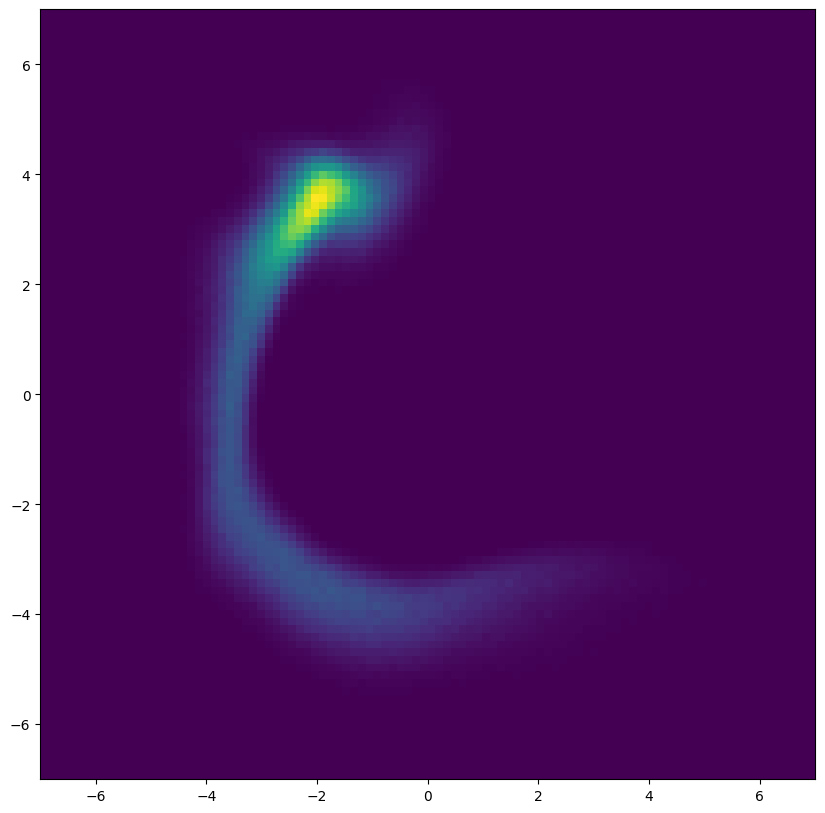

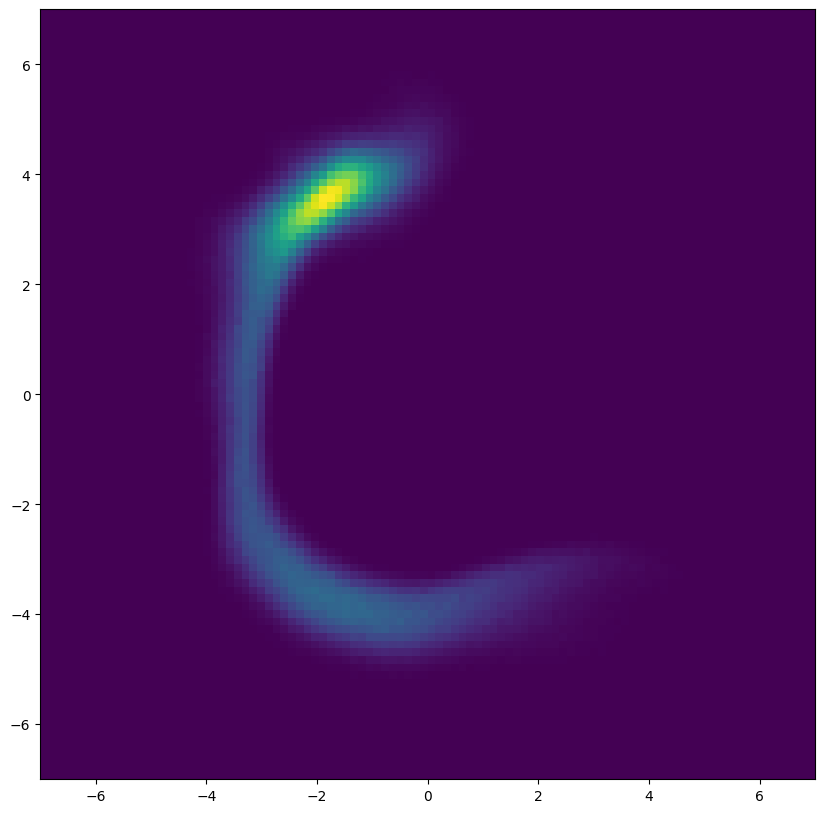

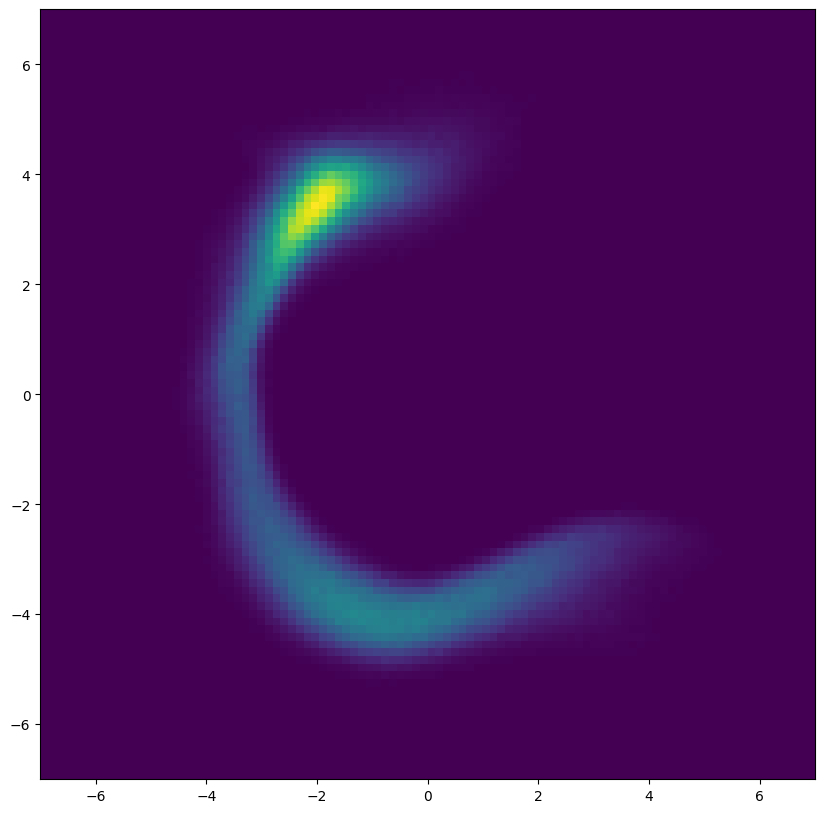

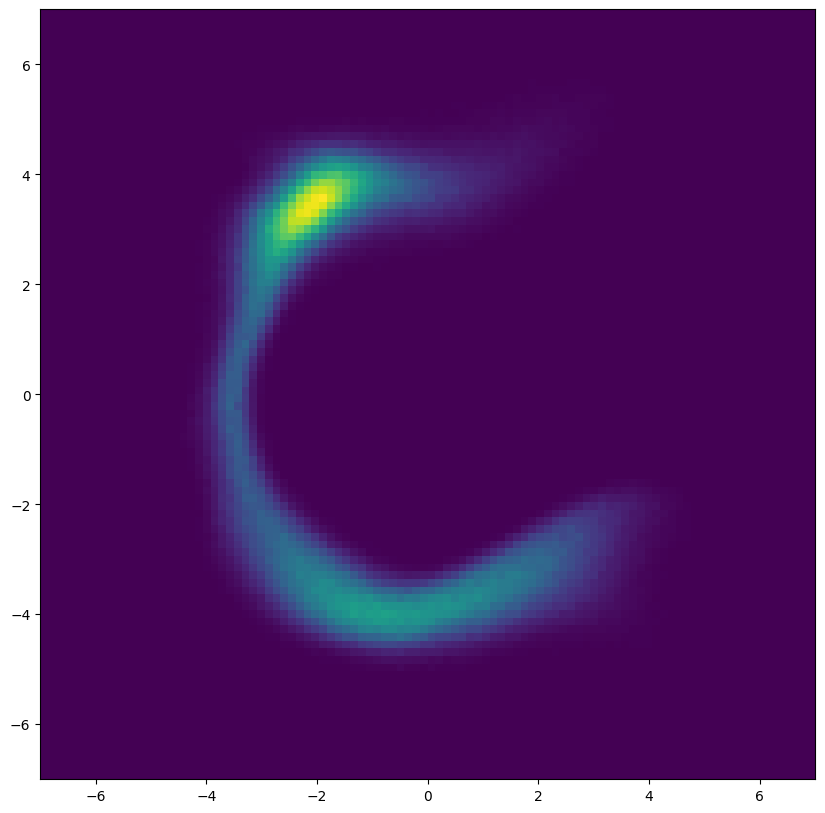

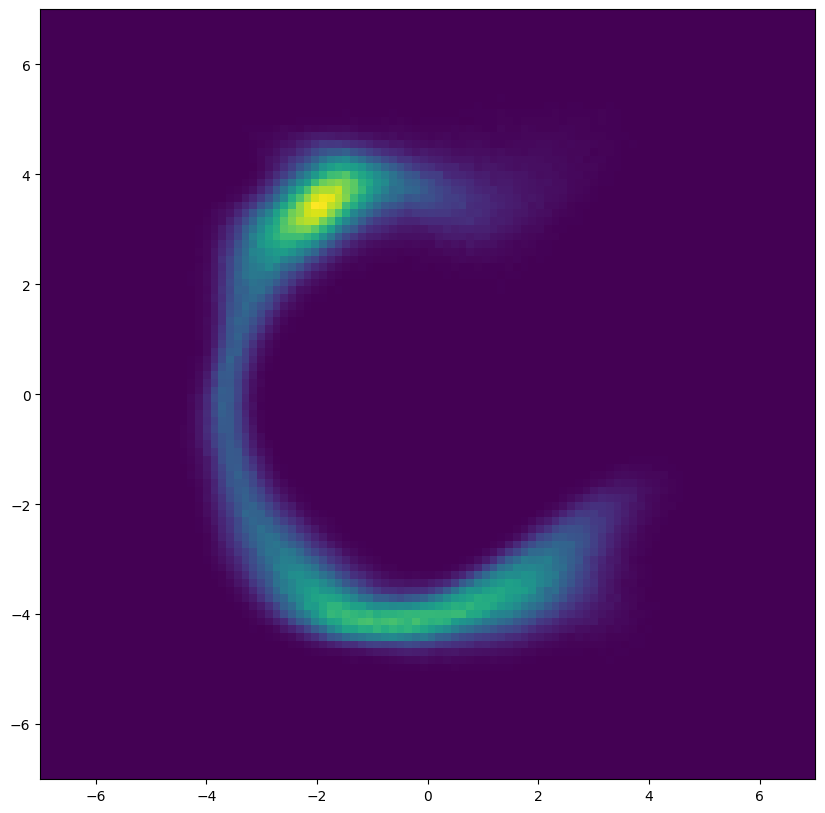

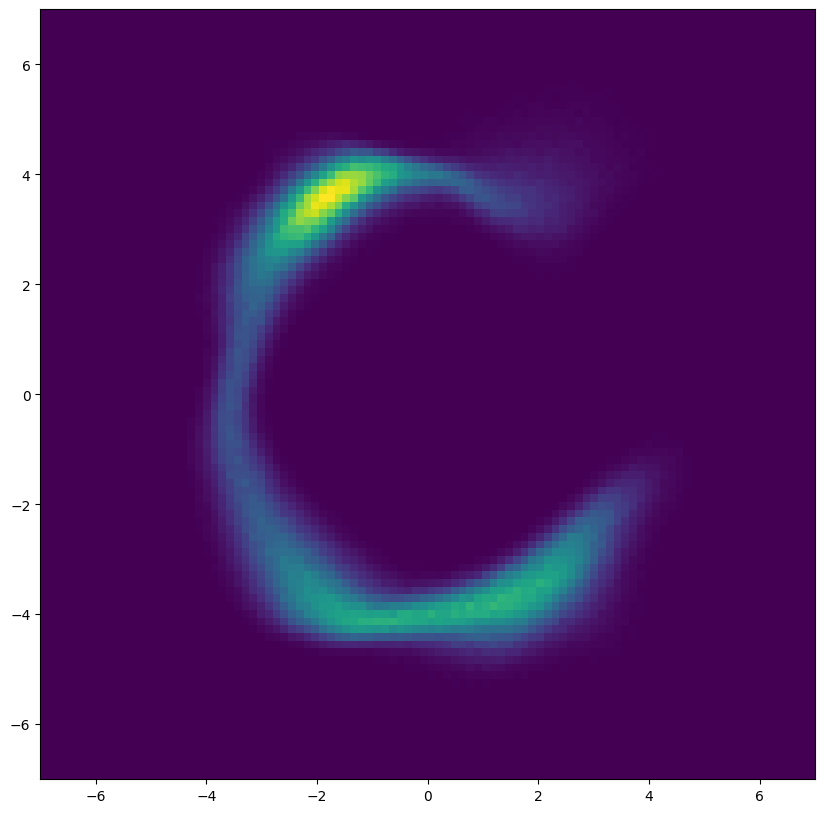

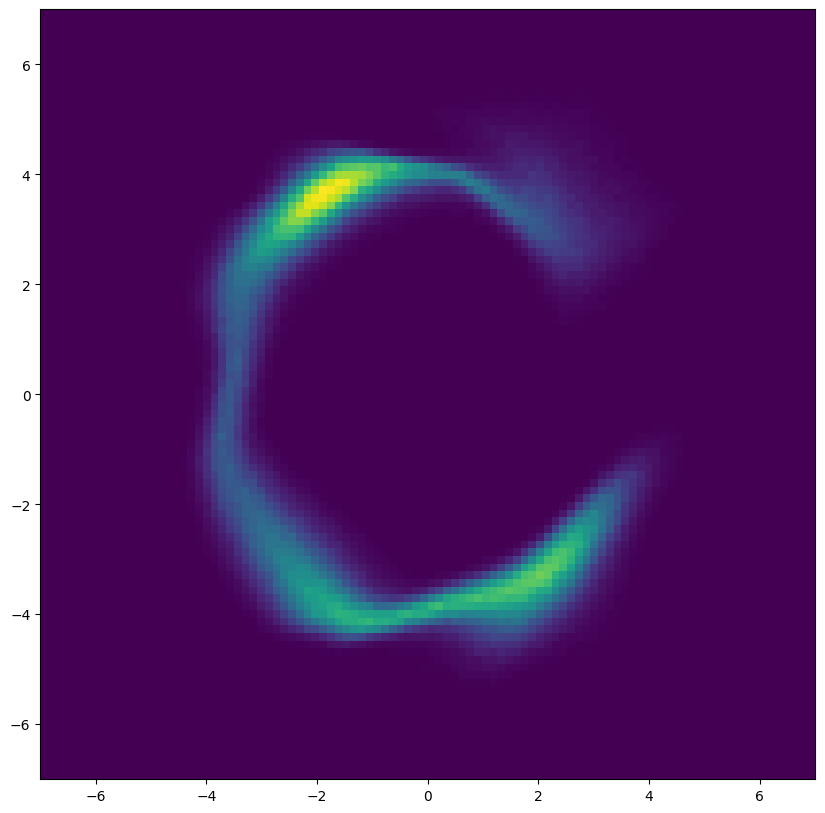

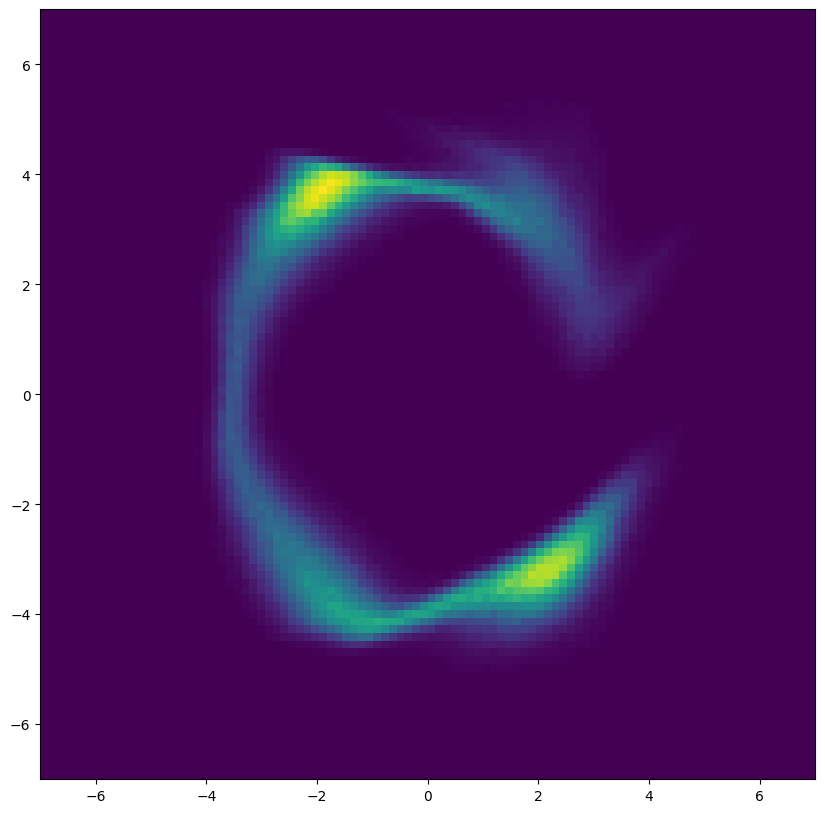

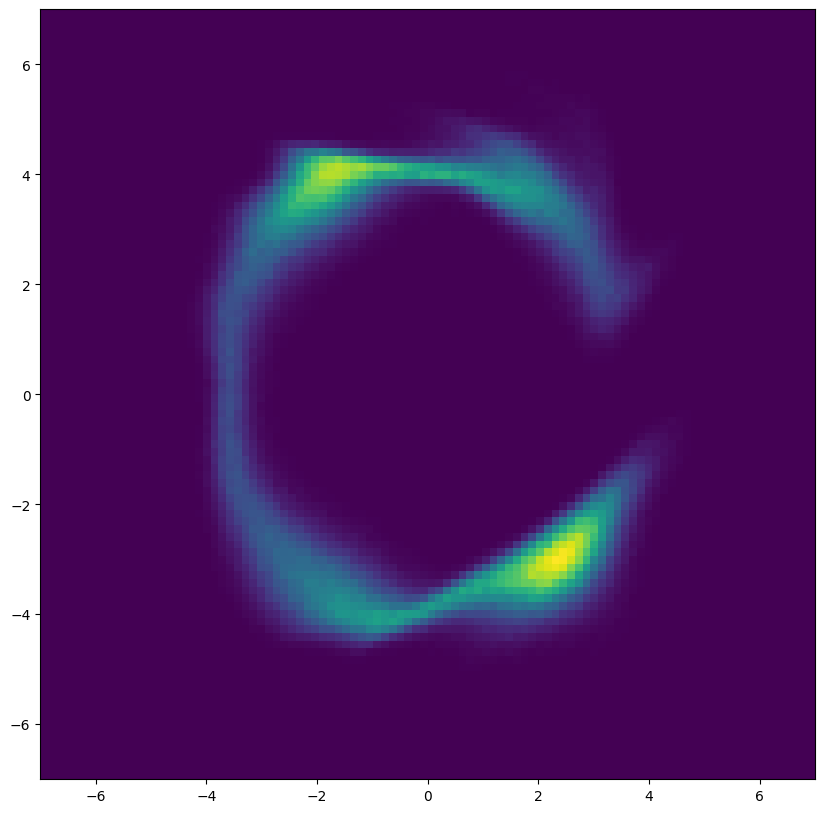

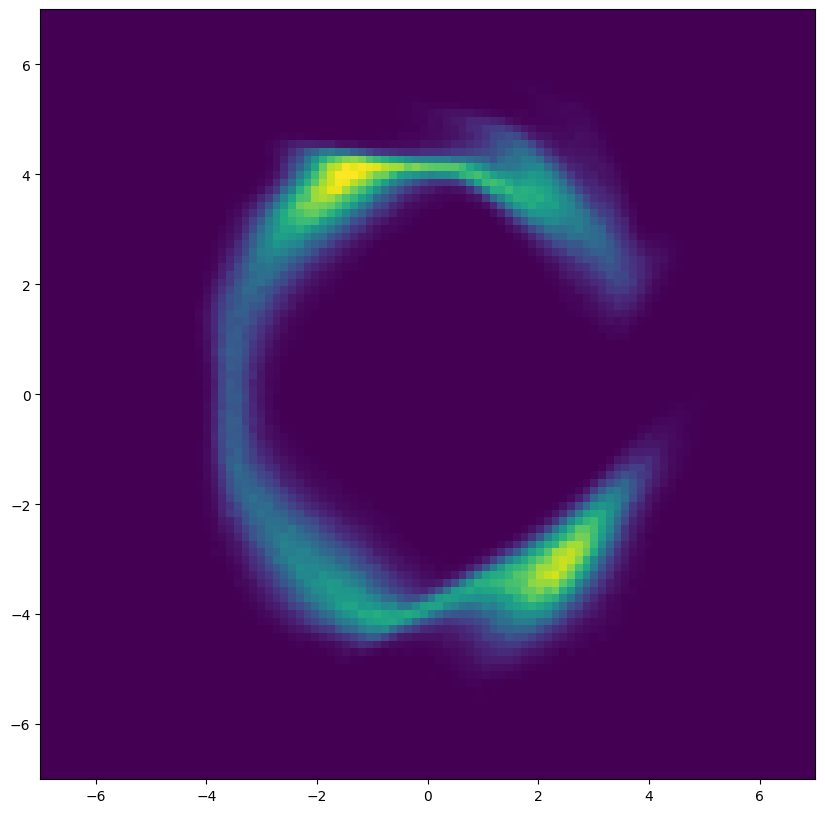

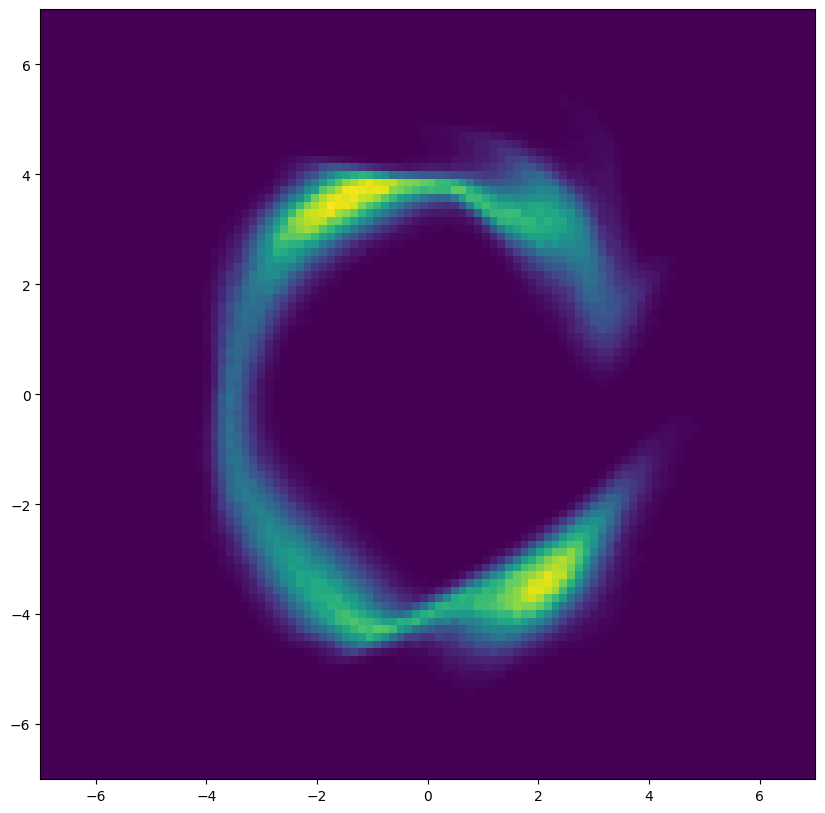

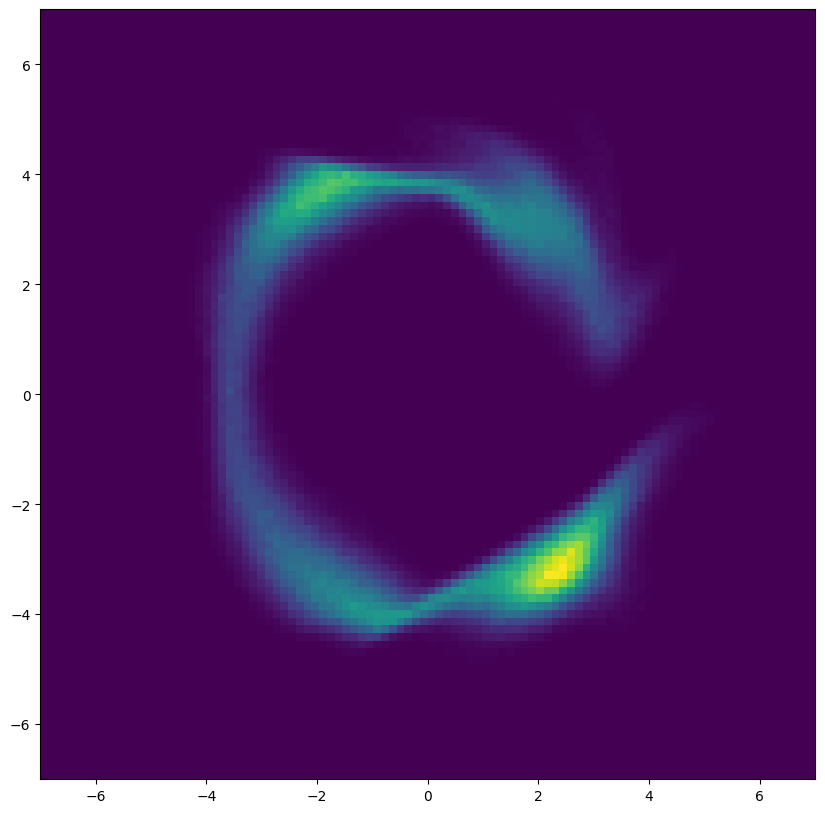

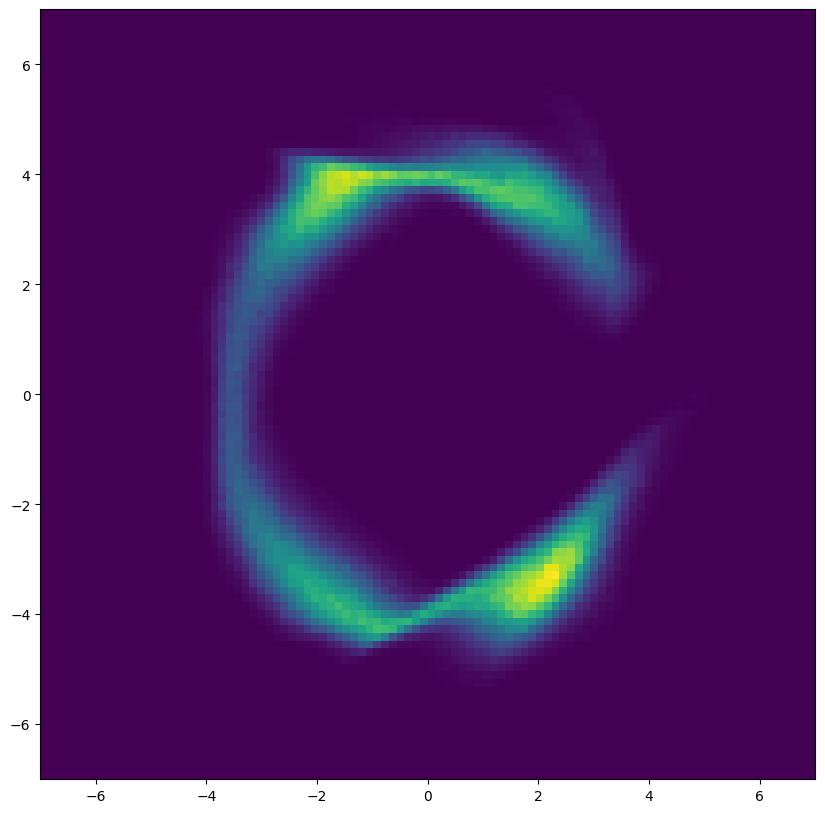

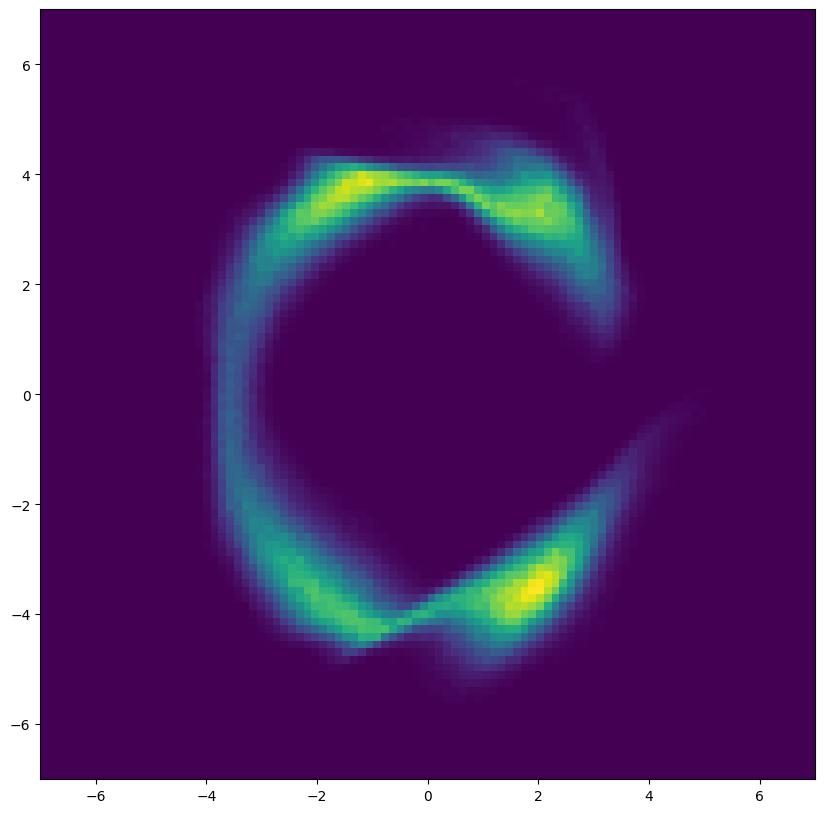

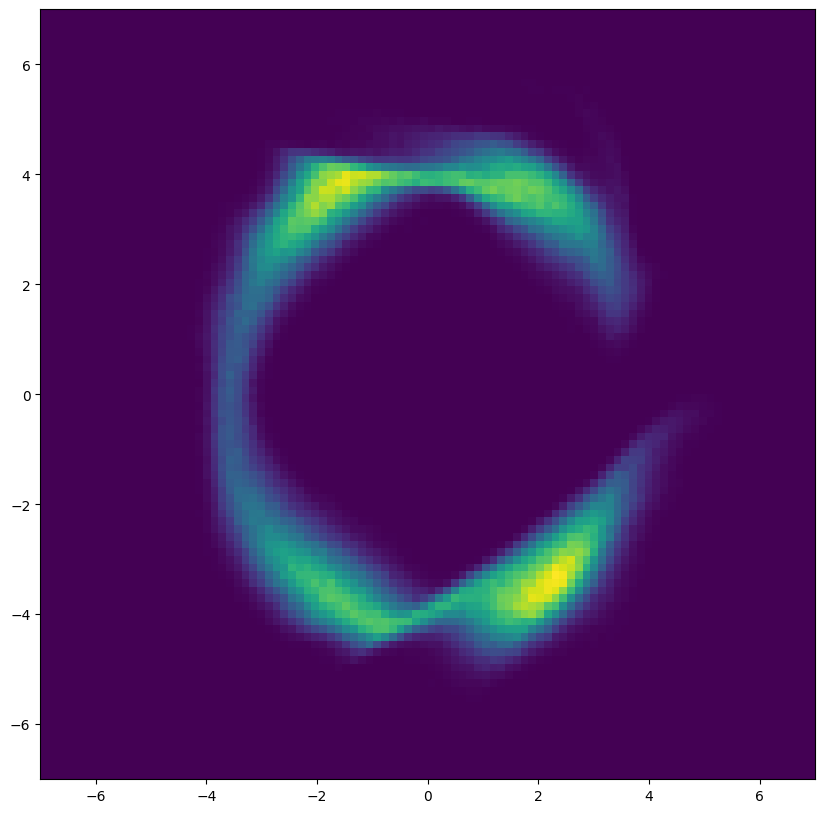

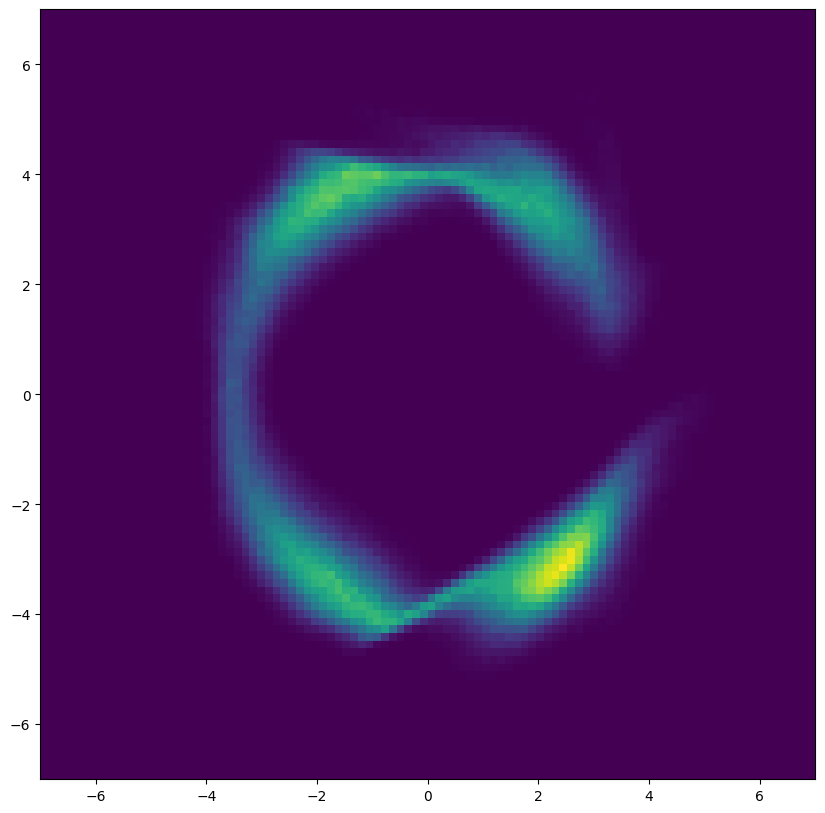

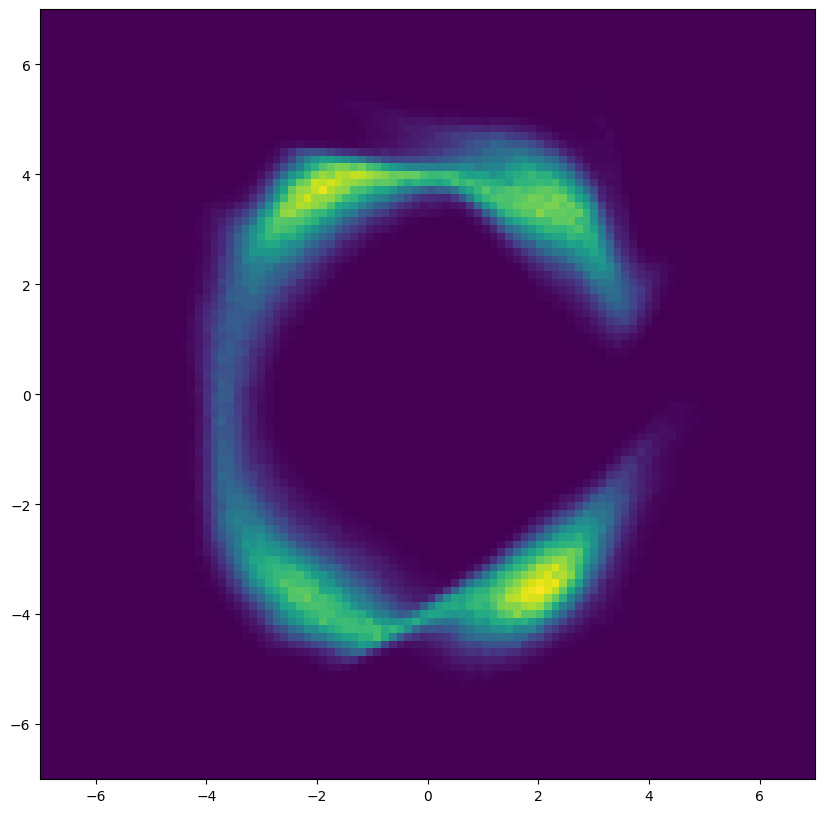

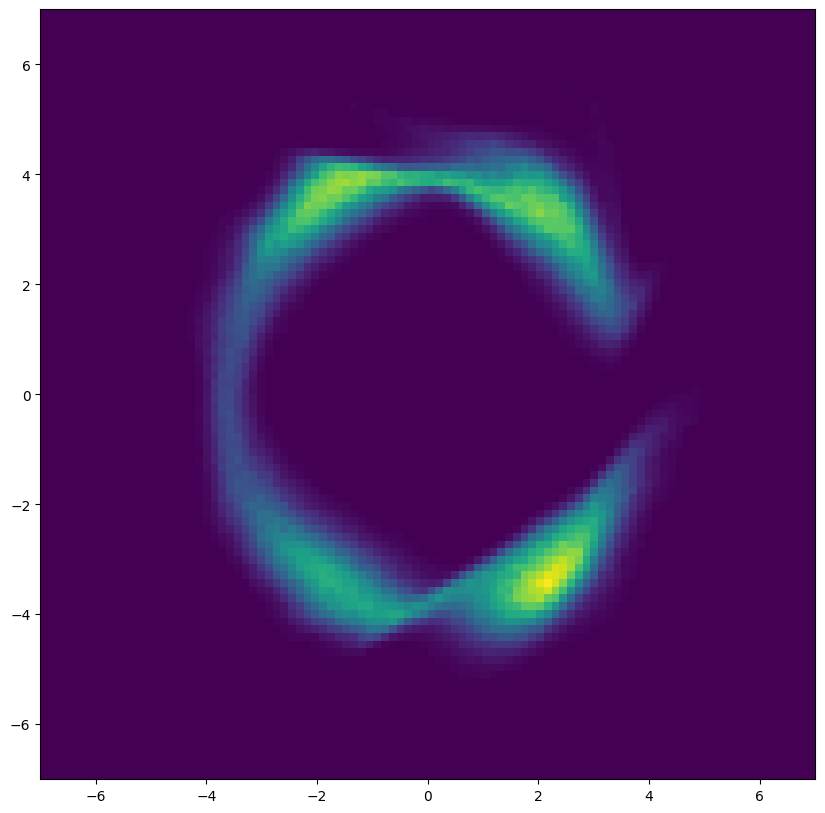

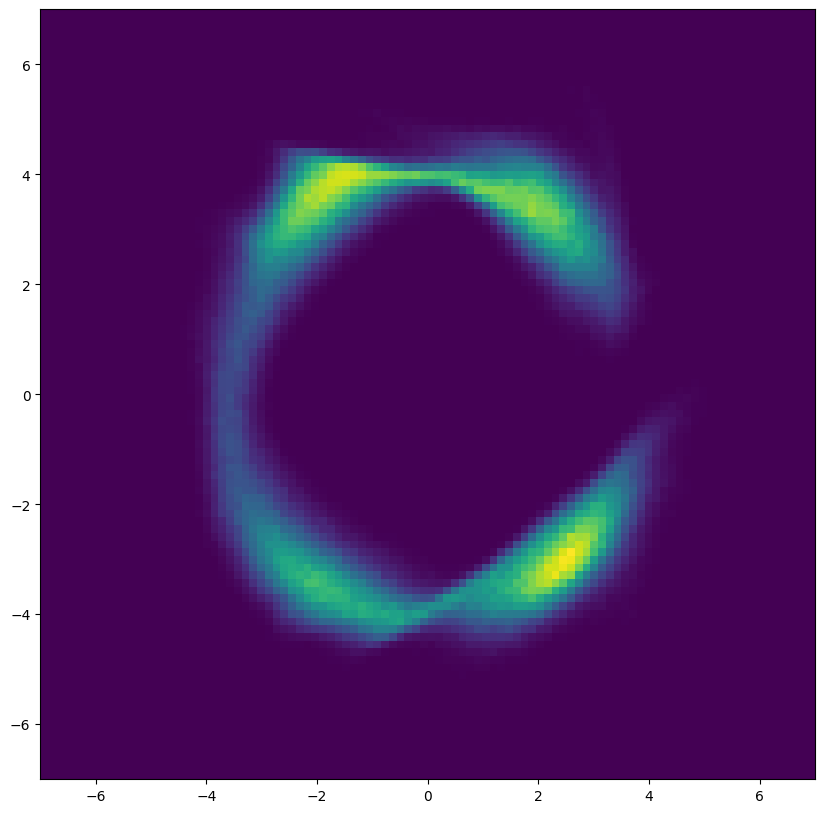

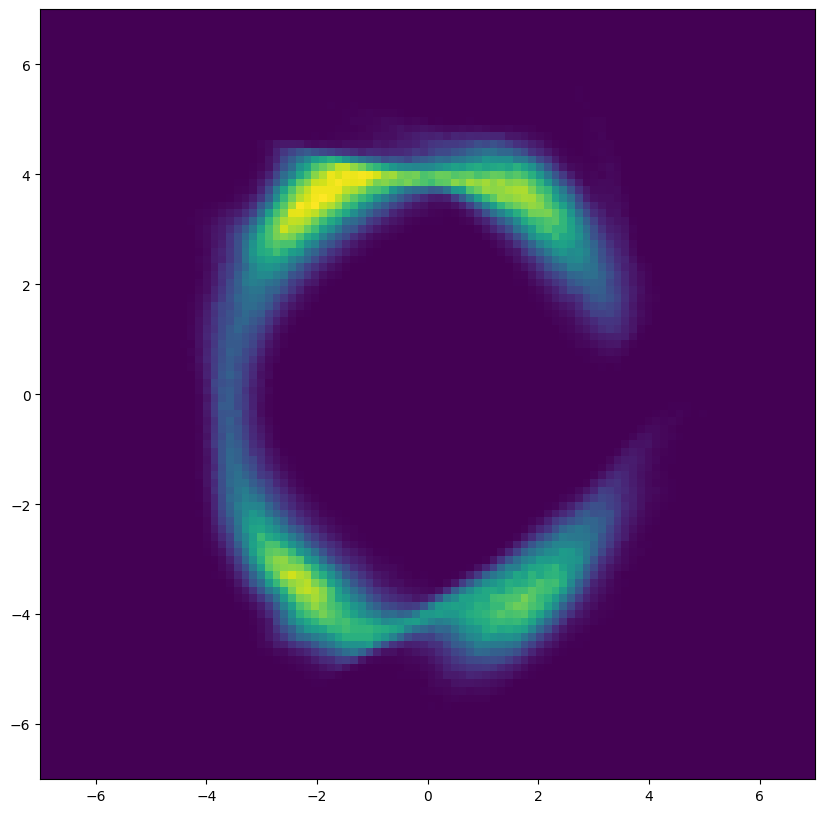

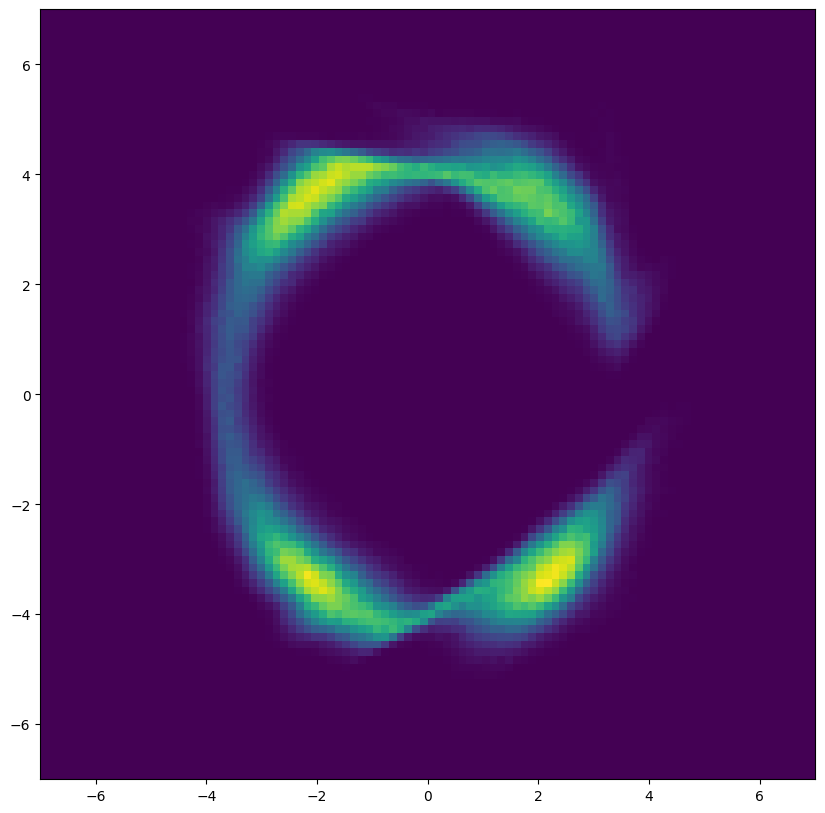

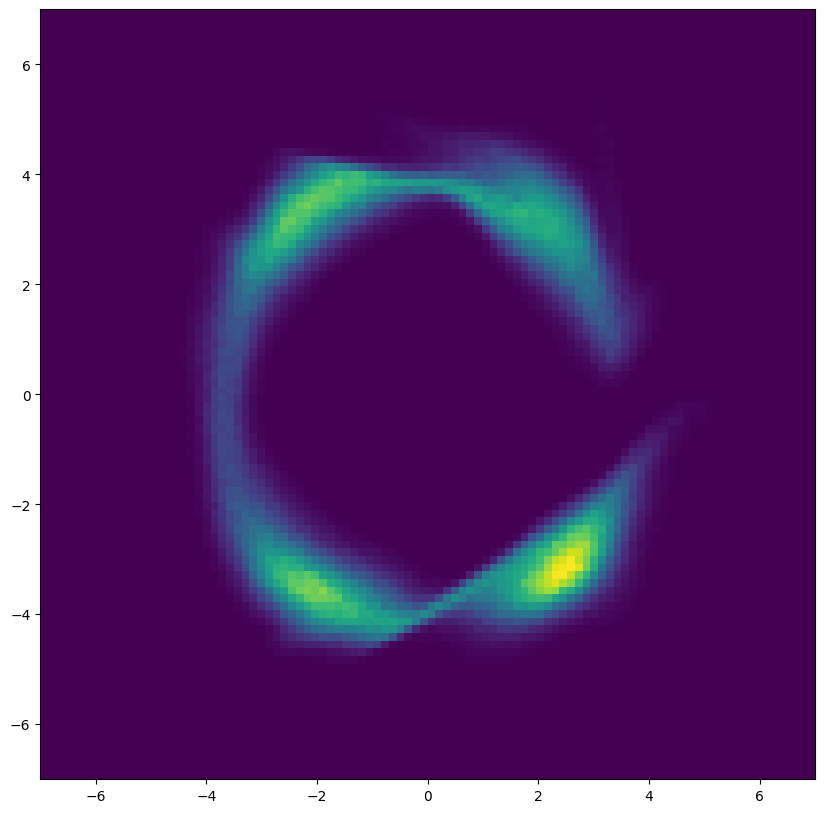

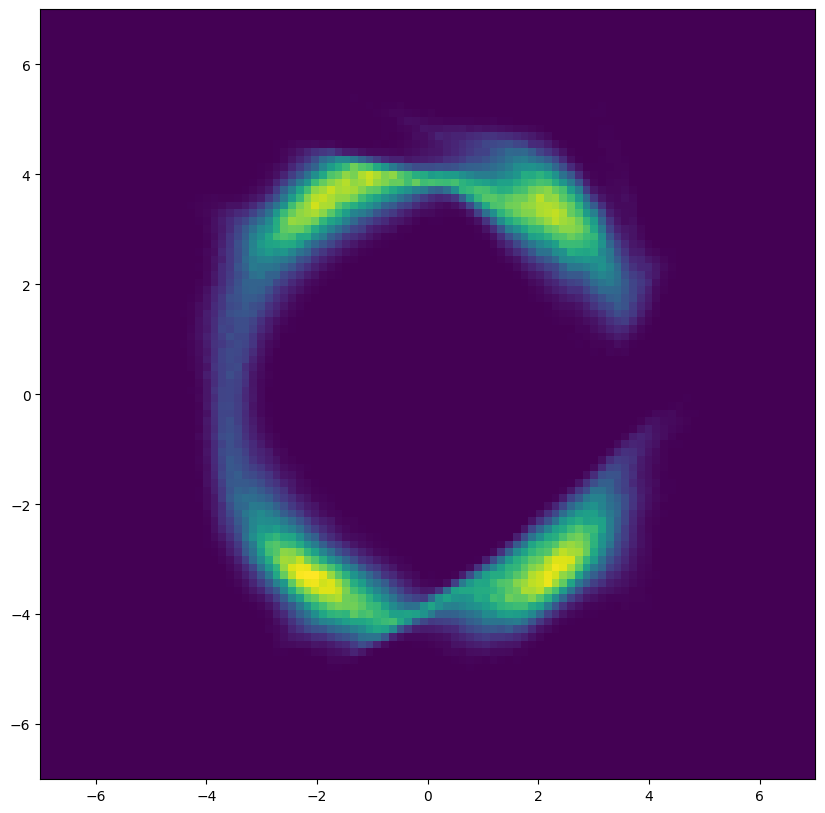

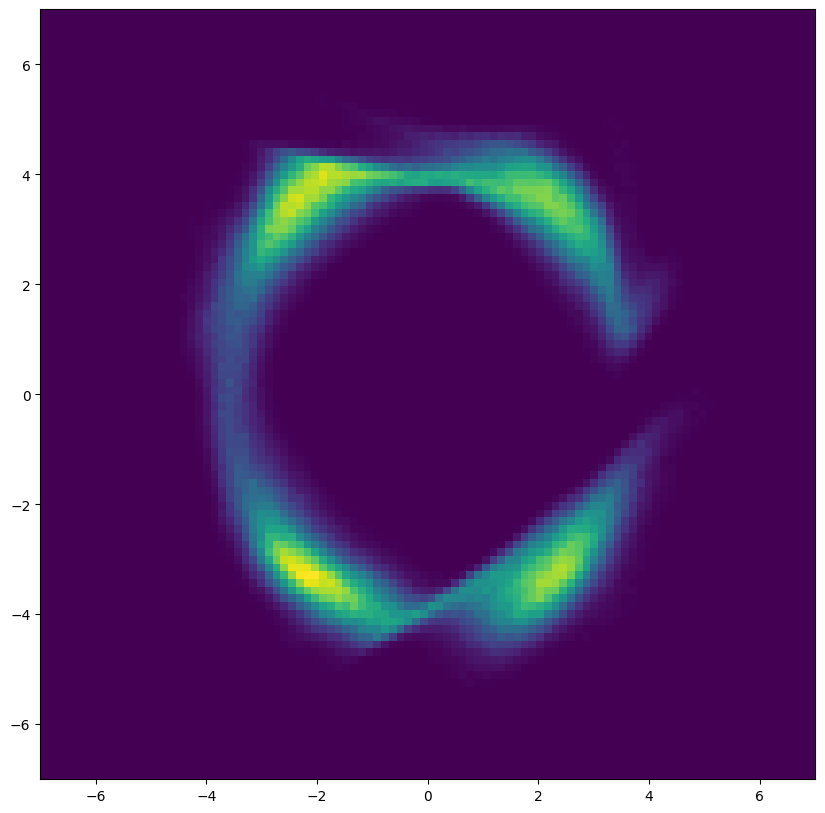

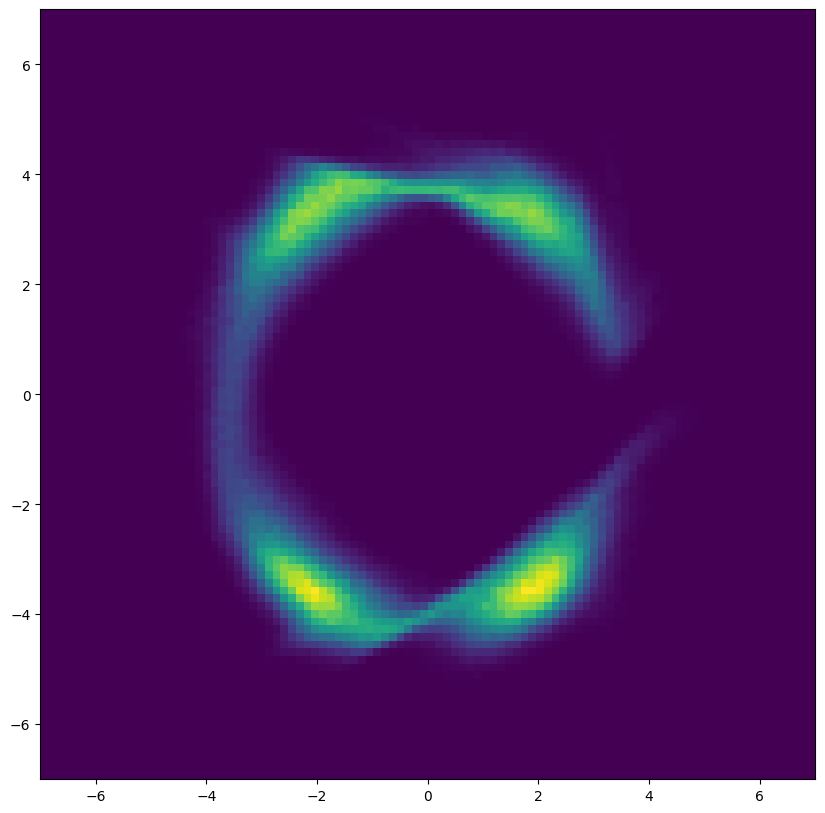

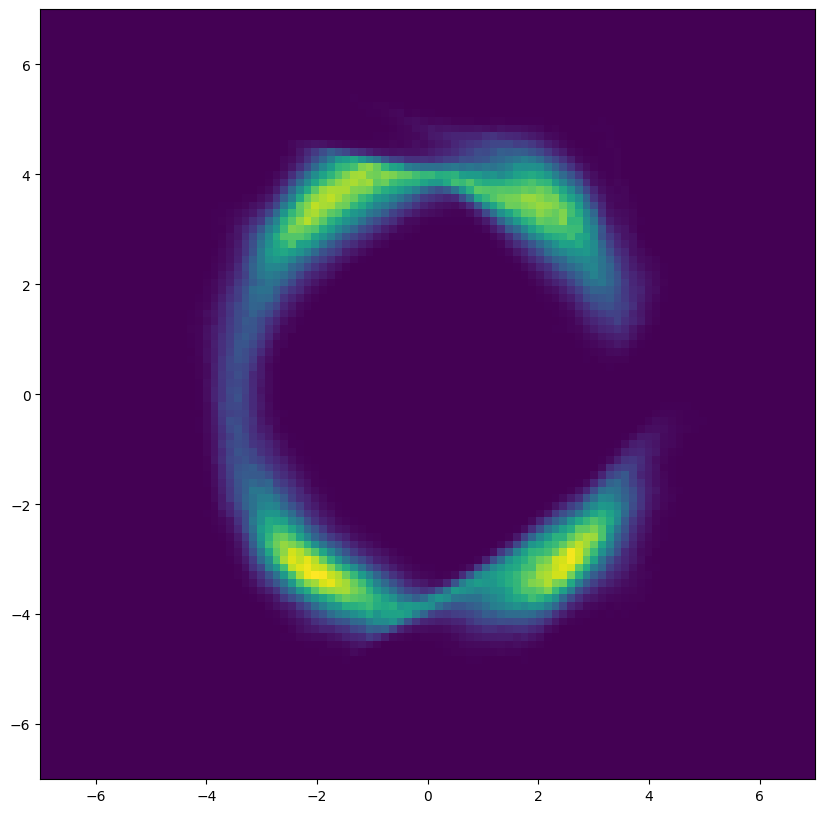

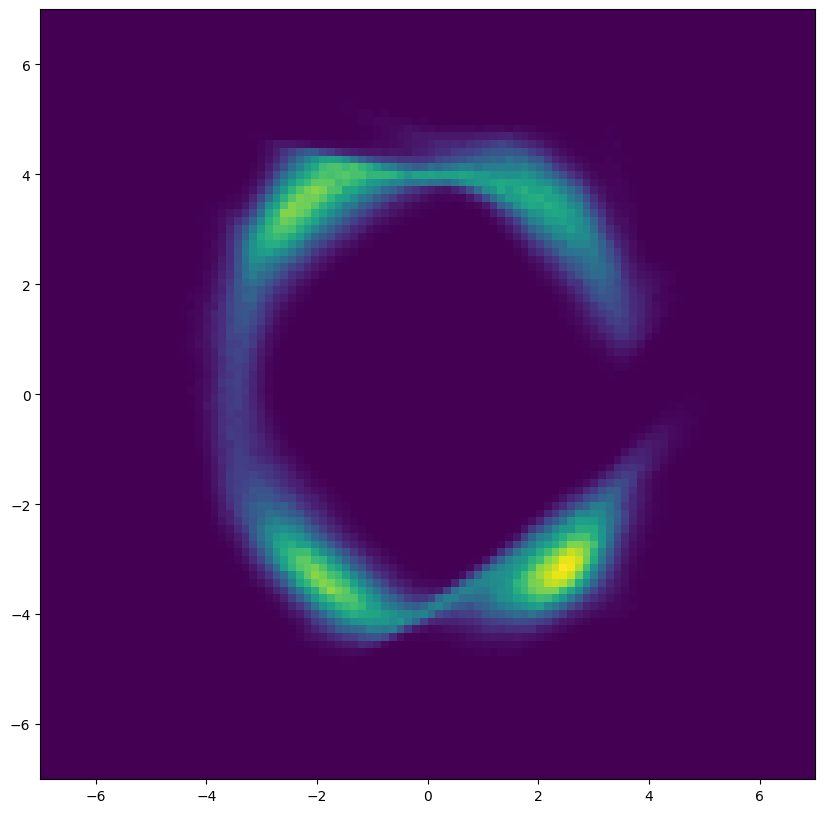

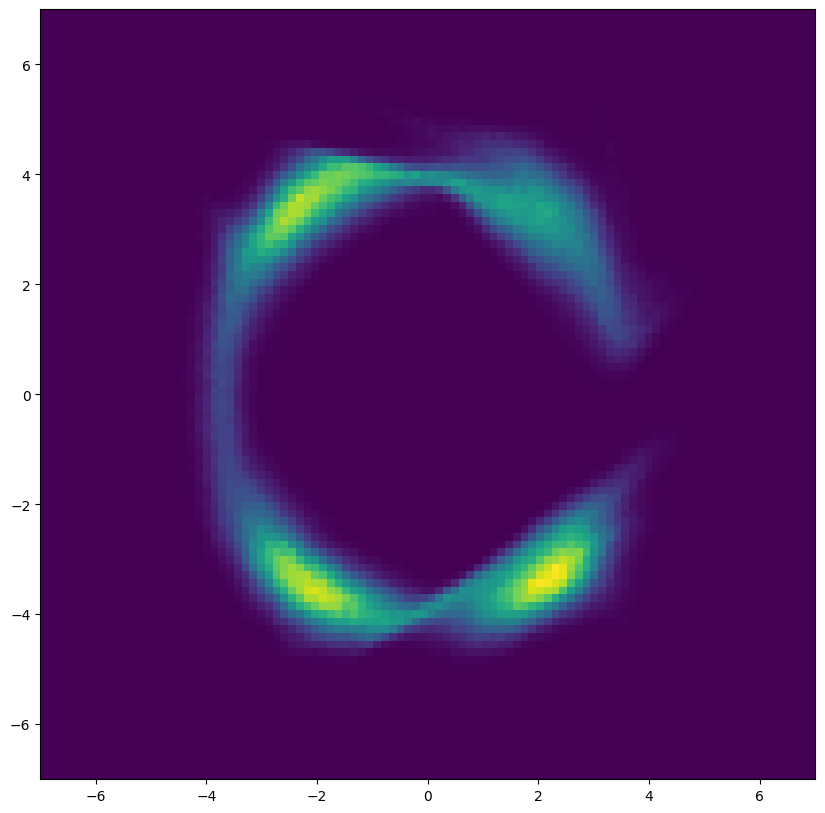

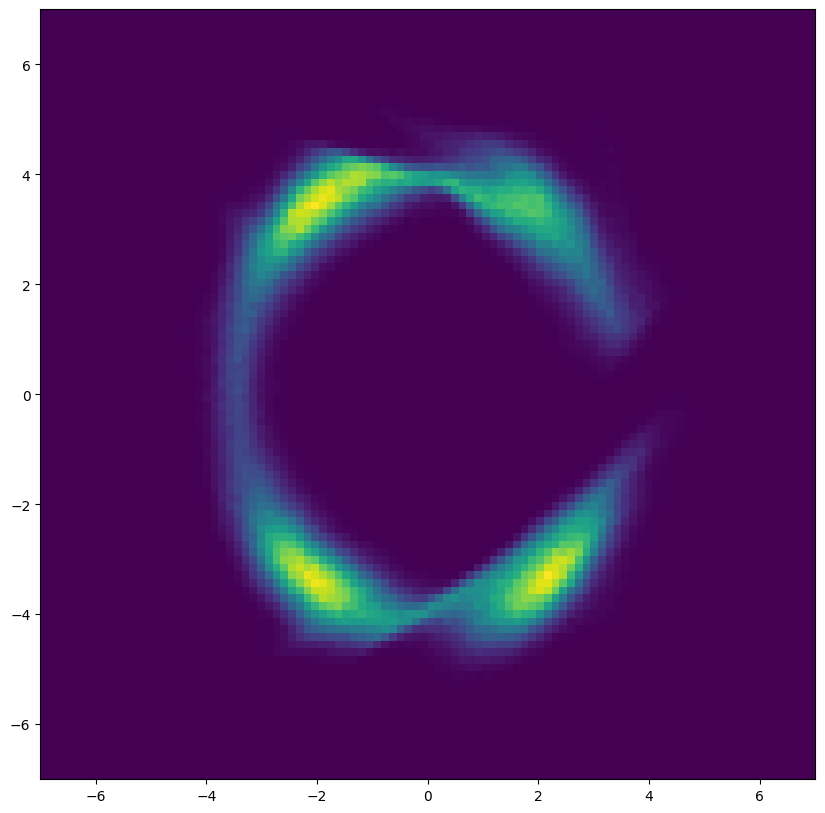

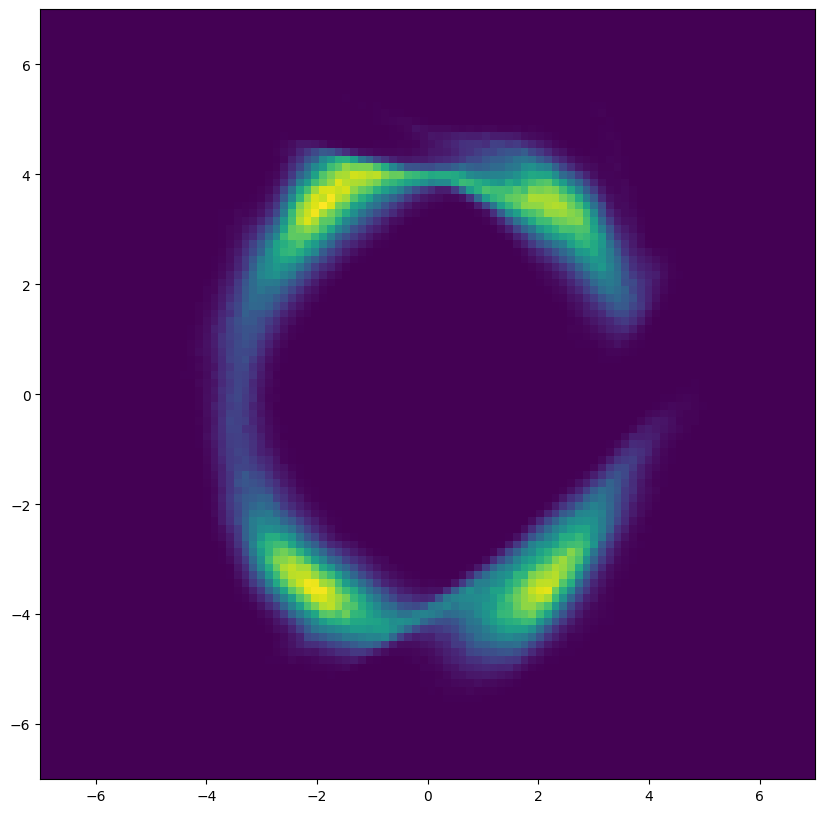

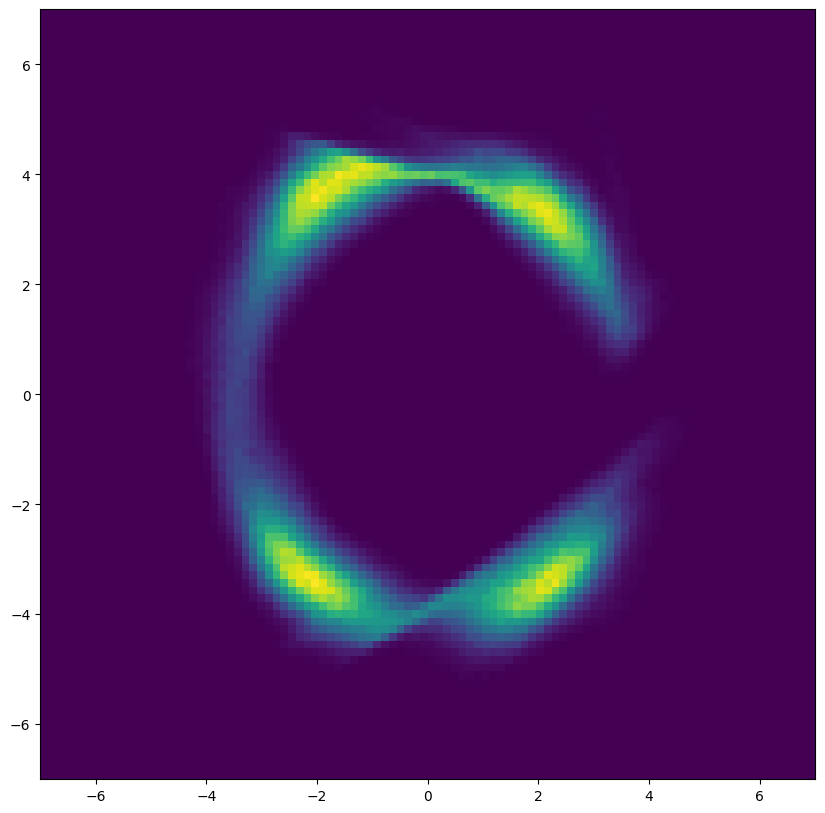

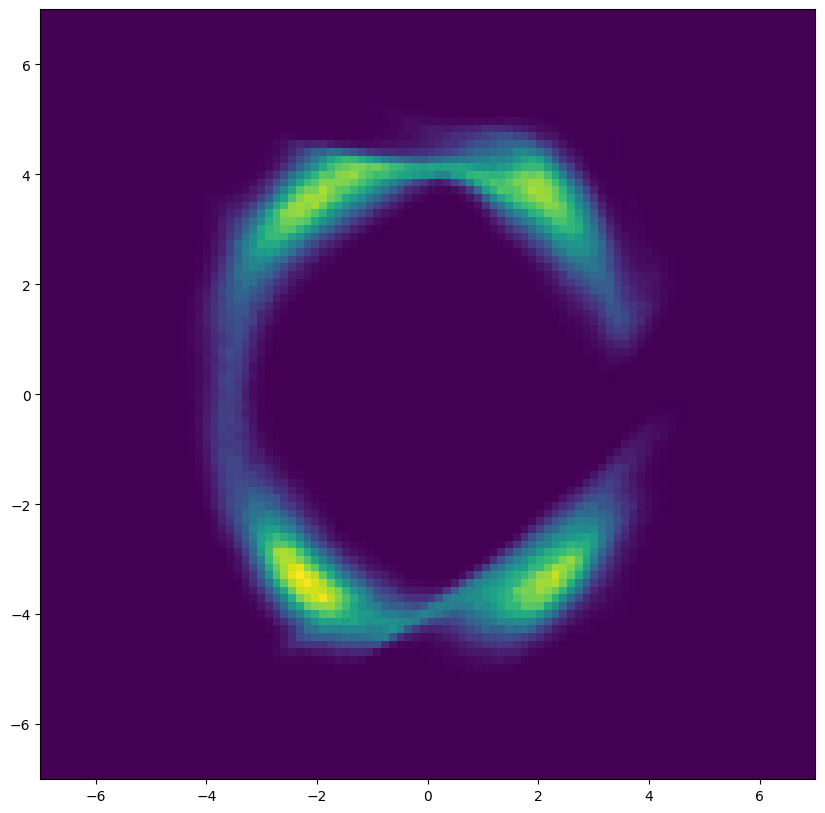

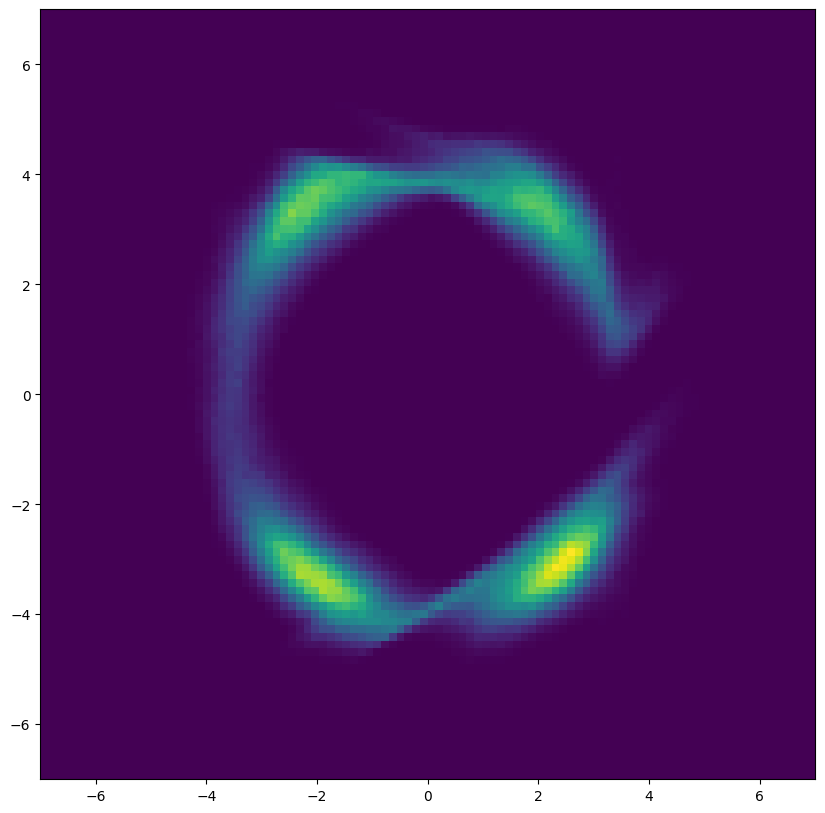

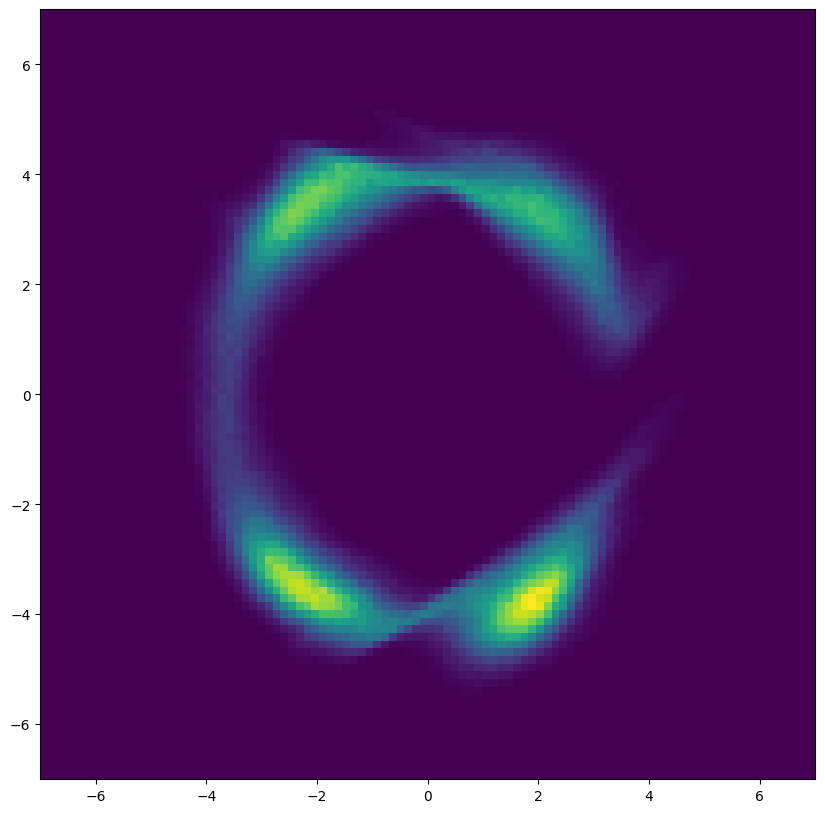

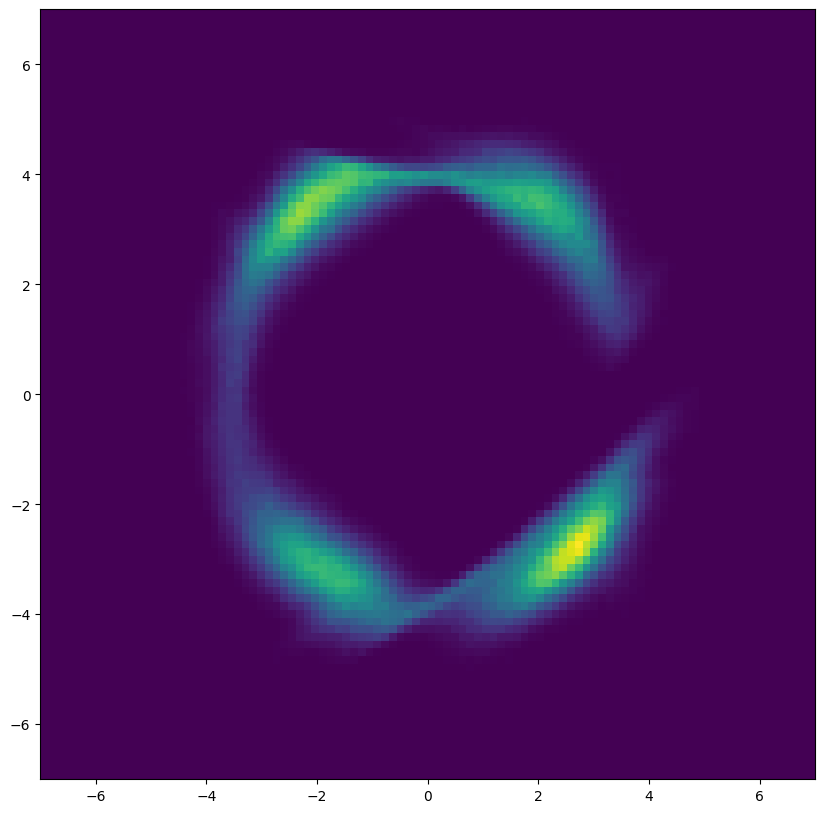

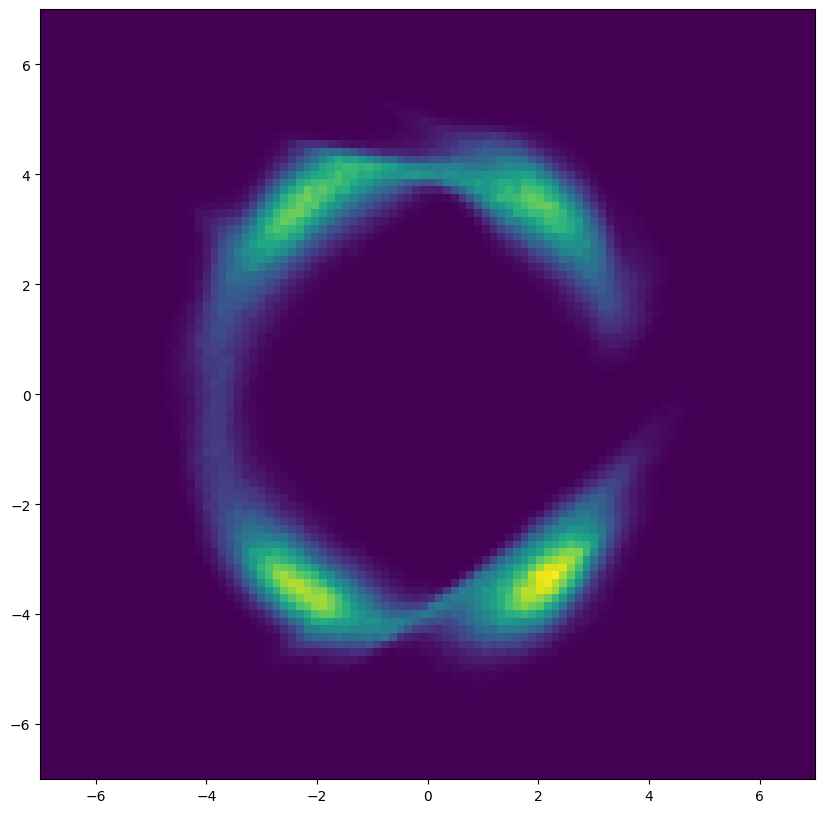

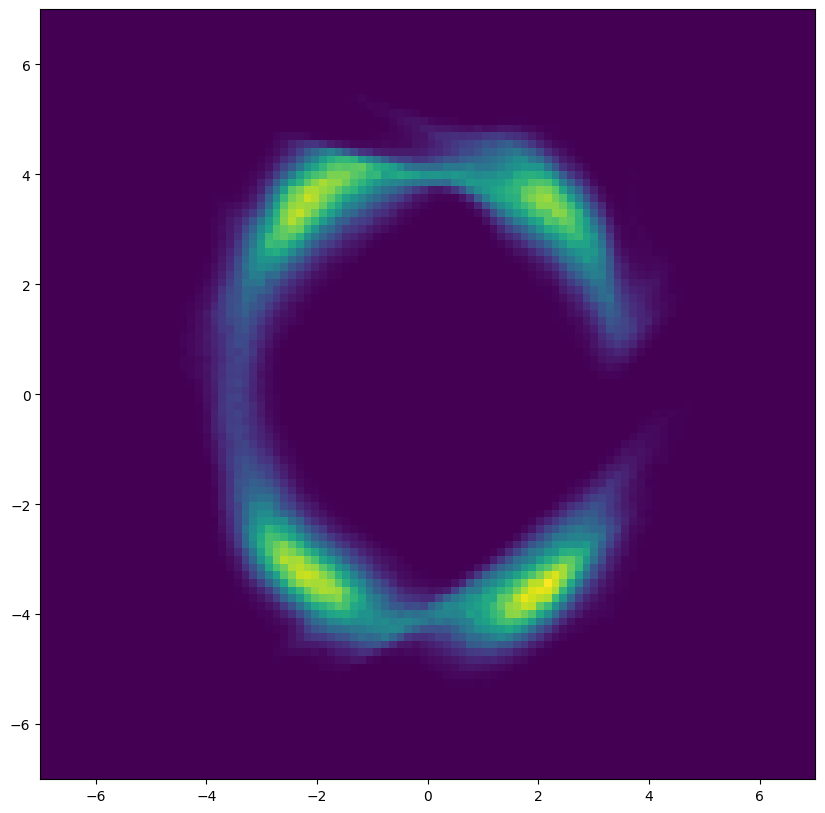

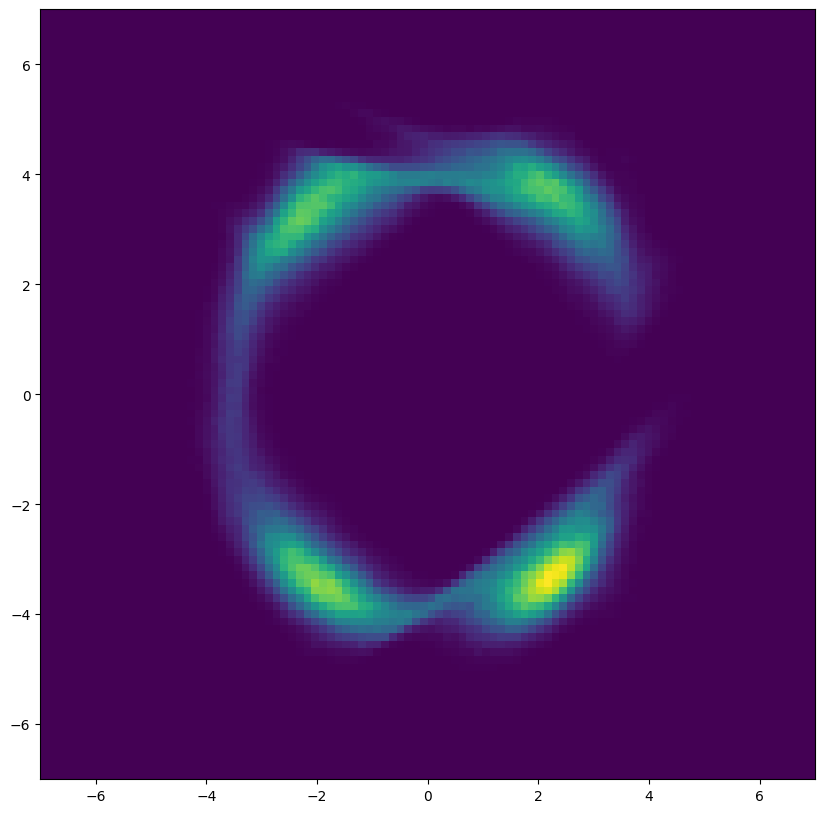

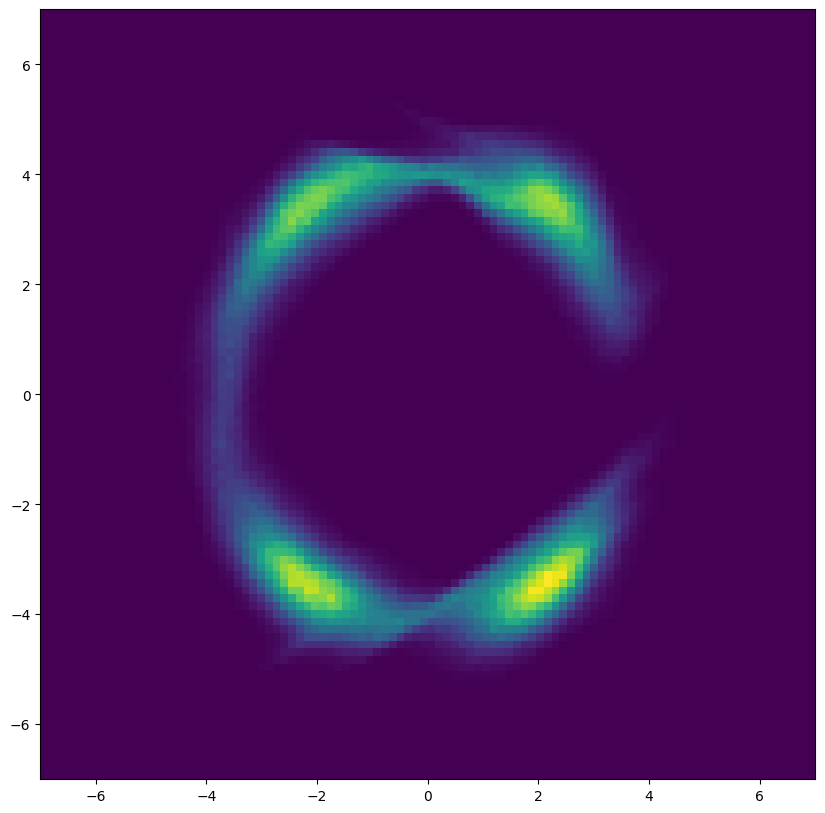

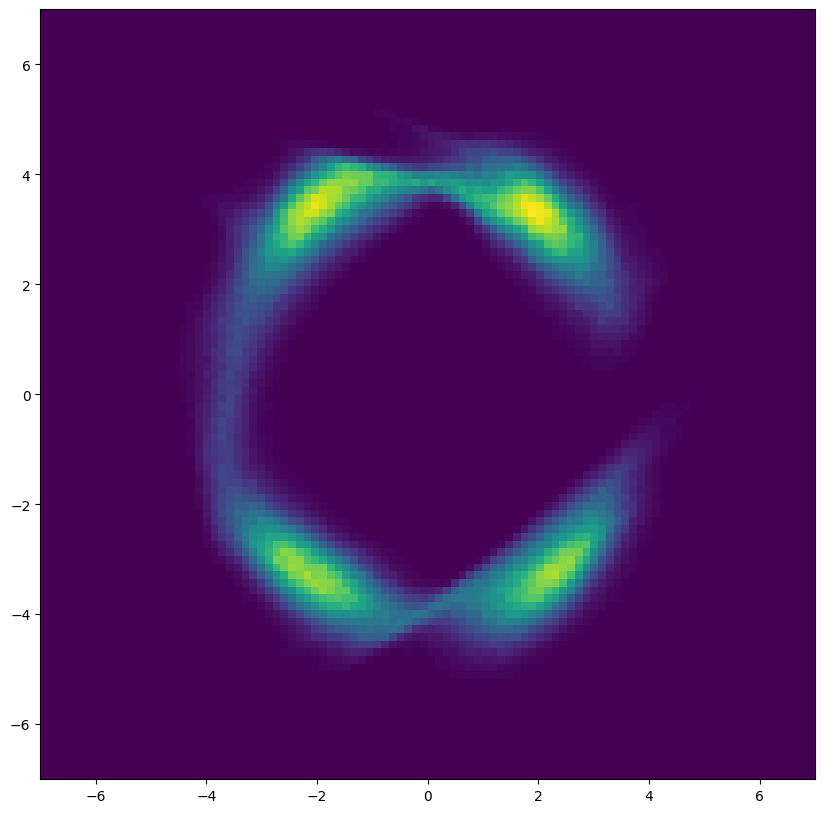

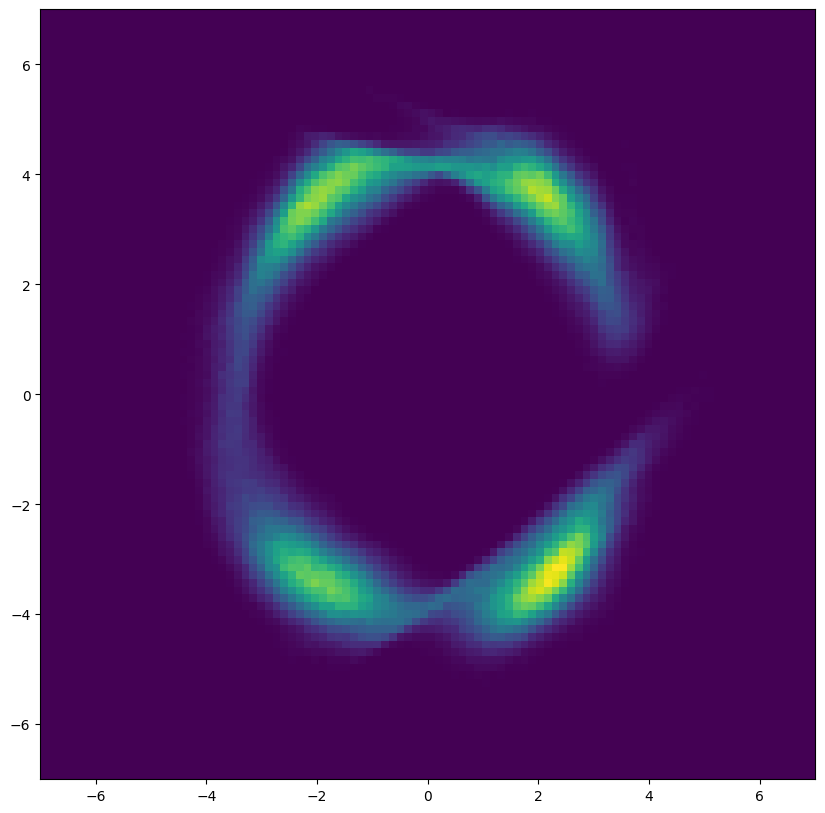

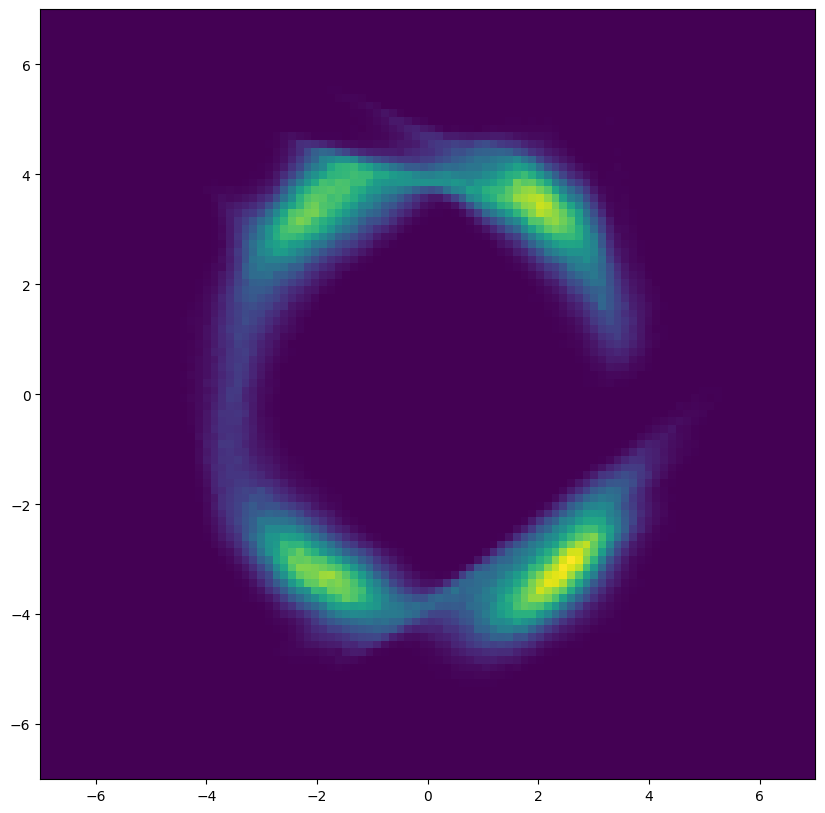

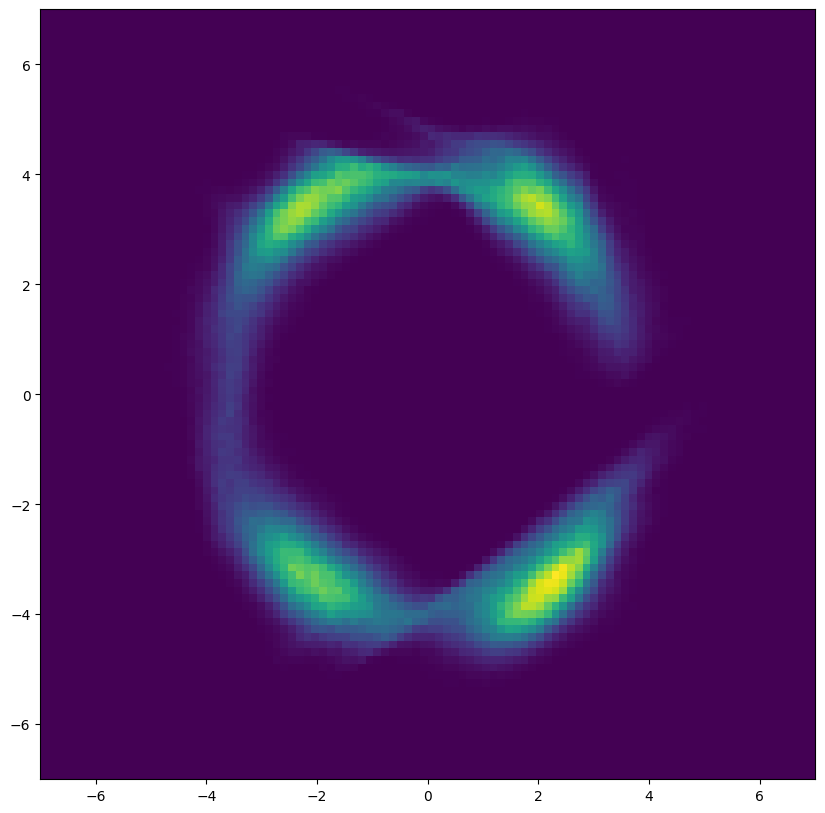

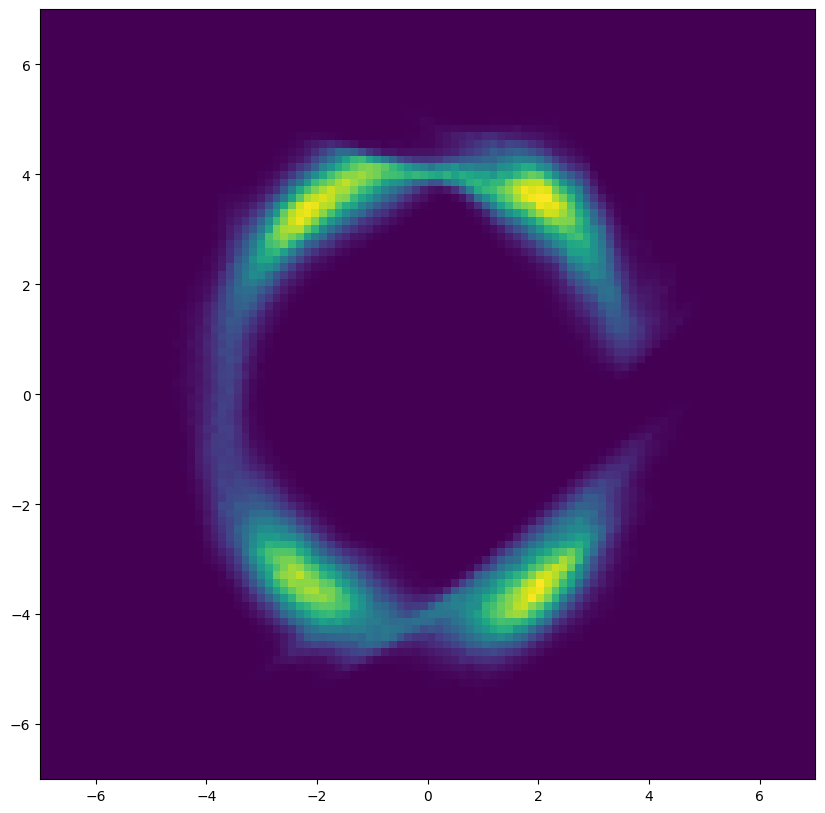

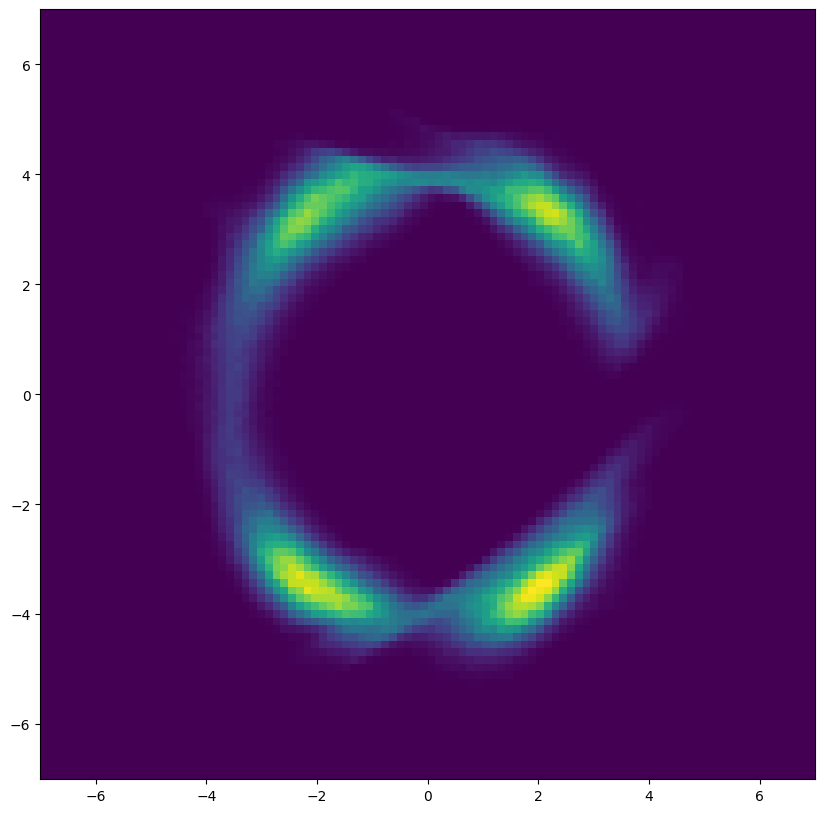

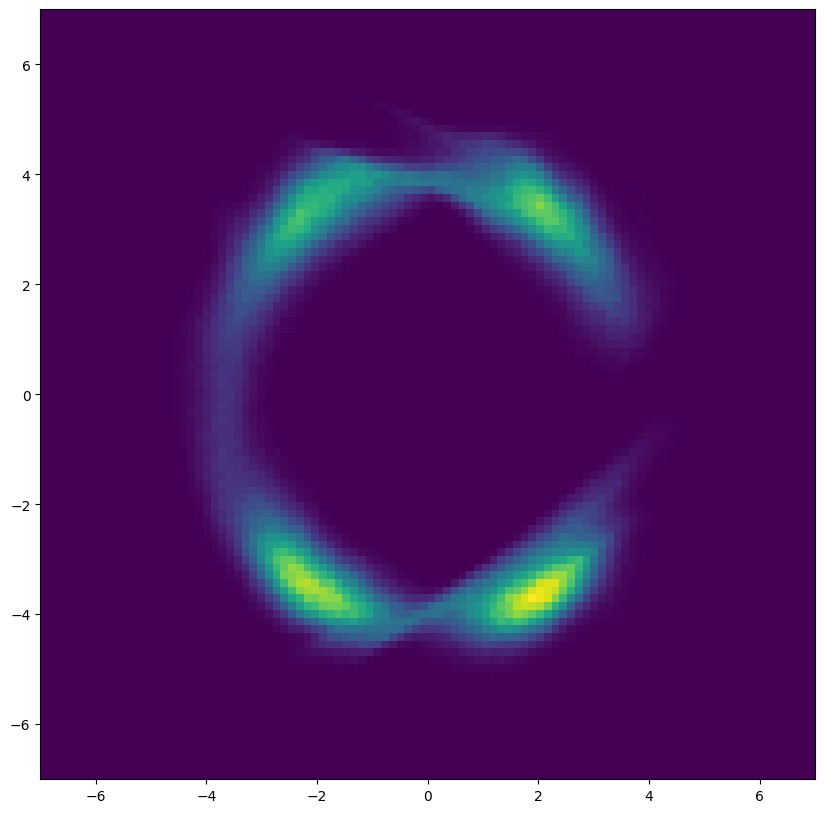

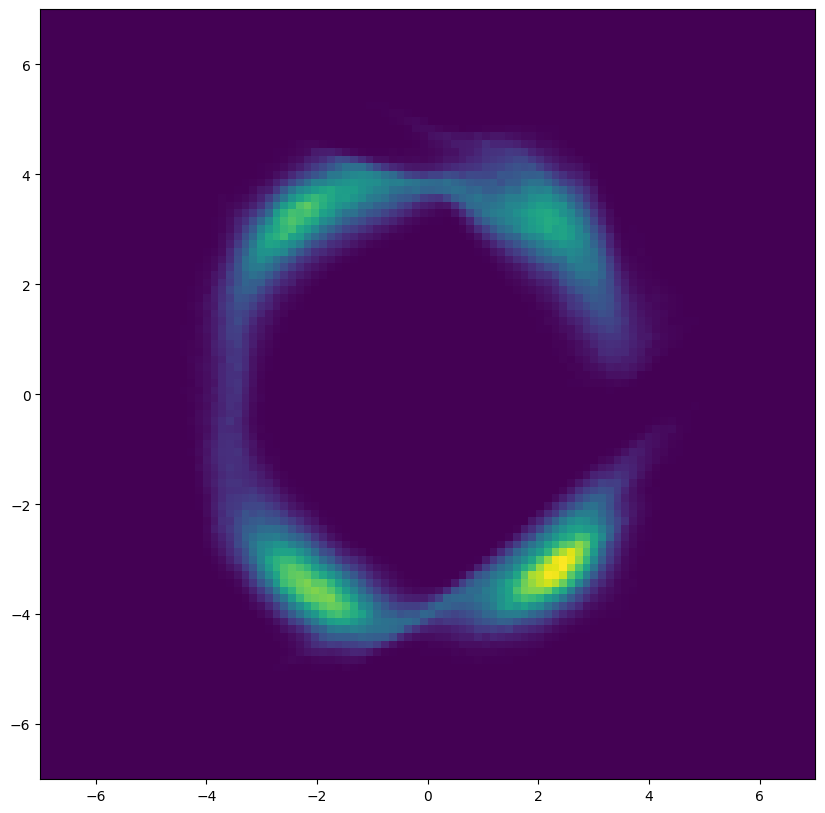

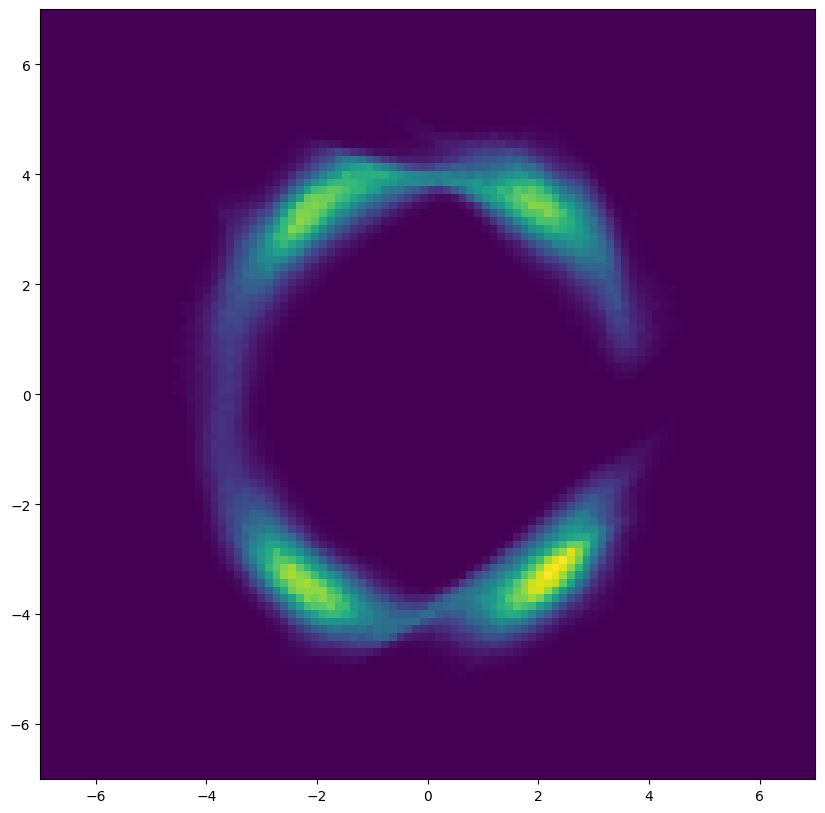

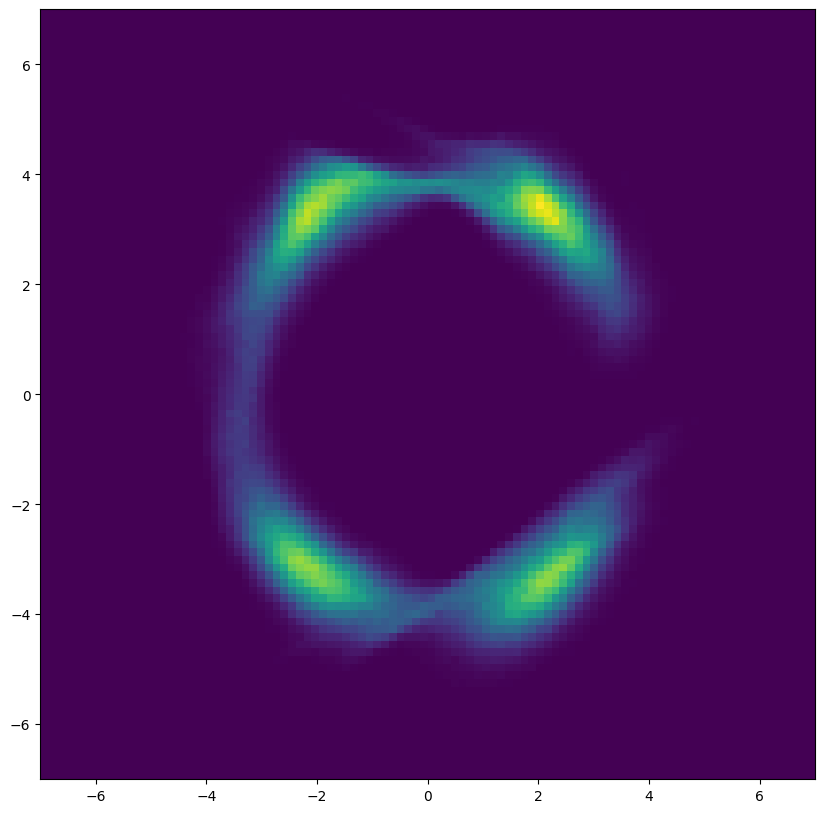

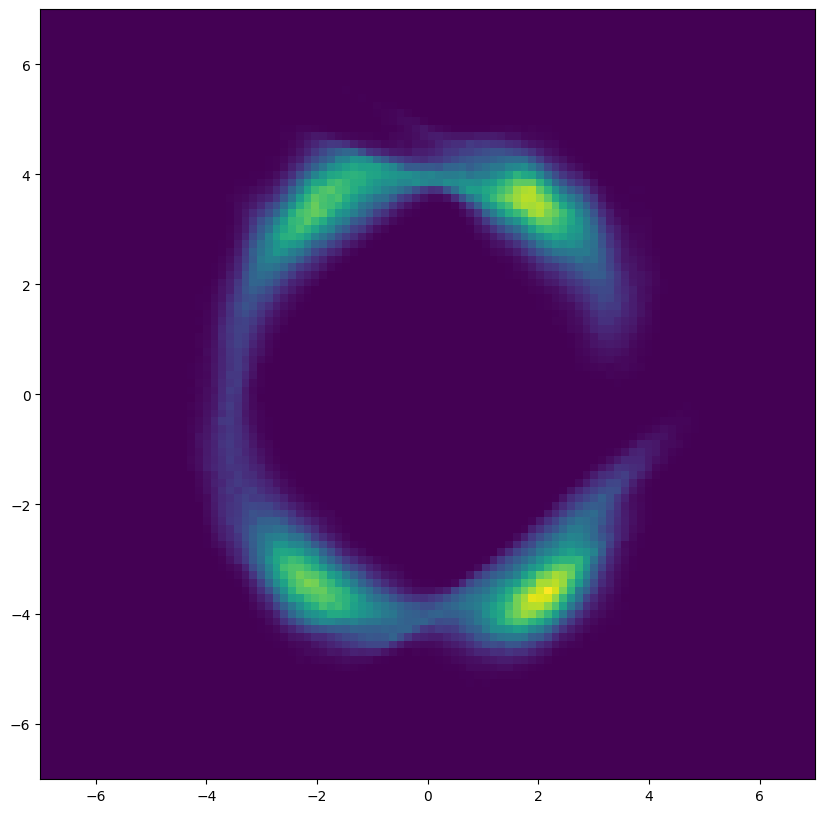

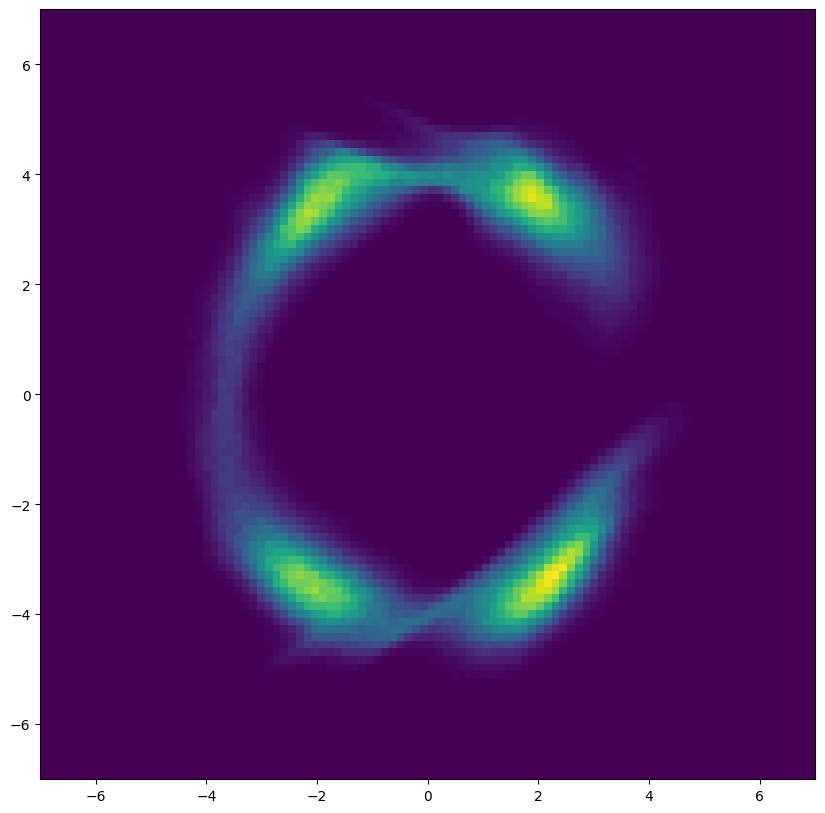

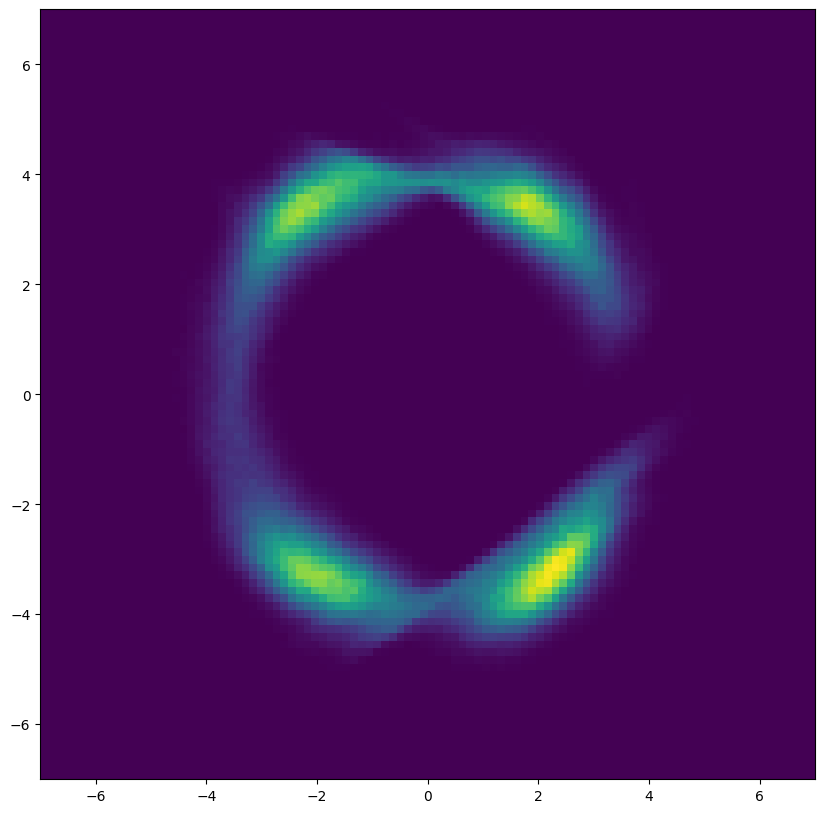

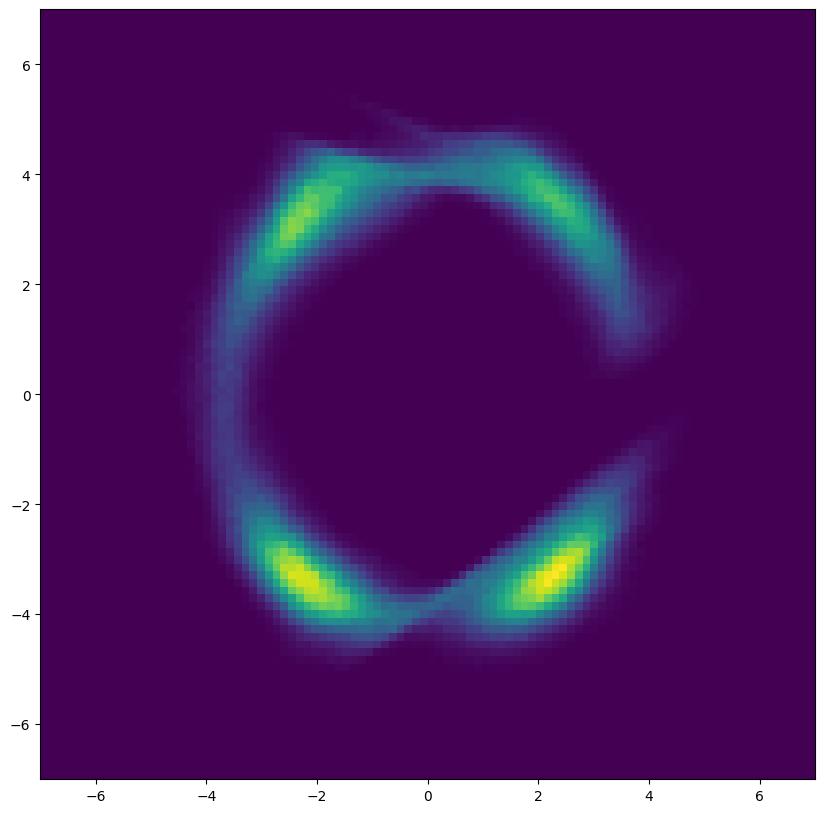

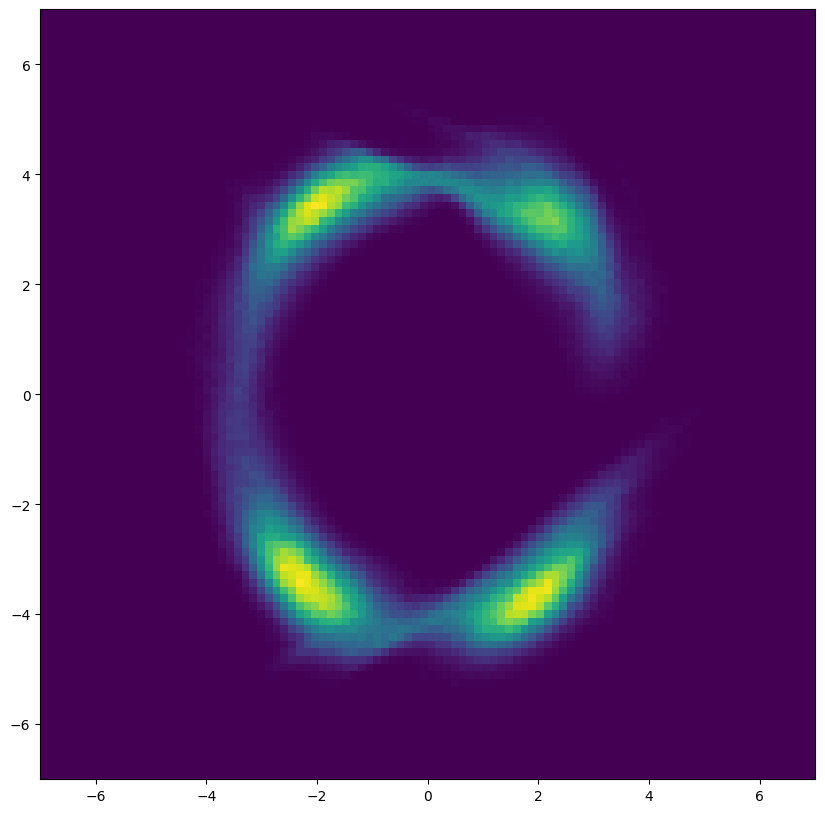

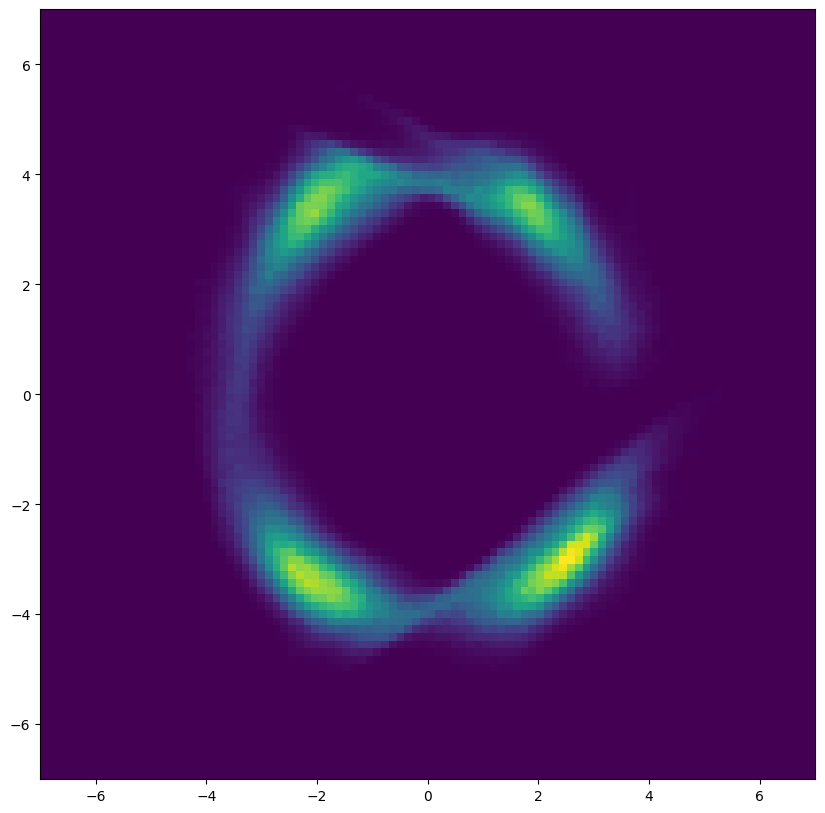

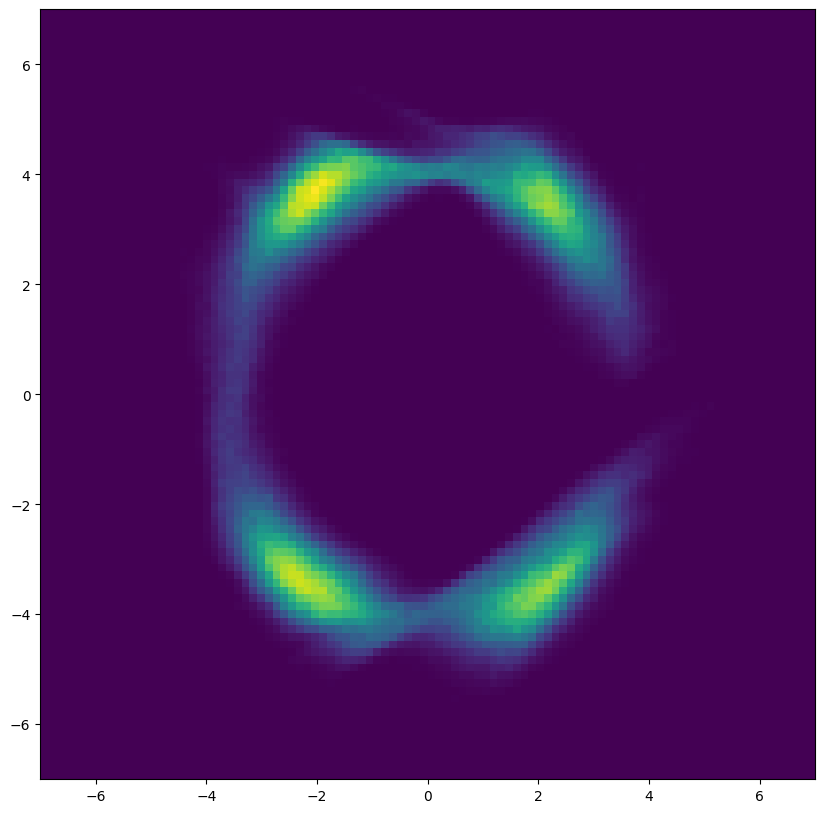

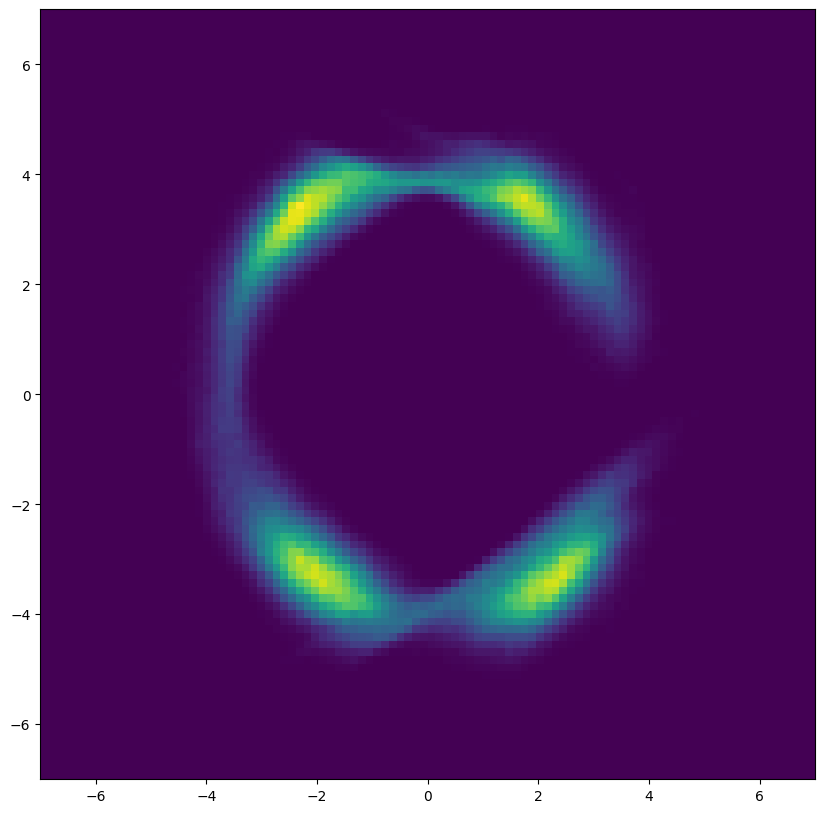

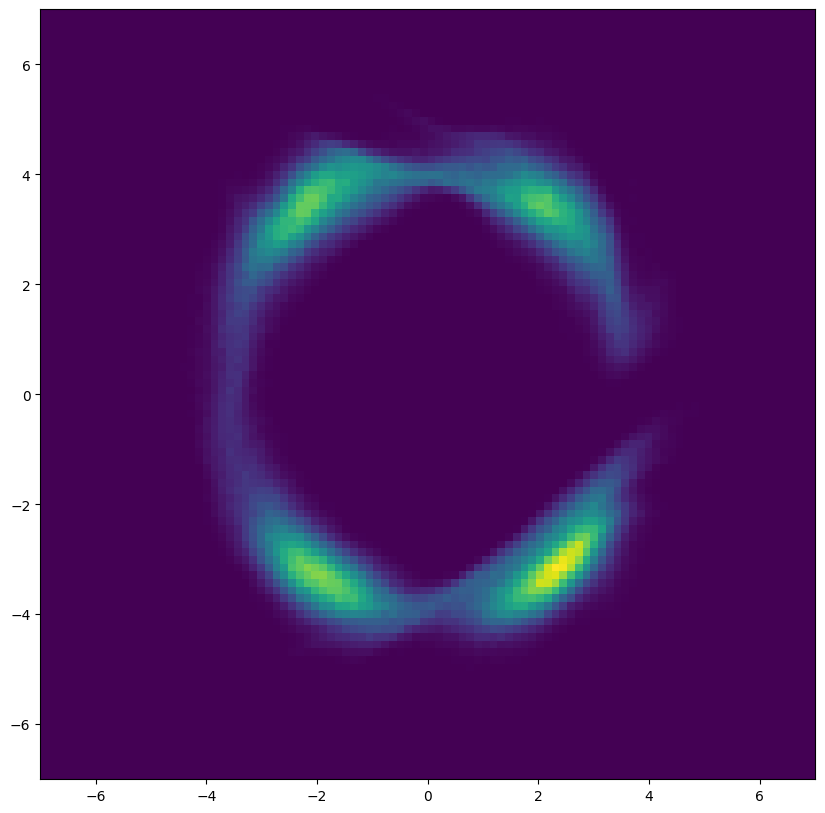

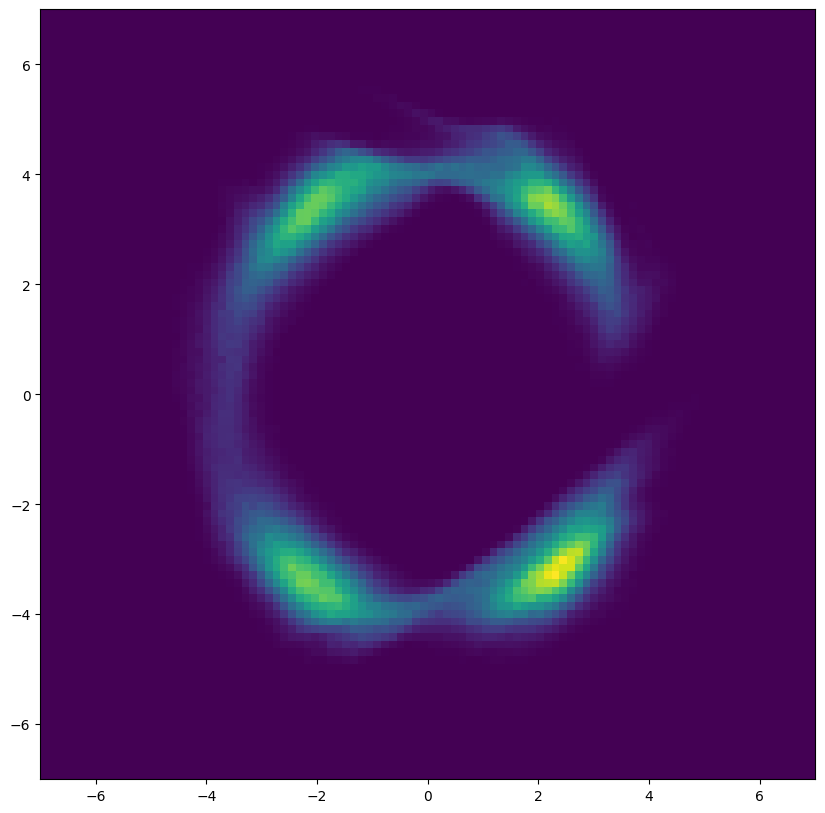

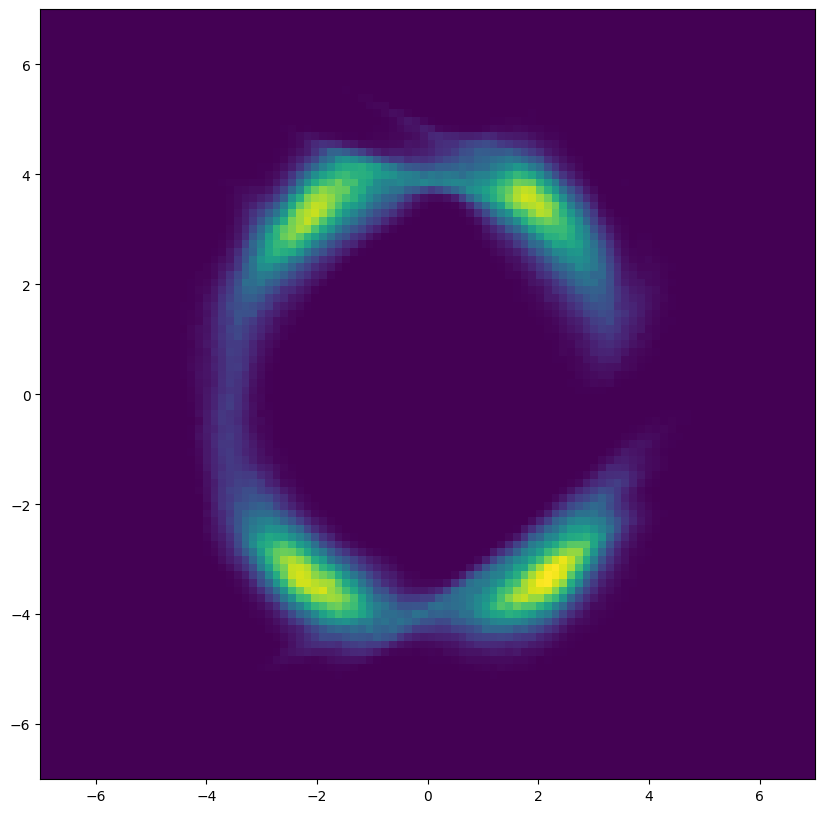

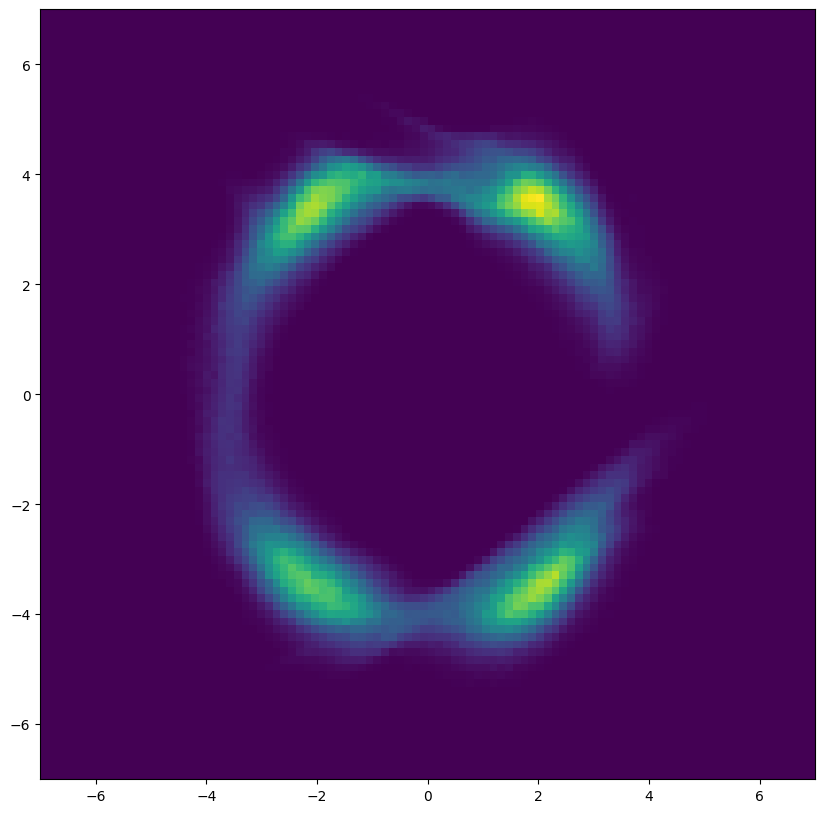

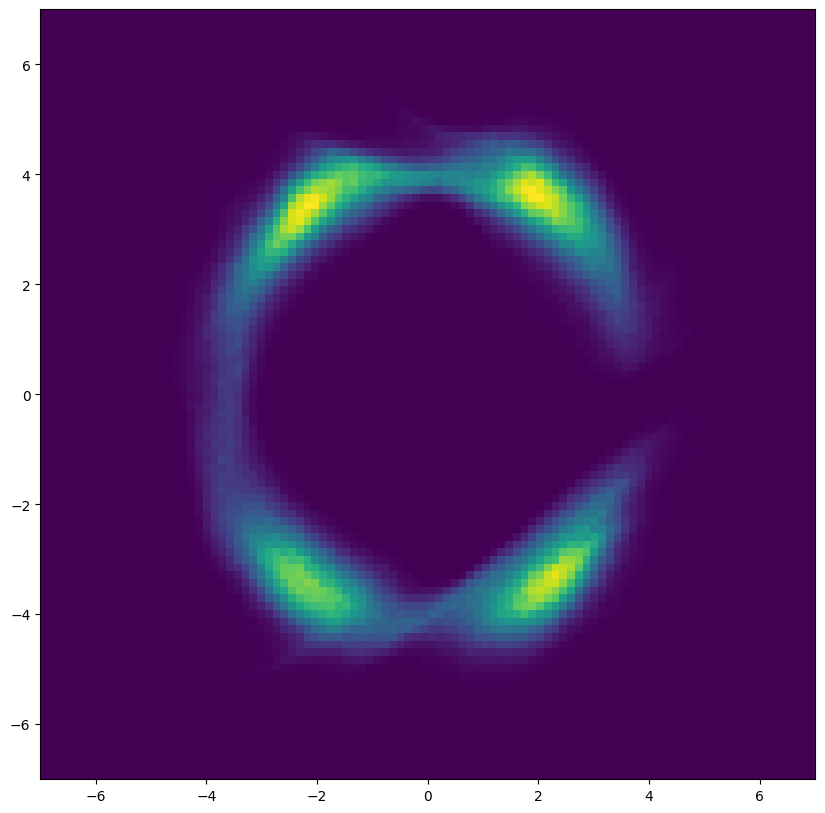

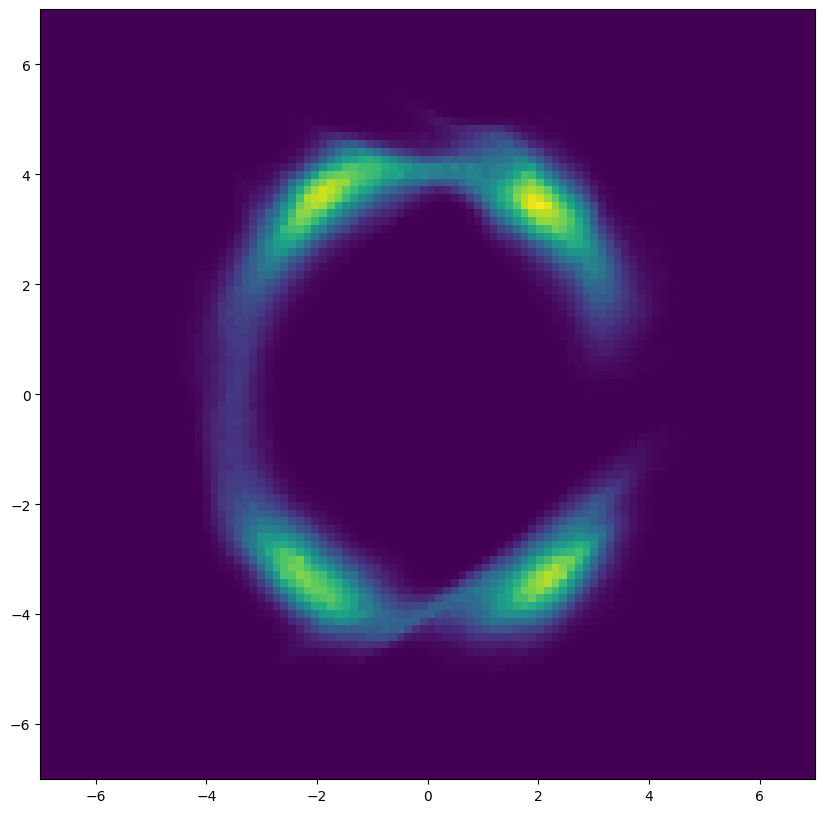

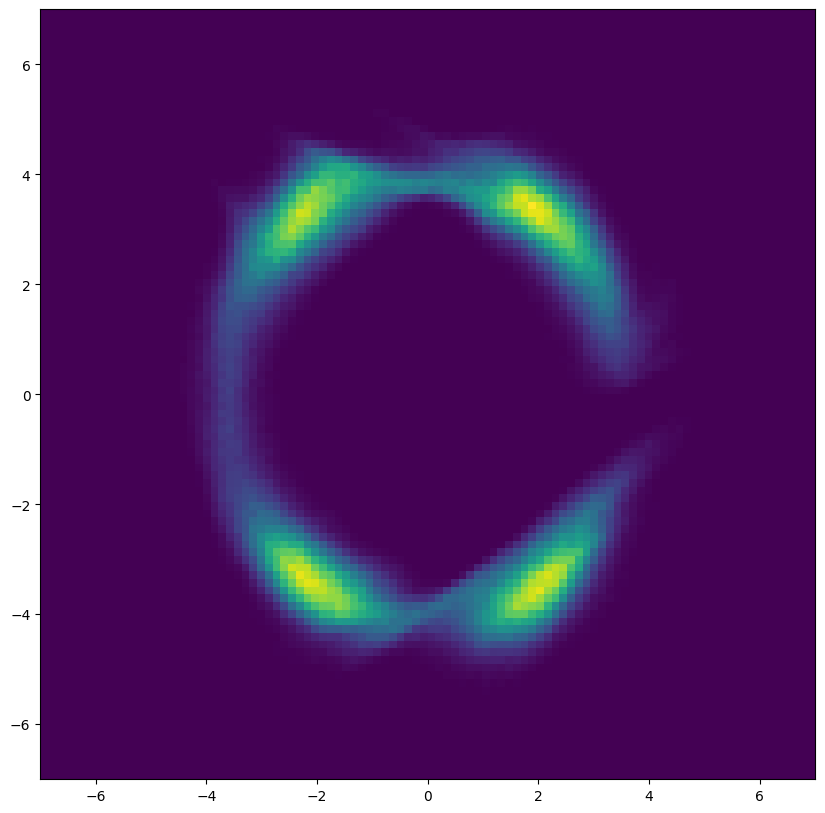

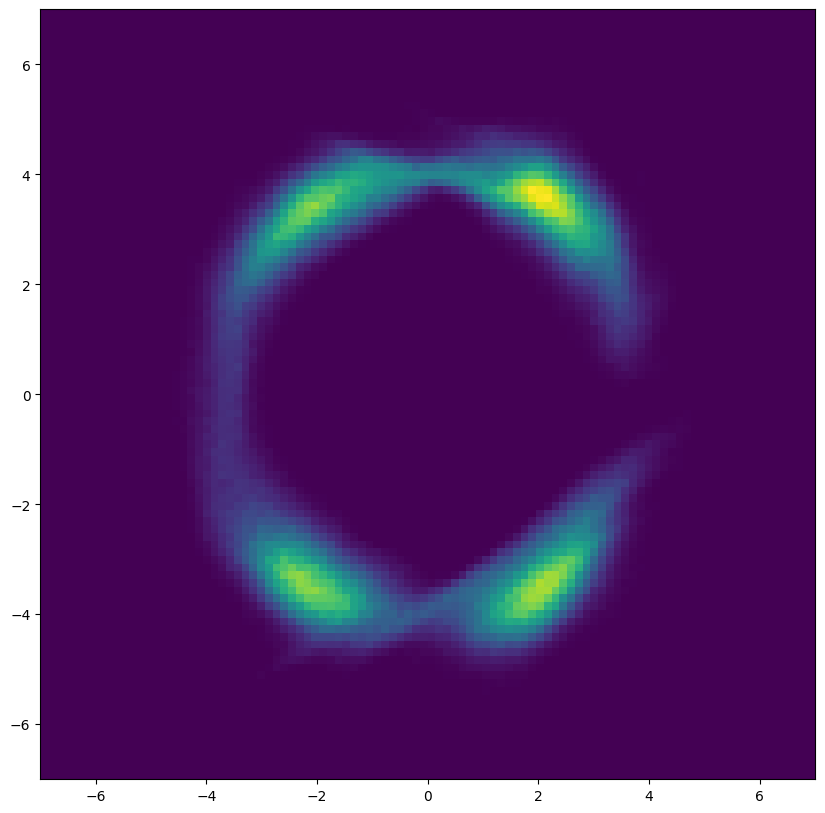

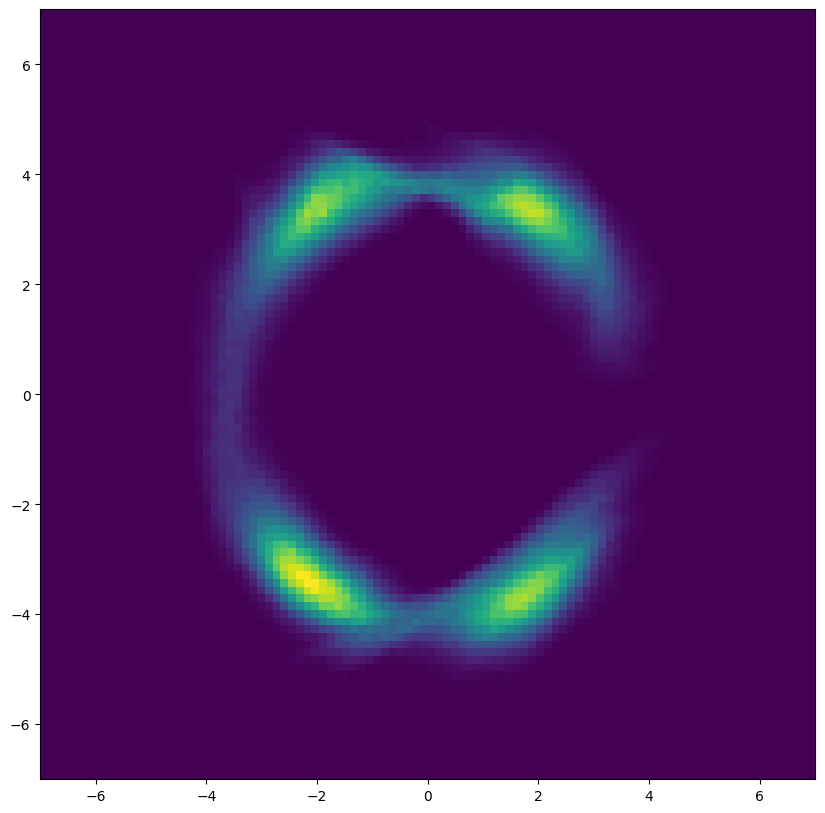

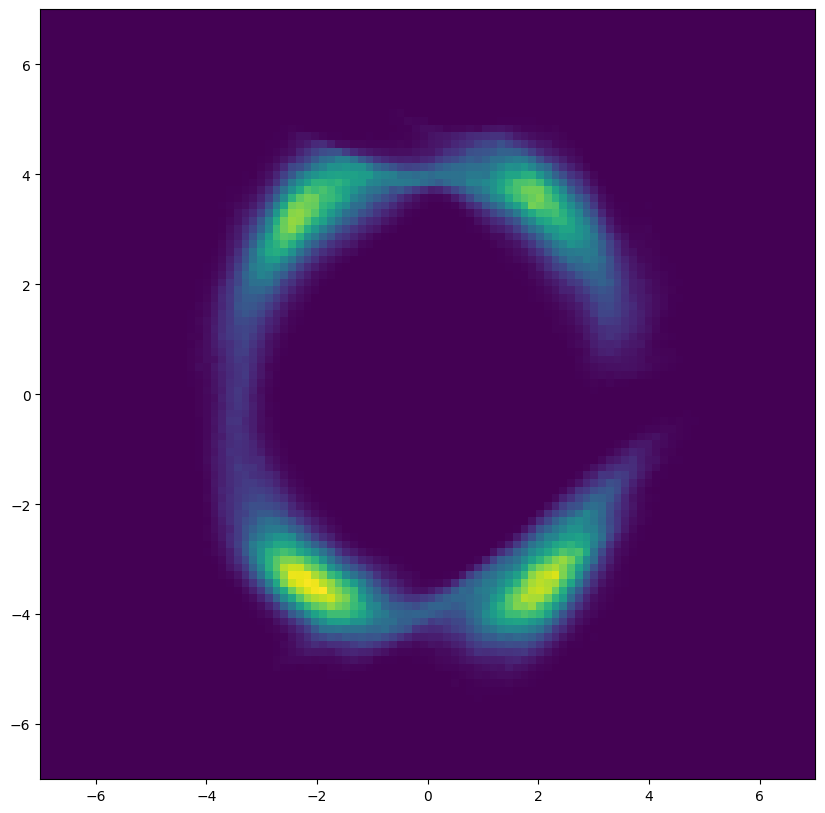

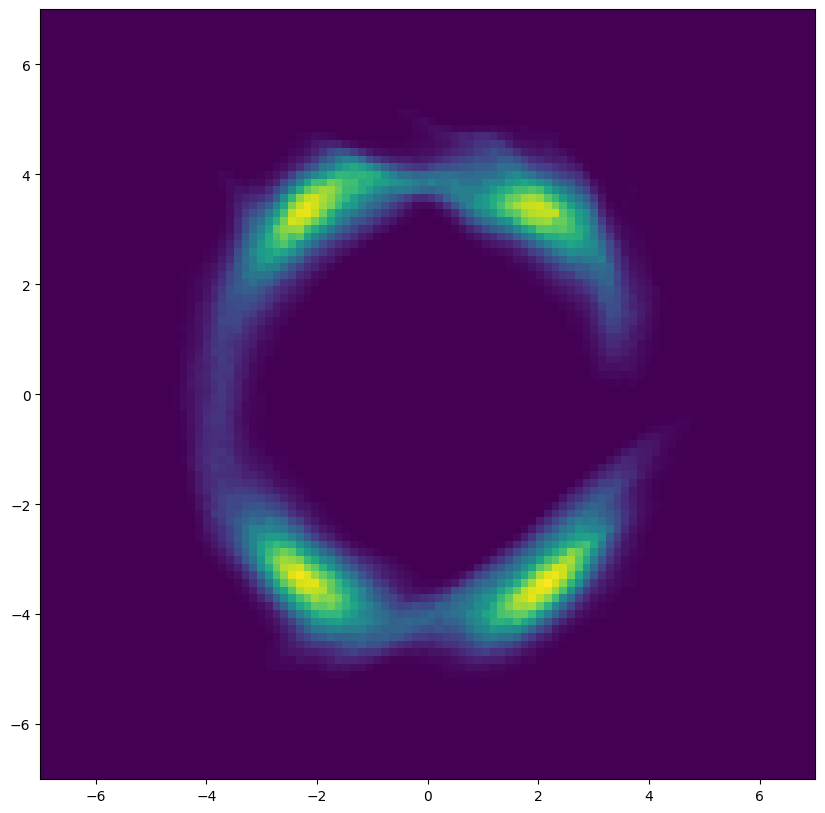

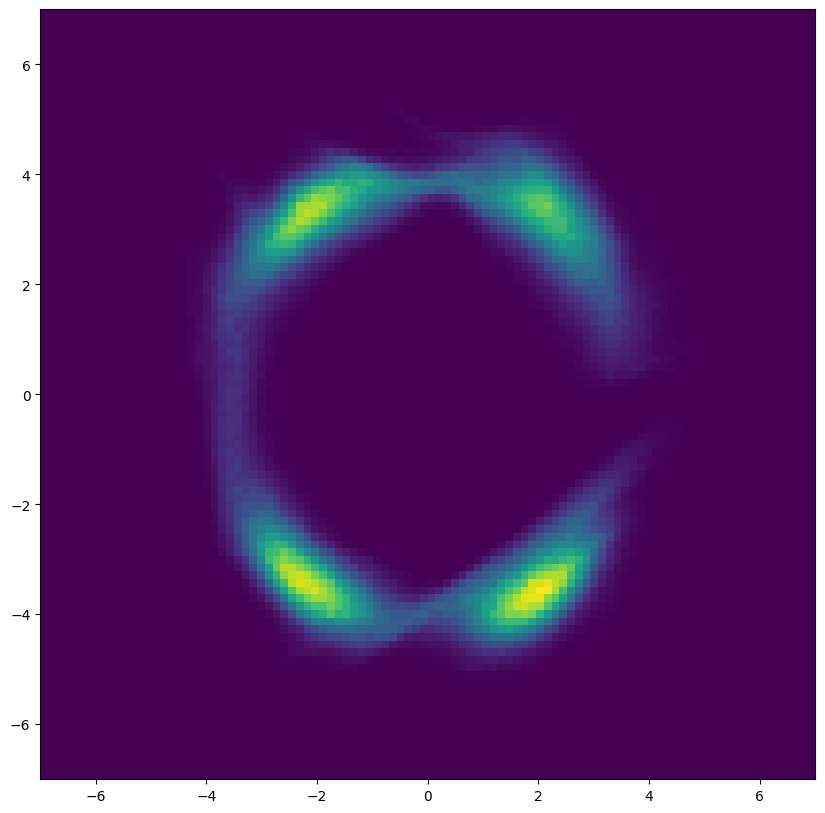

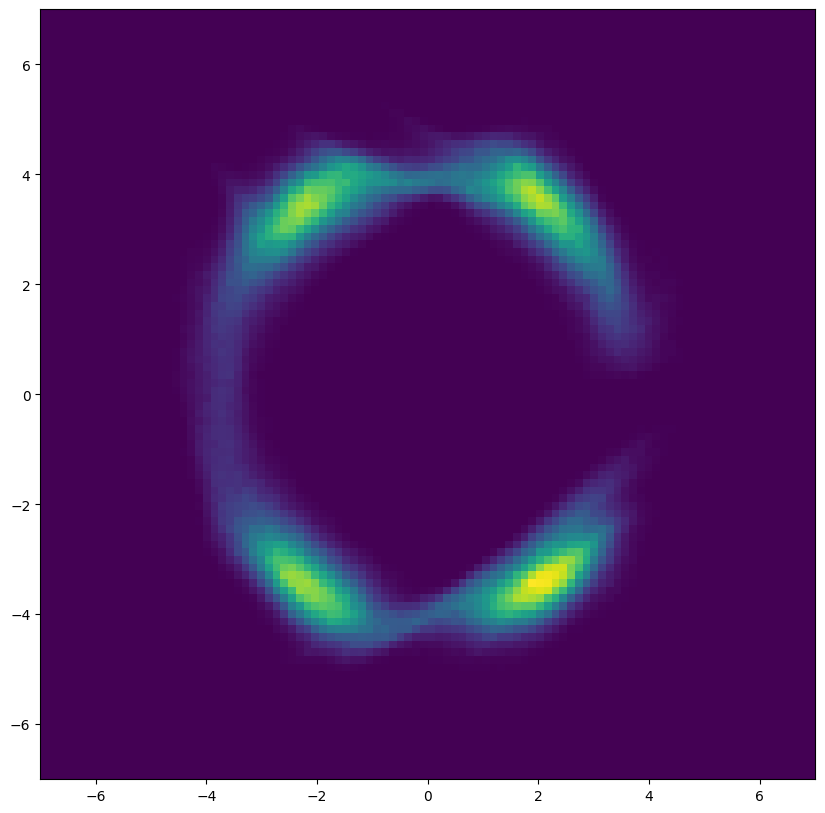

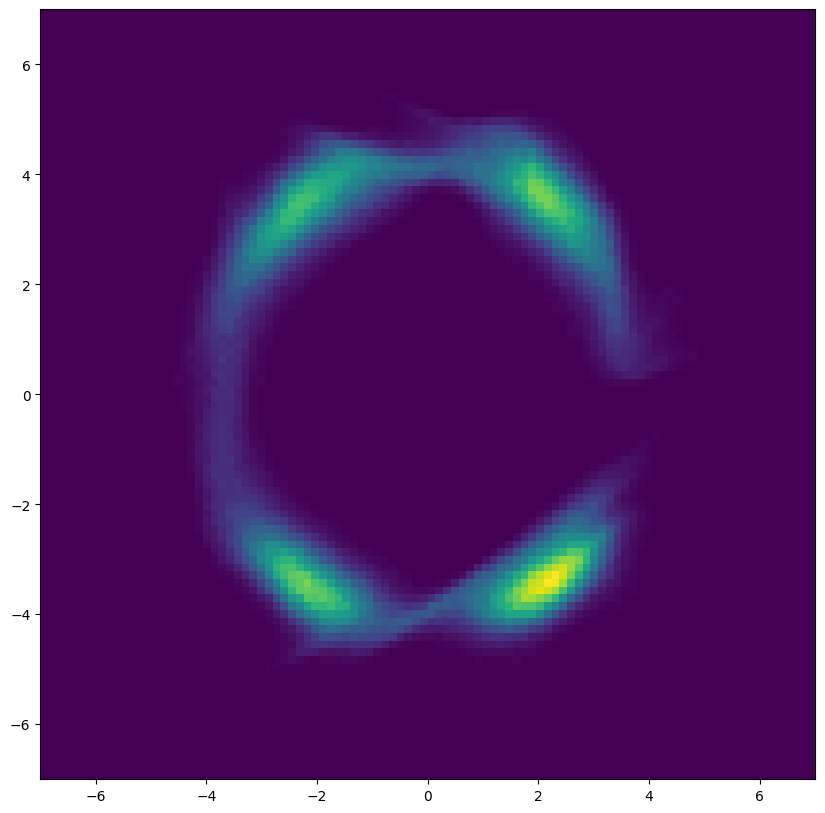

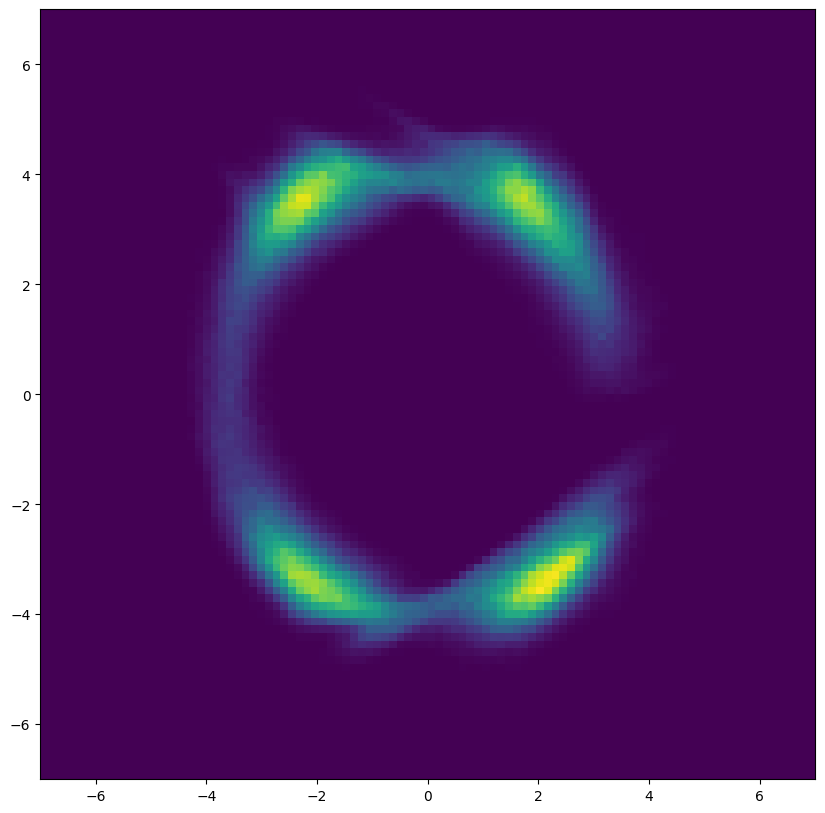

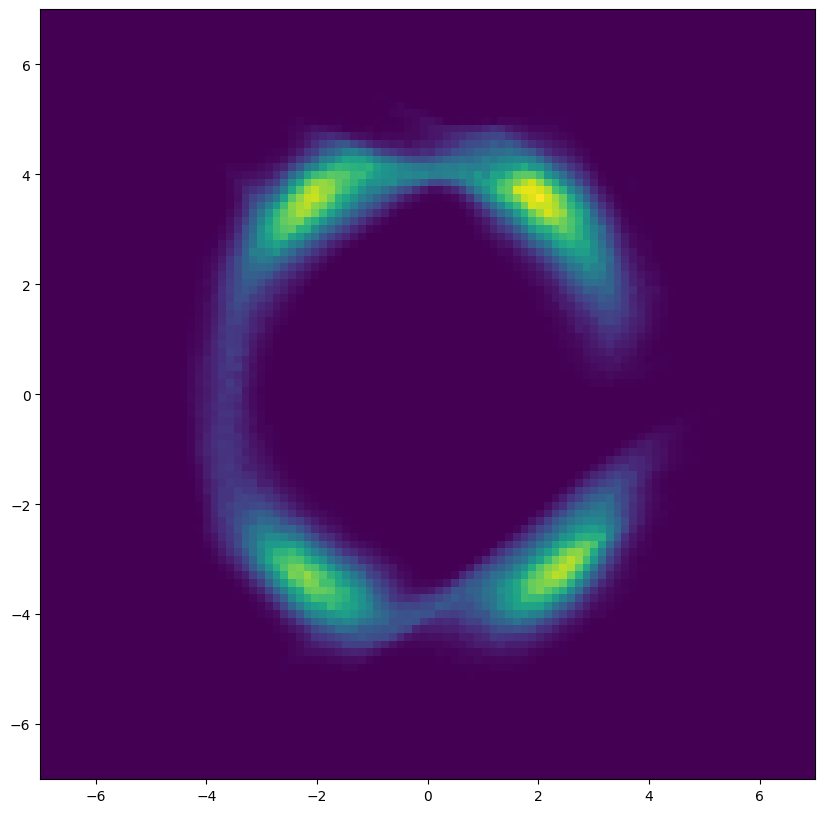

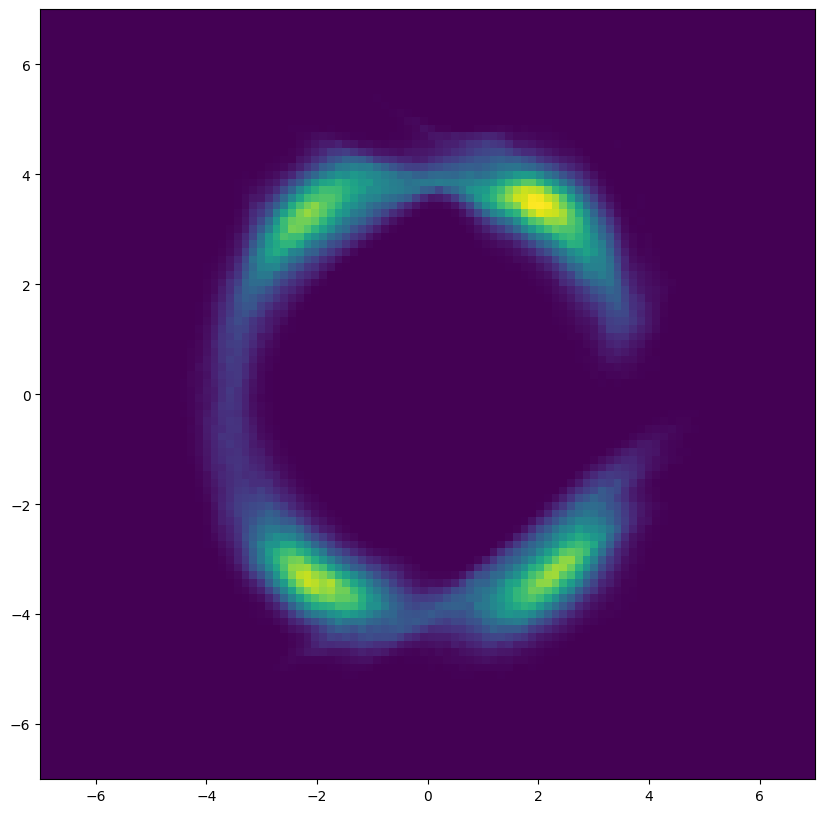

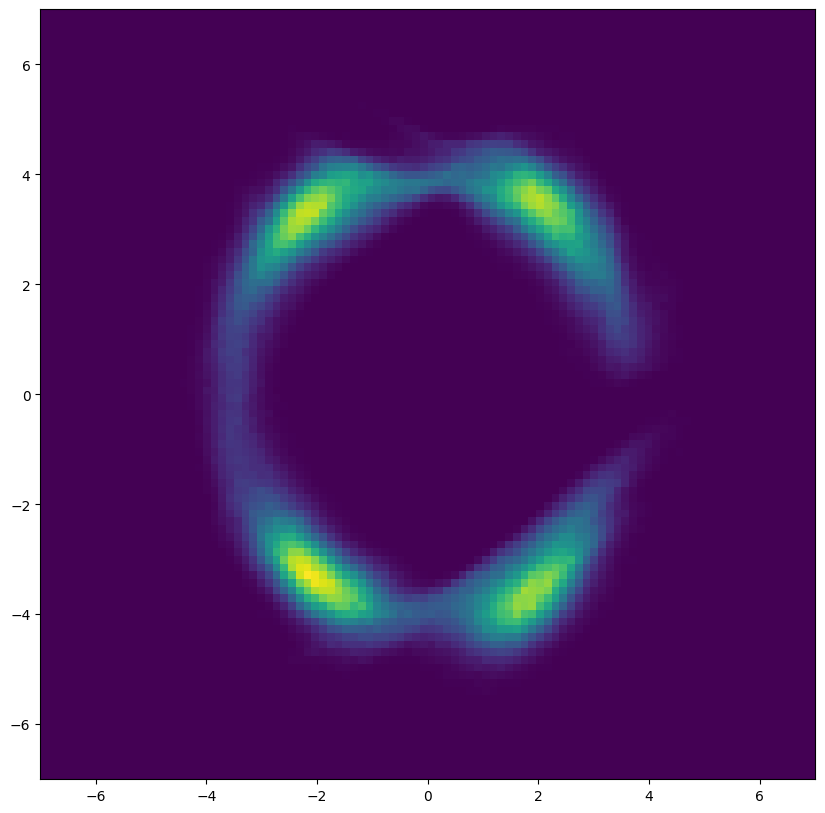

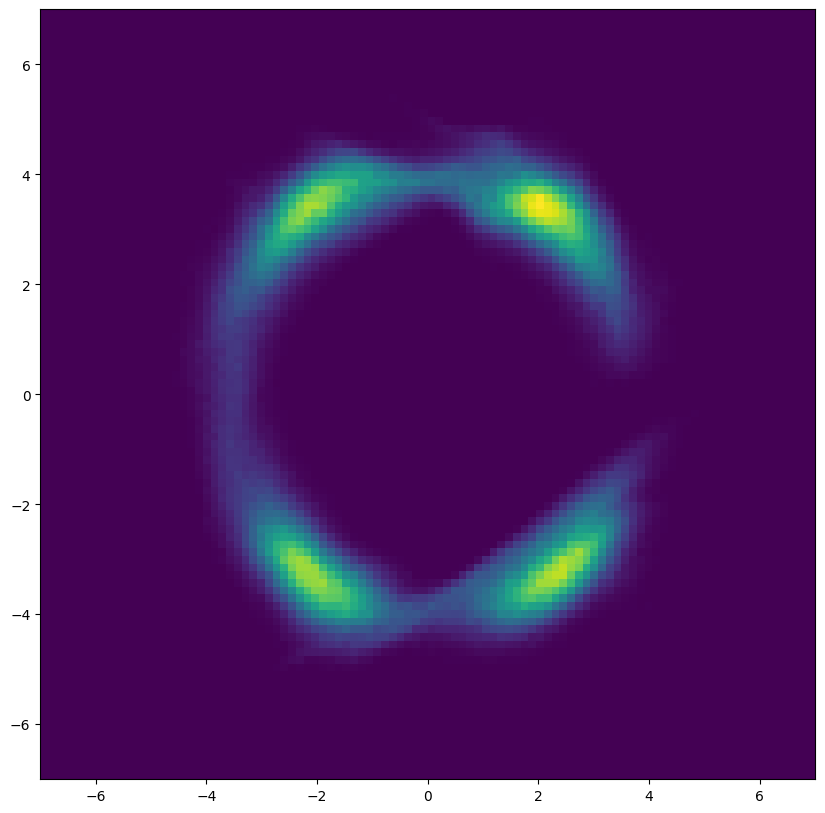

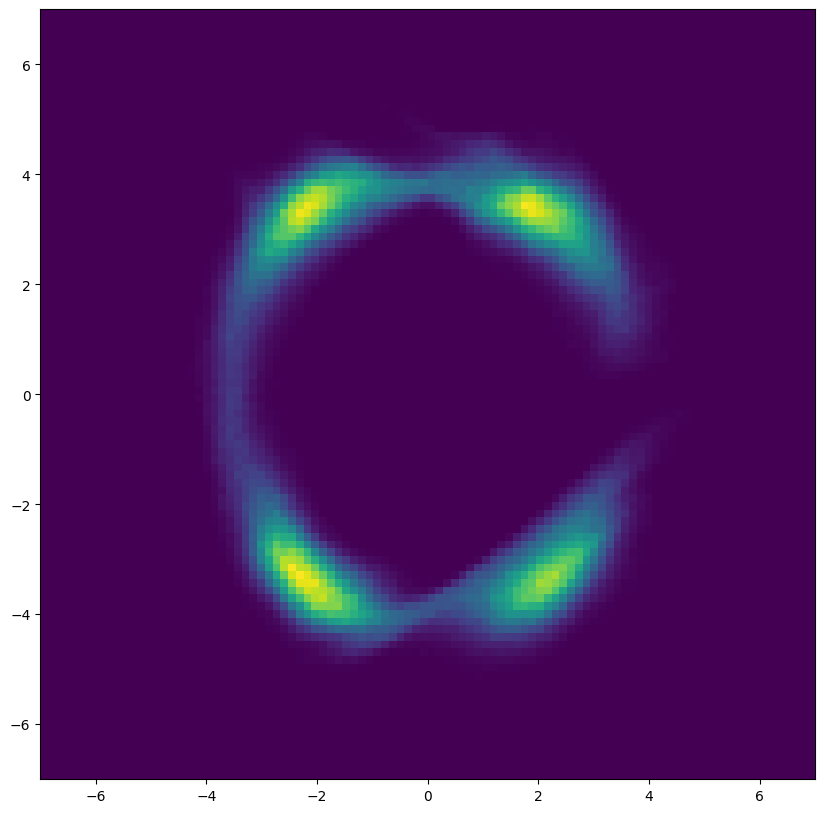

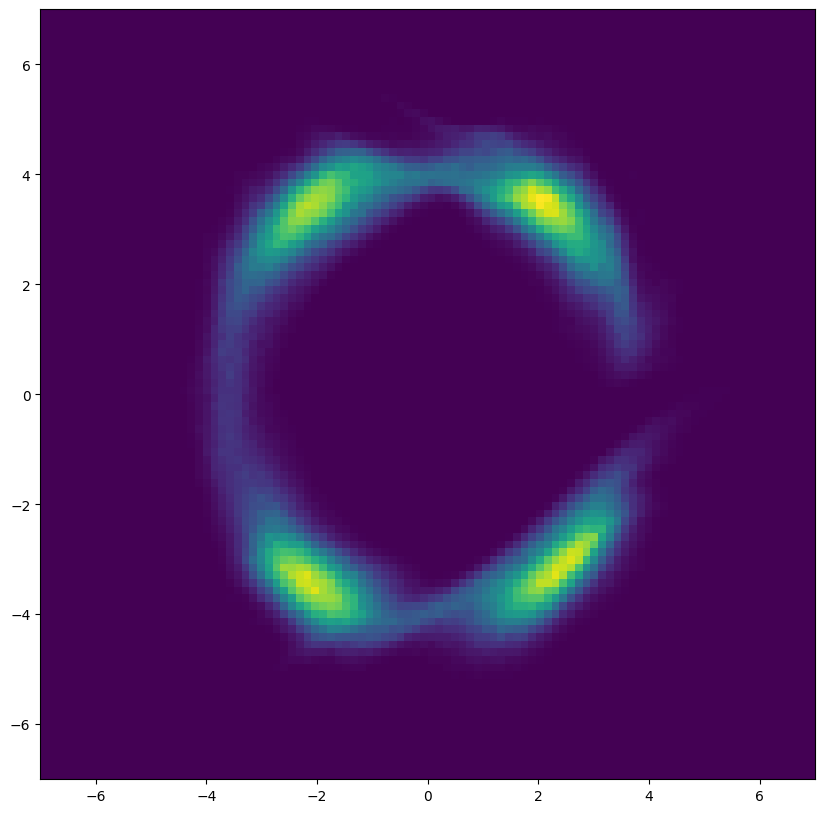

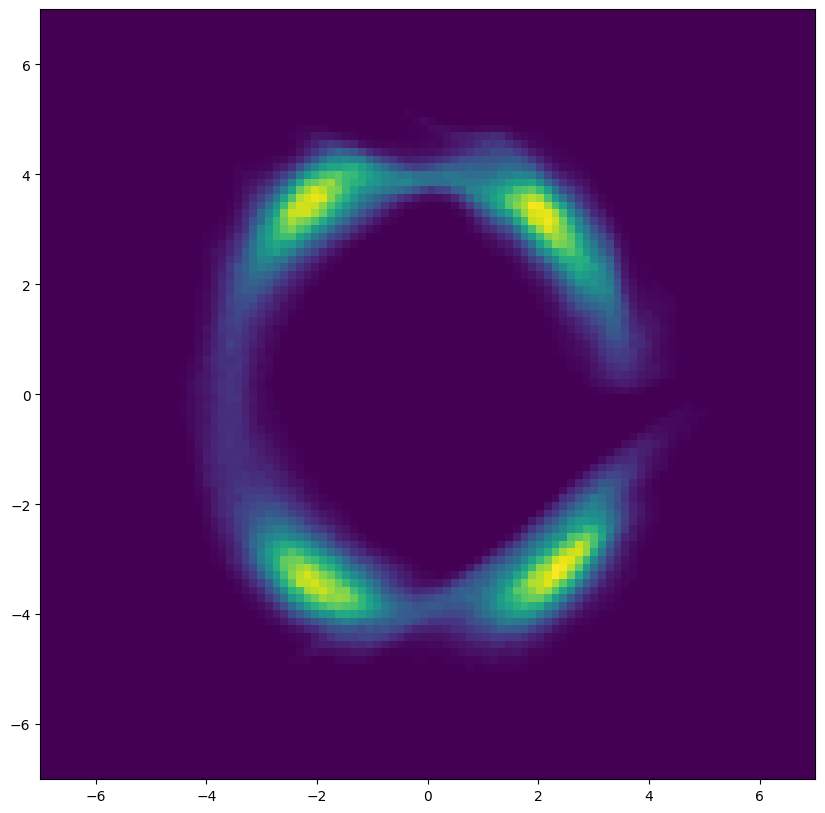

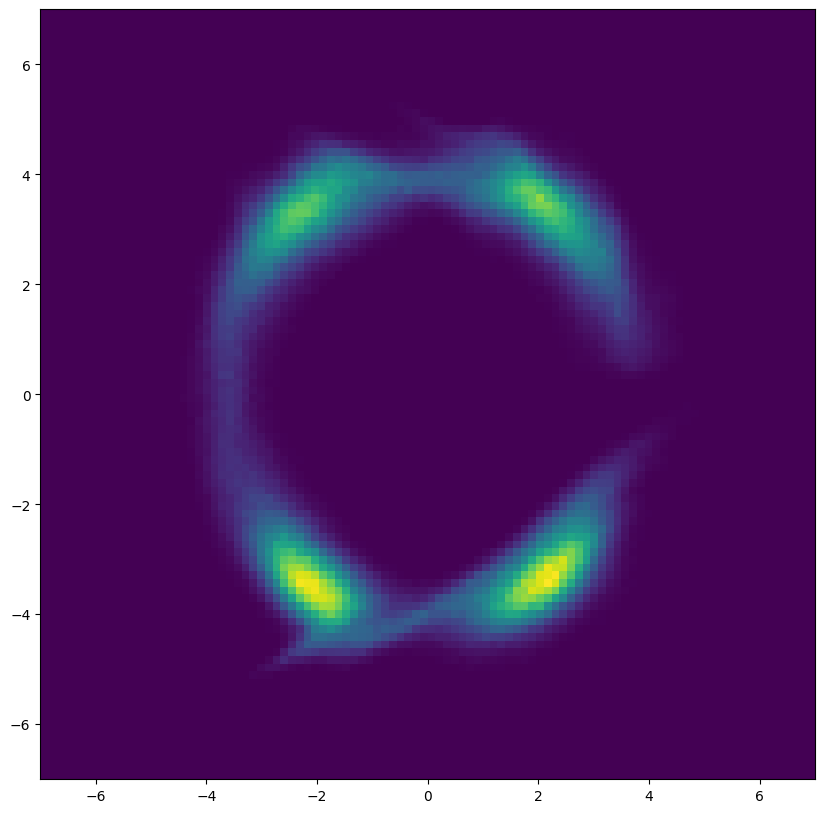

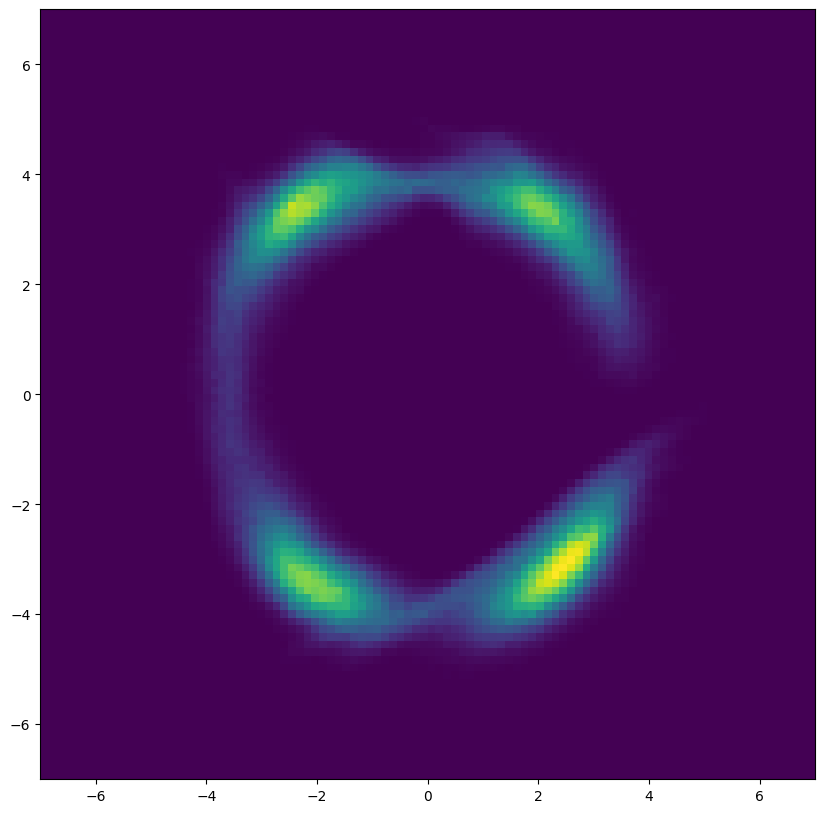

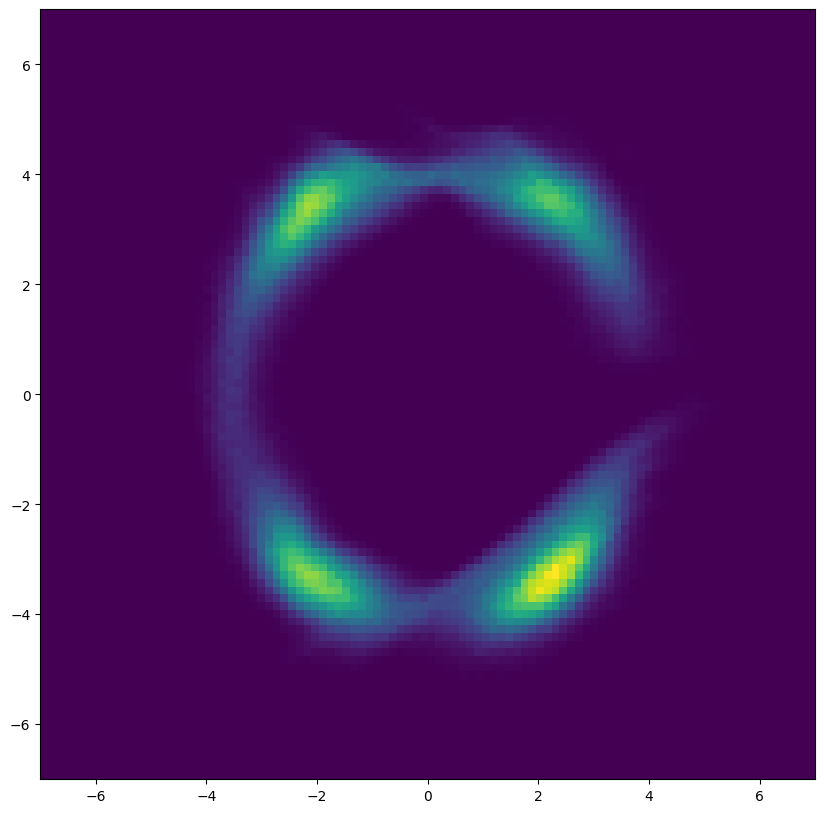

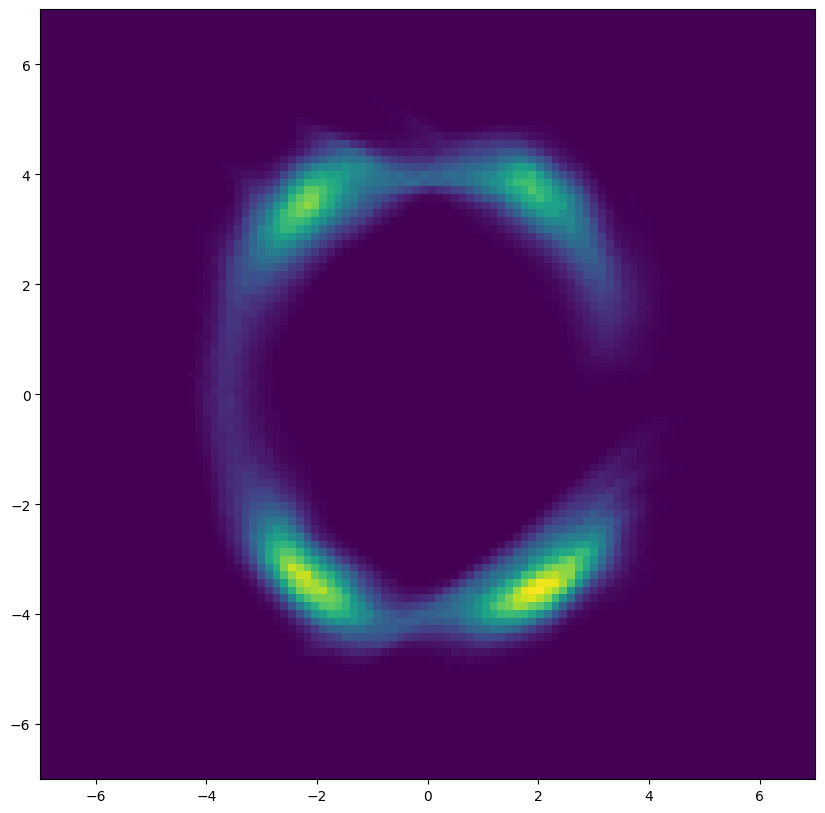

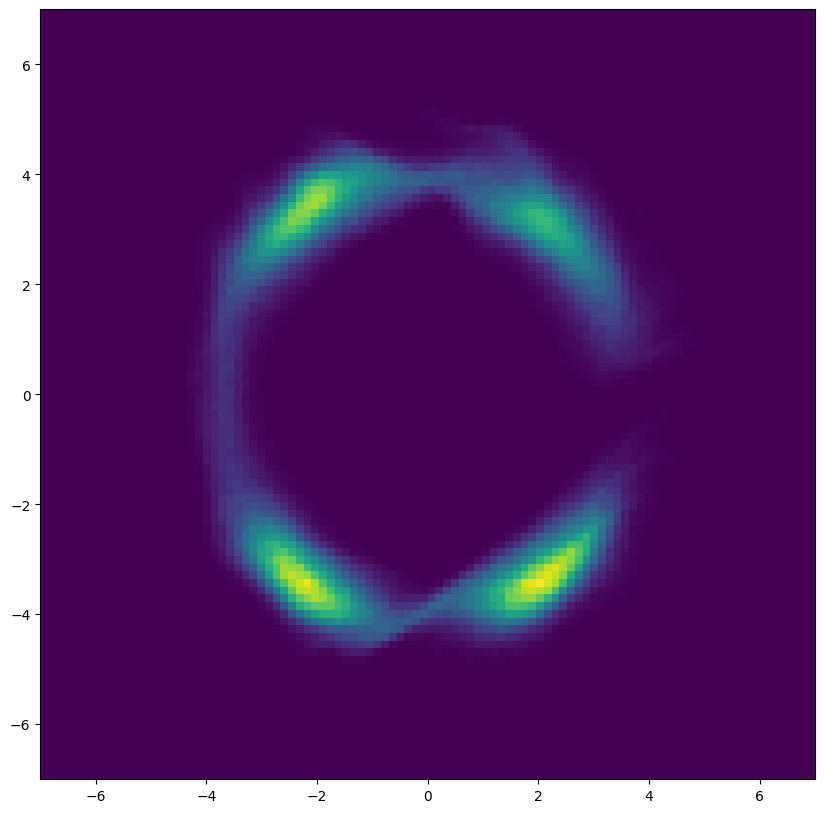

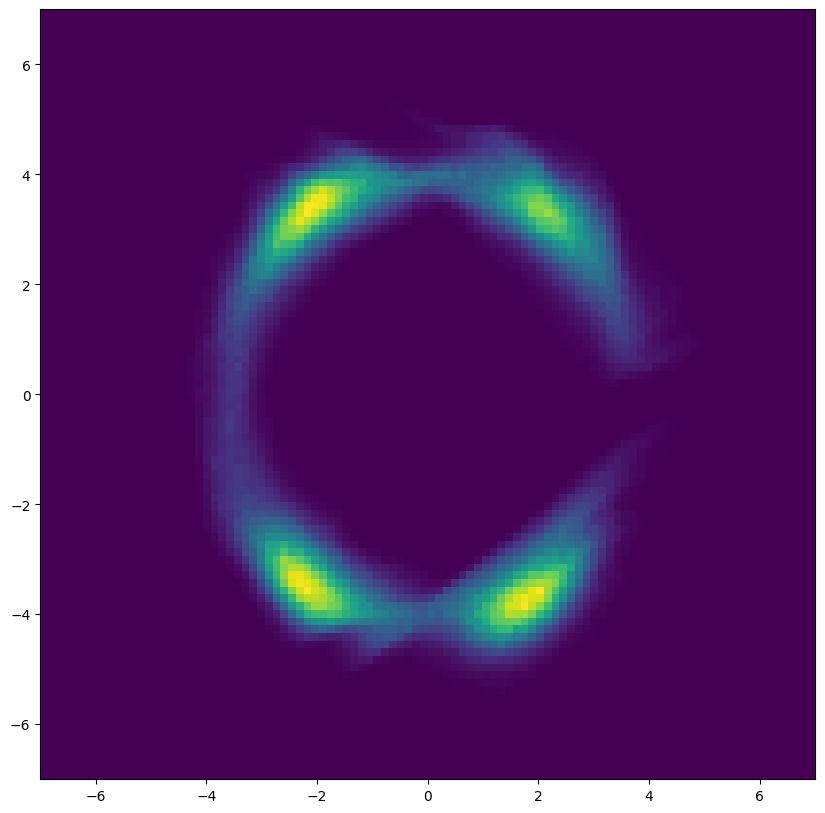

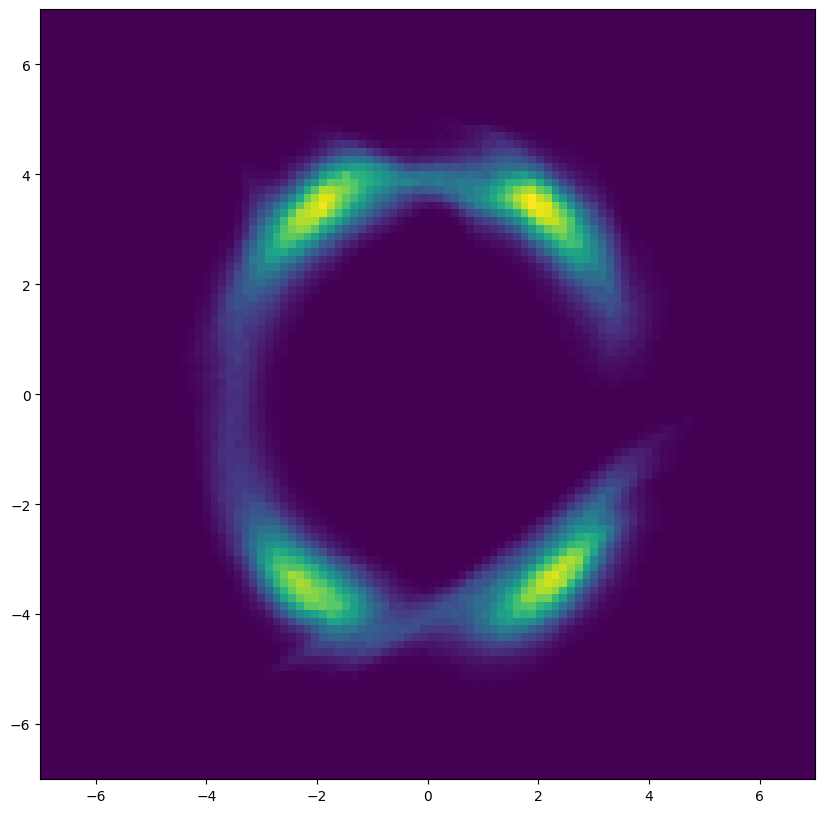

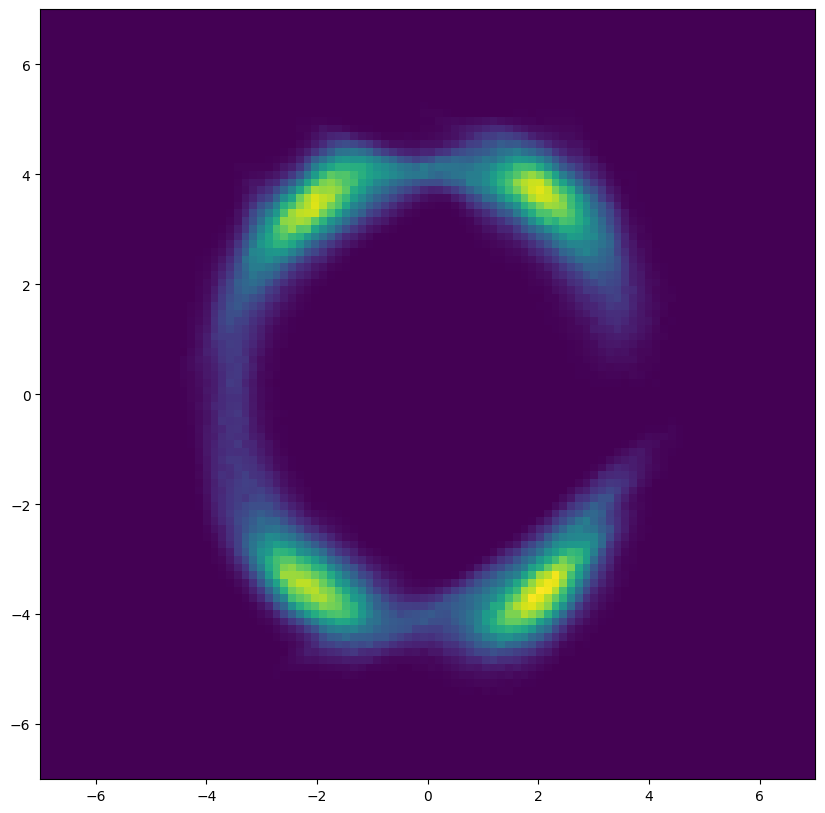

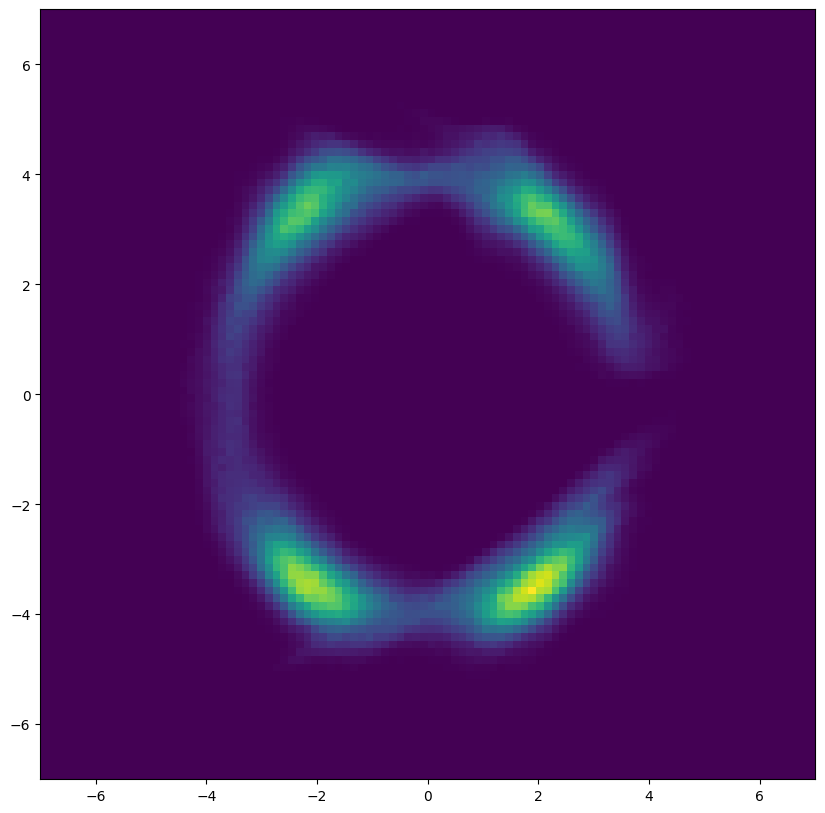

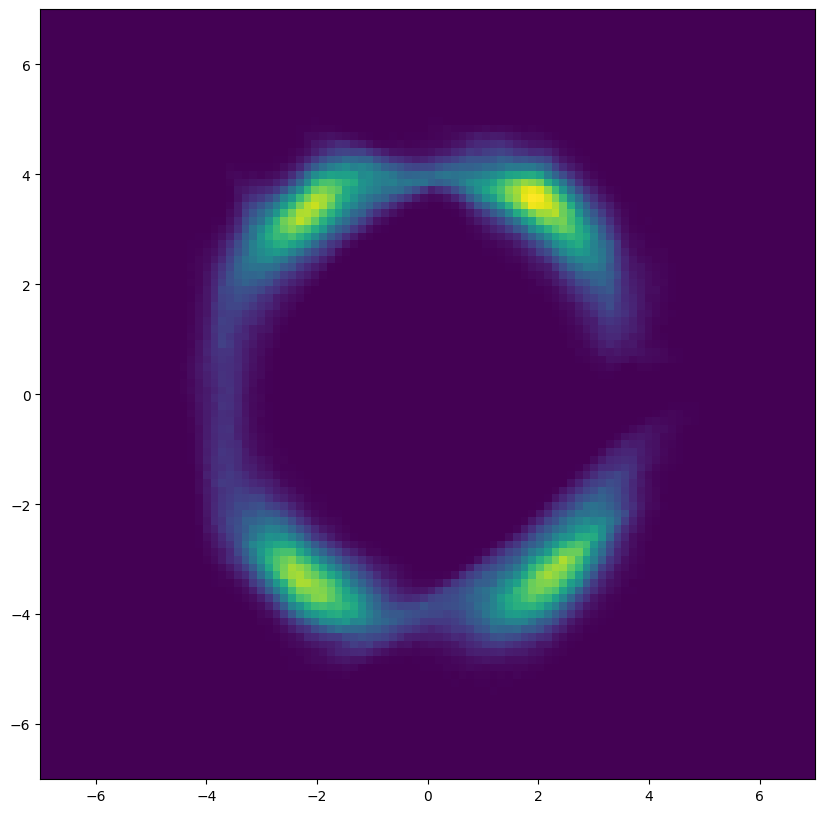

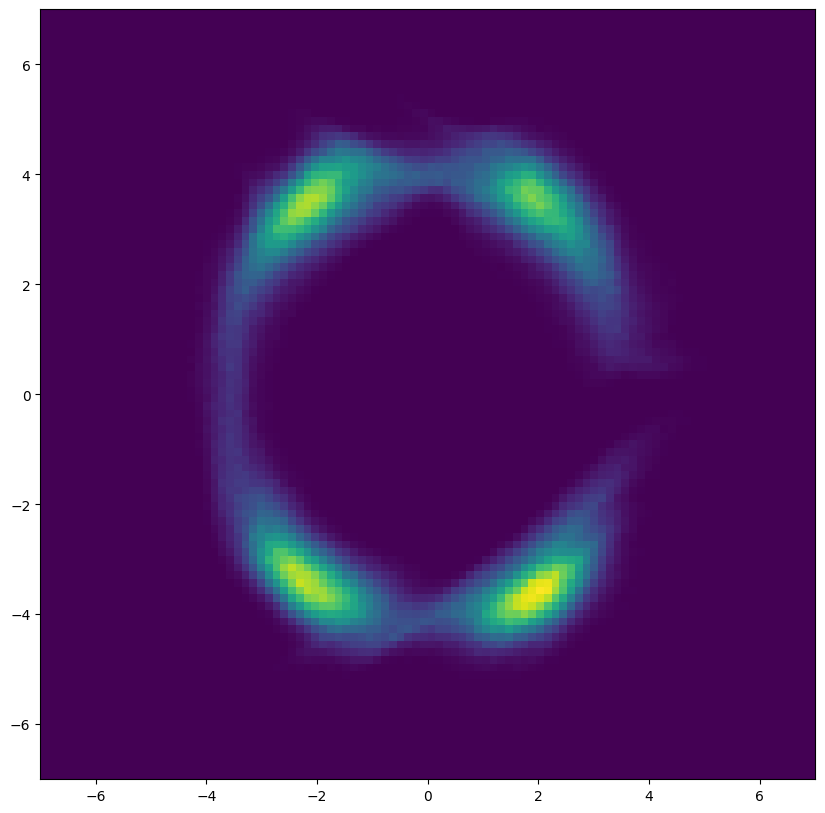

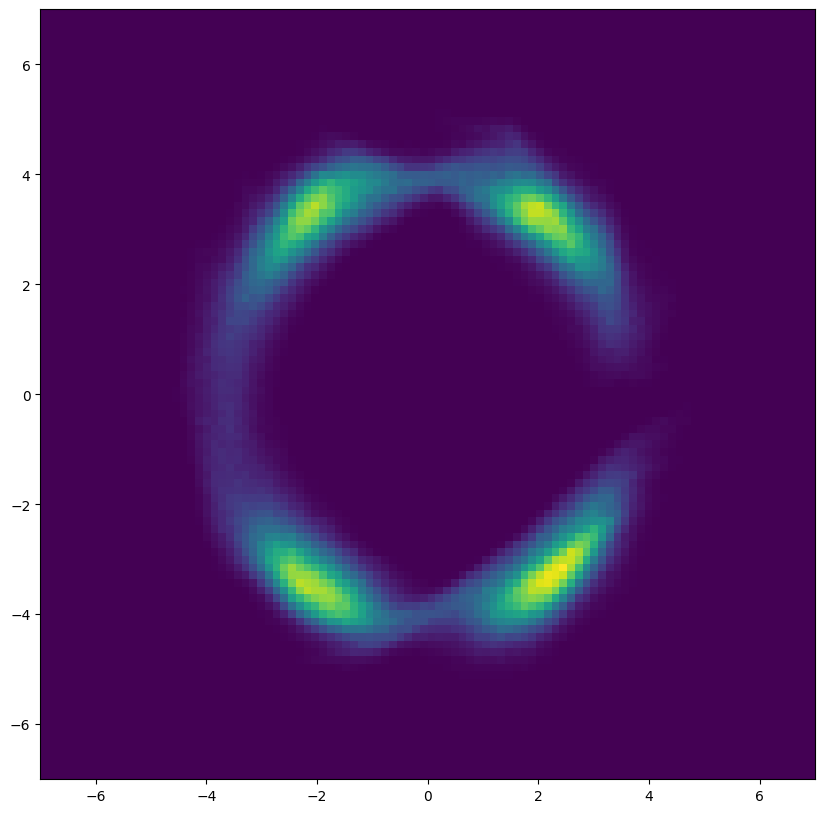

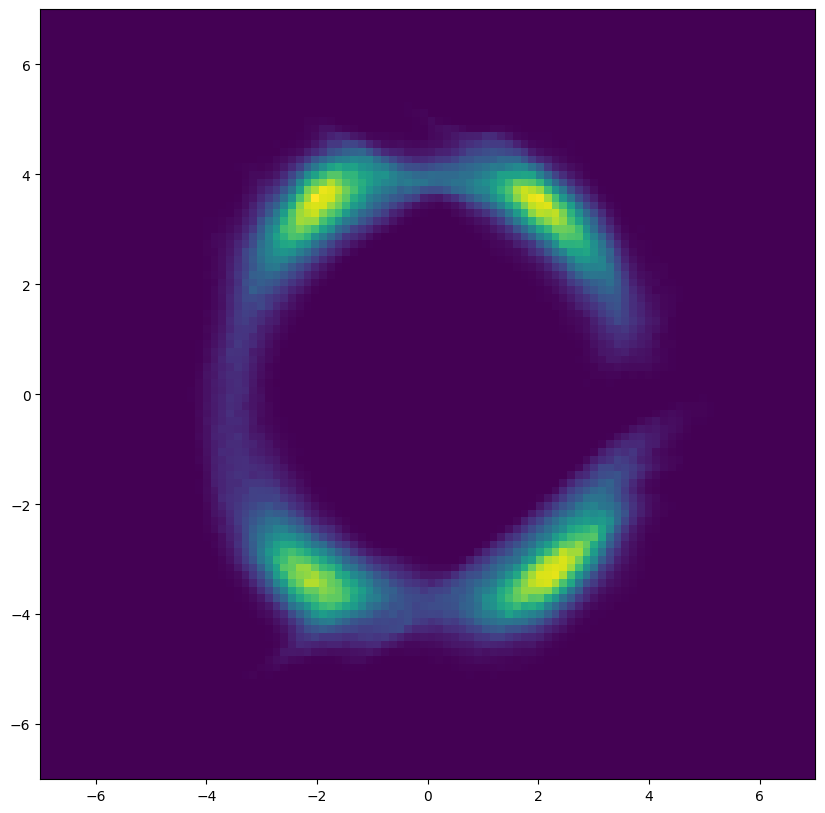

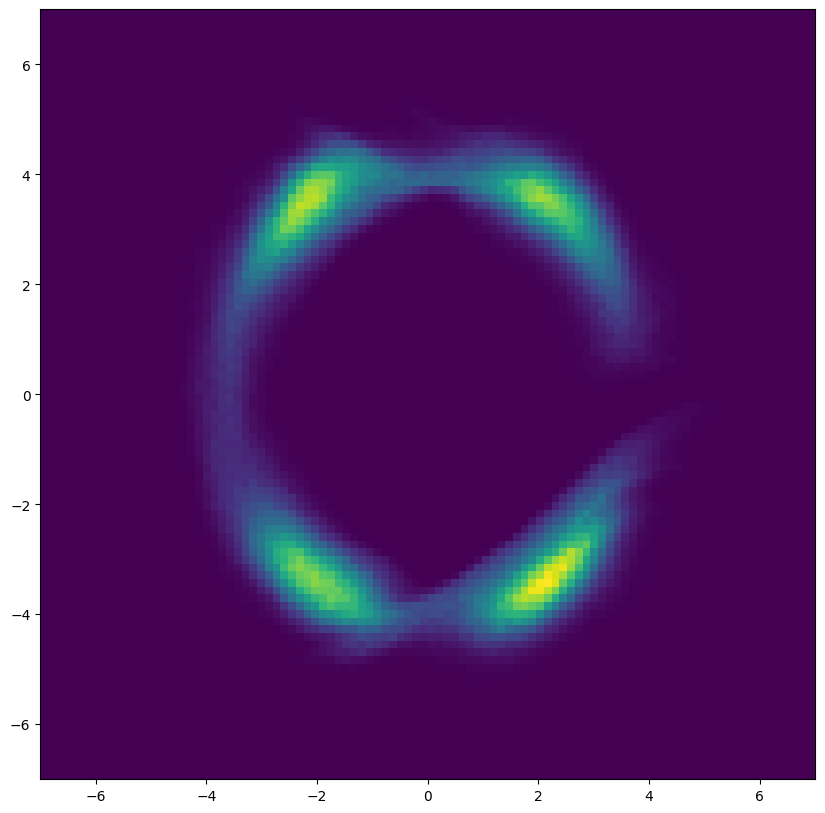

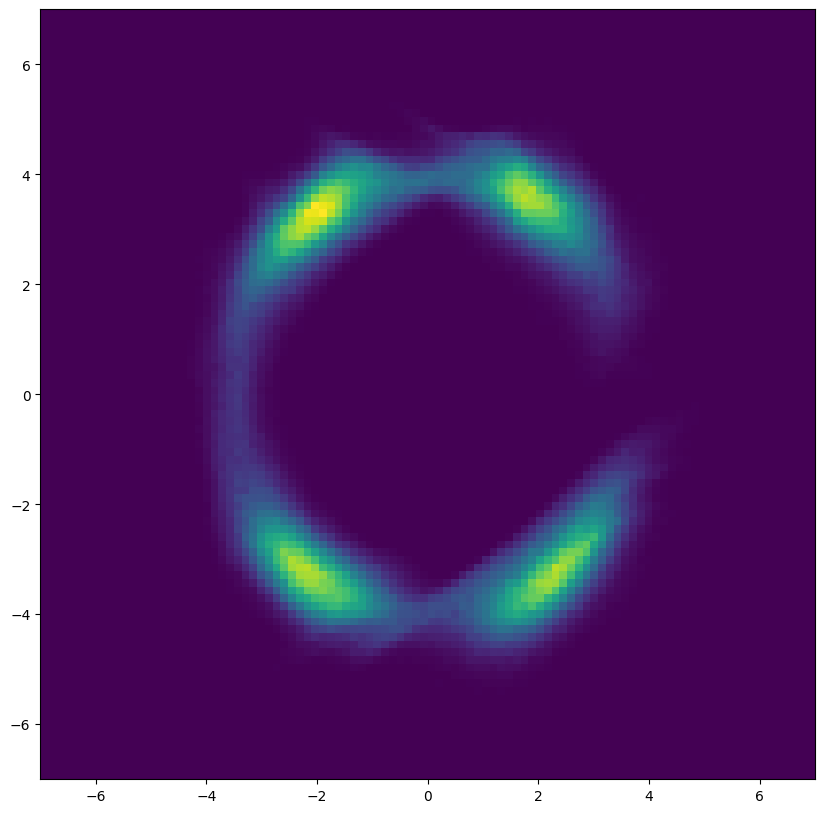

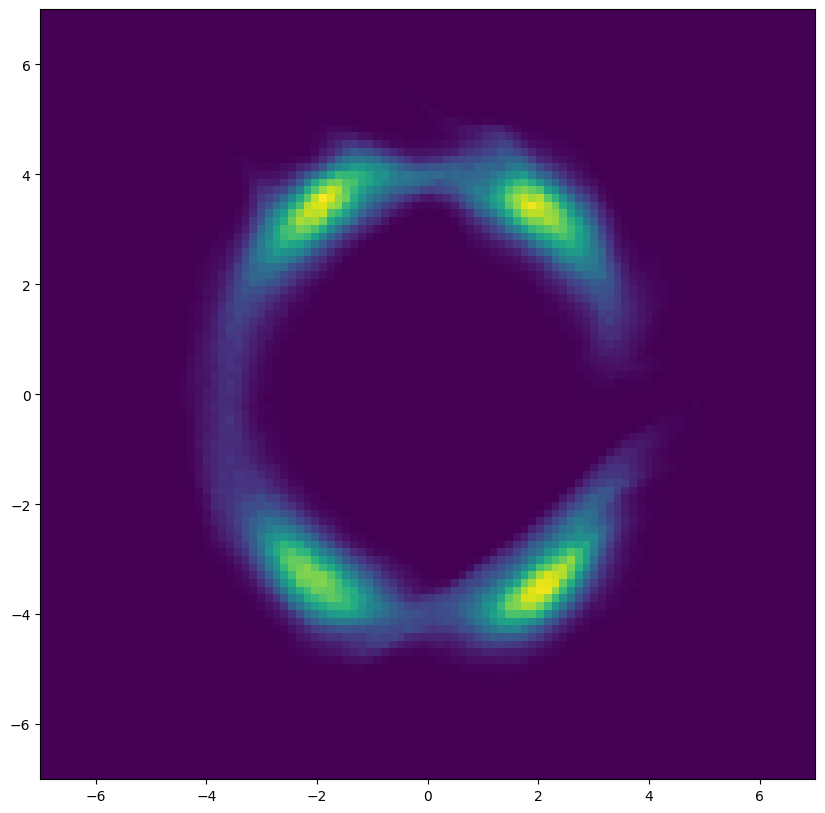

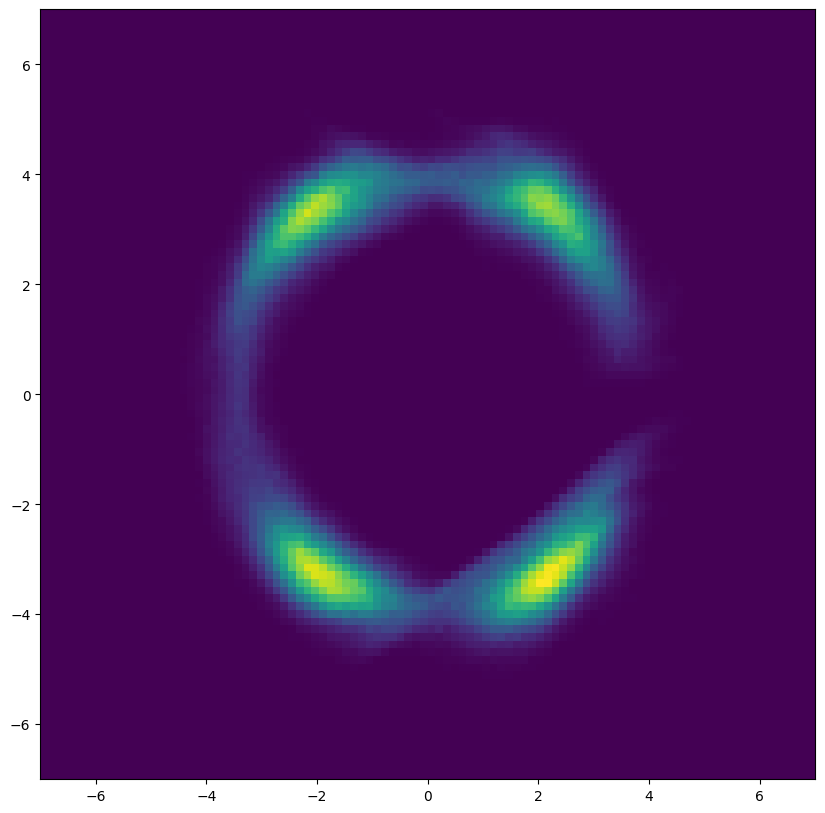

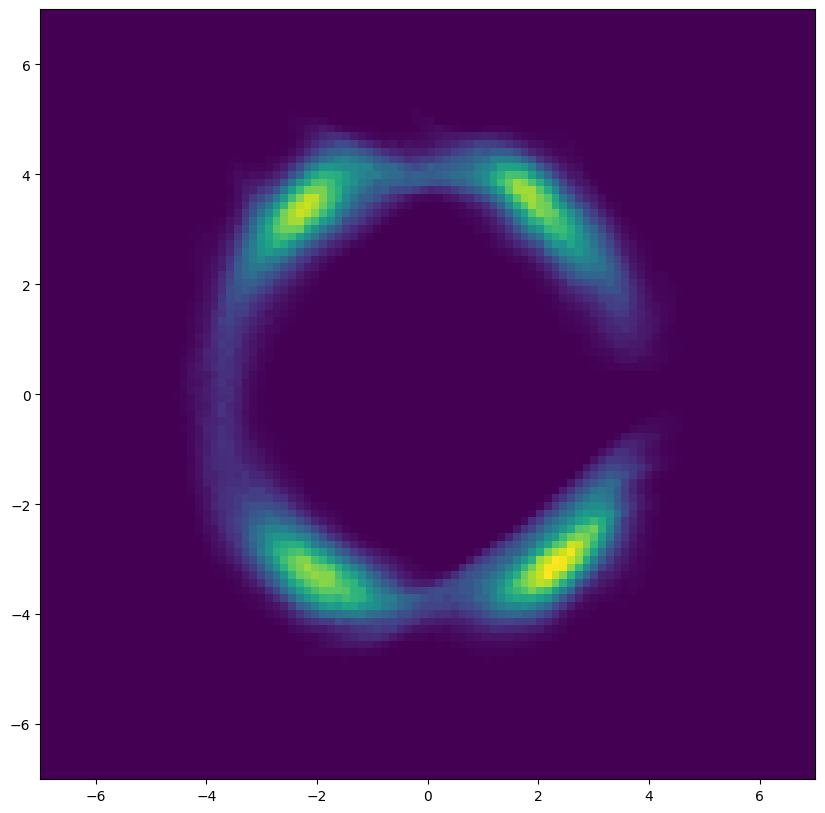

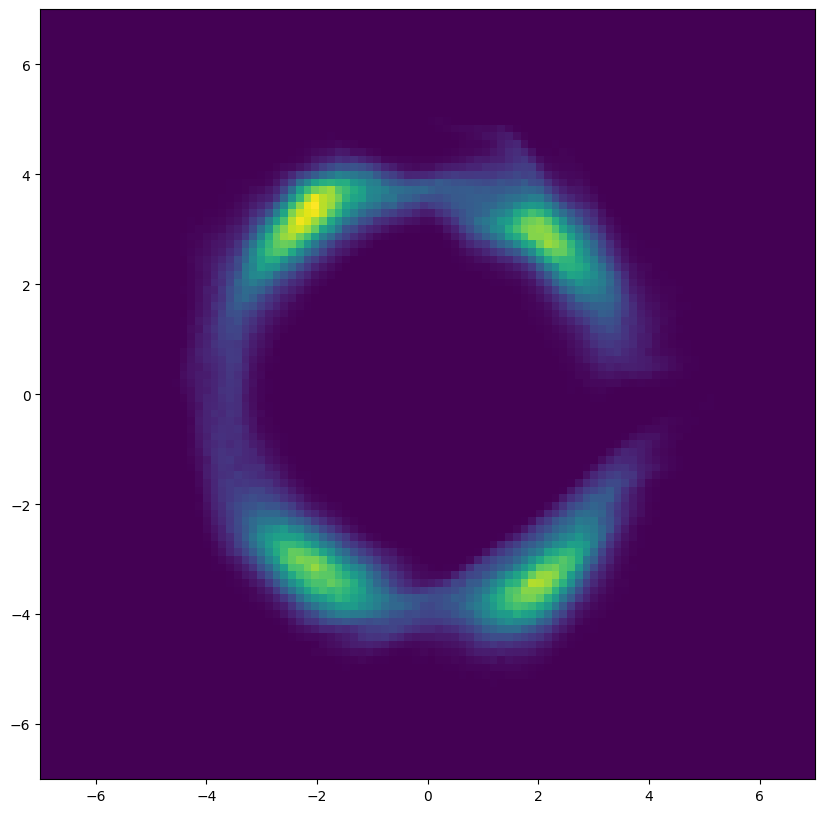

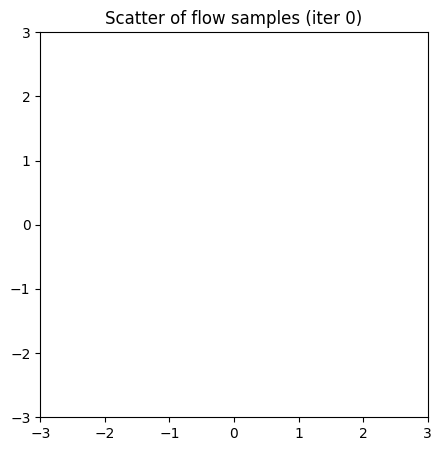

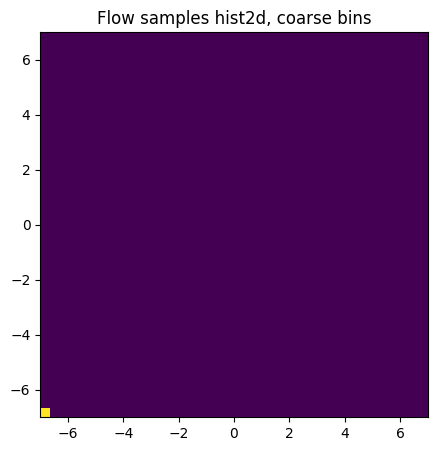

In [ ]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import imageio
import optax

from learning.module.bijx.utils import render_flow_pdf_2d_subplots
def target1(x):
    # Mixture of two Gaussians
    mean1 = jnp.array([1.0, 0.4])
    cov1 = 0.3 * jnp.array([[1.0, 0.3], [0.3, 1.0]])

    mean2 = jnp.array([-1.0, -0.4])
    cov2 = 0.1 * jnp.array([[1.0, -0.3], [-0.3, 1.0]])

    pdf1 = jax.scipy.stats.multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = jax.scipy.stats.multivariate_normal.pdf(x, mean2, cov2)

    return jnp.log(0.4 * pdf1 + 0.6 * pdf2)
def target2(z):
    z1, z2 = jnp.split(z, 2, axis=-1)
    norm = jnp.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = jnp.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = jnp.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - jnp.log(exp1 + exp2)

    return -u
def reward_corner(contexts, target=jnp.array([0.3, 0.7]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    diff = contexts - target[None, :]
    r = jnp.exp(-0.5 * jnp.sum((diff / sigma) ** 2, axis=-1))
    if key is not None:
        r = jnp.clip(r + noise_std * jax.random.normal(key, r.shape), 0.0, 1.0)
    return r

volume = jnp.prod(high - low)
N = 2 **10
@jax.jit
def train_step(params, opt_state, key):
    optimizer = optax.adam(learning_rate=1e-3)
    kr, kc = jax.random.split(key, 2)
    def loss_fn(params):
        contexts, logq = realnvp.apply(params, mode="sample", n_samples=N, rng=kc)
        # logp  = reward_corner(contexts, key=kr)
        # logp = target1(contexts)
        logp = target2(contexts)
        # returns = jax.lax.stop_gradient(returns)
        return jnp.mean(logq-logp)
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state= optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

def run_toy_corner(flow_params, flow_opt):
    x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
    grid = jnp.c_[x.ravel(), y.ravel()]
    pdf_values = reward_corner(grid)
    # pdf_values = target1(grid)
    pdf_values = target2(grid)
    pdf_values = jnp.exp(pdf_values)
    pdf_values = jnp.reshape(pdf_values, x.shape)
    T = 1000
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 10))
    key = jax.random.PRNGKey(0)
    gif_frames = [] 
    
    for t in range(T):
        kplot, ktrain, key = jax.random.split(key, 3)
        flow_params, flow_opt, loss = train_step(flow_params, flow_opt, ktrain)
        if t in snap_iters:
            fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=20)
            ax_reward.set_title("reward_corner landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            ax_NF = render_flow_pdf_2d_subplots(
                log_prob_fn=lambda x: realnvp.apply(flow_params, mode="log_prob", x=x),
                low=low,
                high=high,
                ax=ax_NF,
            )
            ax_NF.set_title(f"NF(RealNVP) training distribution (iter {t})")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            plt.close(fig)
            z, _ = realnvp.apply(flow_params, mode="sample", n_samples=2**20, rng=kplot)
            plt.figure(figsize=(10,10))
            plt.hist2d(z[:, 0].flatten(), z[:, 1].flatten(), (100, 100), #range=[[-3, 3], [-3, 3]])
                    range=[[low[0], high[0]], [low[1], high[1]]])


    if gif_frames:
        imageio.mimsave("NF_RealNVP_training.gif", gif_frames, fps=4)
        print("Saved GIF to NF_RealNVP_training.gif")
    key = jax.random.PRNGKey(0)
    z, _ = realnvp.apply(flow_params, mode="sample", n_samples=200_000, rng=kplot)

    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.2)
    plt.xlim(low[0], high[0])
    plt.ylim(low[1], high[1])
    plt.title("Scatter of flow samples (iter 0)")
    plt.show()

    # 2) Coarse 2D histogram to kill striping
    plt.figure(figsize=(5, 5))
    plt.hist2d(x[:, 0], x[:, 1], bins=40, range=[[low[0], high[0]], [low[1], high[1]]])
    plt.title("Flow samples hist2d, coarse bins")
    plt.show()

x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
grid = jnp.c_[x.ravel(), y.ravel()]
# pdf_values = reward_corner(grid)
# pdf_values = target1(grid)
pdf_values = target2(grid)
pdf_values = jnp.exp(pdf_values)
pdf_values = jnp.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
cbar = fig.colorbar(ctf)
ax = render_flow_pdf_2d_subplots(
    log_prob_fn=lambda x: realnvp.apply(flow_params, mode="log_prob", x=x),
    low=low,
    high=high,
)
init_params = realnvp.init(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=1e-3) # weight_decay = 1e-4)
init_state = optimizer.init(flow_params)
run_toy_corner(init_params, init_state)
